In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from matplotlib import gridspec

import data_utils
import model_utils
import plot_utils
import open_data

In [2]:
def load_model(model_name, train, test, train_targ, test_targ):
    """
        Loaded previous train CNN model
    """
    print(model_name)
#     new_model = keras.models.load_model("../outputs/model_checkpoint/model_checkpoint_%s.h5"%model_name)
    new_model = keras.models.load_model("../outputs/model_checkpoint/model_checkpoint_%s.h5"%model_name)

    # -- feautres need to have an extra axis on the end (for mini-batching)
    feat_tr2 = train.reshape(len(train), train.shape[1], train.shape[2], 1)
    feat_te2 = test.reshape(len(test), test.shape[1], test.shape[2], 1)

    # -- print the accuracy
    loss_tr, acc_tr = new_model.evaluate(feat_tr2, train_targ, verbose=0)
    loss_te, acc_te = new_model.evaluate(feat_te2, test_targ, verbose=0)
        
    print("Training accuracy : {0:.4f}".format(acc_tr))
    print("Testing accuracy  : {0:.4f}".format(acc_te))

    return acc_tr, acc_te, new_model

In [3]:
def datas(df_tr, df_te, model_name):
    print(model_name)
    div = model_name.split("_")[1]
    if div[0:2] == "3D" or div[0:2] == "2D":
        data_location = "../data/data_split/"
    if div[0:2] == "n3" or div[0:2] == "n2":
        data_location = "../data/data_split_n/"
    if div[0:2] == "3s":
        data_location = "../data/data_split_3s/"
    print(data_location)
    #data_location = "../data/data_split_n/"                                                                                                                         
    if div[-3:] == "3DH":
        ddhs = 0
    if div[-3:] == "2DH":
        ddhs = 1

    train, test, train_targ, test_targ, train_ID, test_ID = data_utils.read_data_folders(data_location, 1,
                                                                          2000, ddh = ddhs)
    
    print(train.shape, test.shape)
    acc_tr, acc_te, model = load_model(model_name, train, test, train_targ, test_targ)
    df_pred_te, y_pred_te = model_utils.predict_data(test, model, 1, test_ID,test_targ)
    
    return train, test, train_targ, test_targ, train_ID, test_ID,df_pred_te,y_pred_te,model
    

In [81]:
df_tr = pd.DataFrame()
df_te = pd.DataFrame()

train, test, train_targ, test_targ, train_ID, test_ID,df_te,y_pred_test,loaded_model = datas(df_tr, df_te, "AAAD_3s3DH")

AAAD_3s3DH
../data/data_split_3s/
Done with 0
Done with 1
Done with 2
Done with 3
Done with 4
Done with 5
Done with 6
Done with 7
Done with 8
Done with 9
(10, 51, 153) (20000, 51, 153)
AAAD_3s3DH
Training accuracy : 0.6000
Testing accuracy  : 0.9590


In [83]:
feat_te2 = test.reshape(len(test), 51, 153, 1)

In [84]:
def saliency_map(j):
    images = tf.convert_to_tensor(feat_te2[2000*j:(j*2000)+2000], dtype=tf.float32)

    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(images)

    #     pred = y_pred_test
        pred = loaded_model(images, training=False)
        max_outp = tf.reduce_max(pred, 1)
    #     loss = np.argmax(y_pred_test,axis=1)

    #     class_idxs_sorted = np.argsort(pred.flatten())[::-1]
    #     loss = pred.flatten()[class_idxs_sorted]
    # loss1 = tf.convert_to_tensor(loss, dtype=tf.float32)
    grads = tape.gradient(max_outp, images)
    print(grads.shape)
    dgrad_abs = tf.math.abs(grads)

    return dgrad_abs

In [85]:
def add_means(j,dgrad_abs):    
    diffmena = np.mean(dgrad_abs[:, :, :51,:], axis=(1,2))
    srchmena = np.mean(dgrad_abs[:, :, 51:102,:], axis=(1,2))
    tempmena = np.mean(dgrad_abs[:, :, 102:,:], axis=(1,2))
    df_te1 = df_te[2000*j:(j*2000)+2000].copy()

    df_te1["diff"] = diffmena
    df_te1["srch"] = srchmena
    df_te1["temp"] = tempmena
    
    return df_te1

In [86]:
df_te0 = add_means(0,saliency_map(0))
df_te1 = add_means(1,saliency_map(1))
df_te2 = add_means(2,saliency_map(2))
df_te3 = add_means(3,saliency_map(3))
df_te4 = add_means(4,saliency_map(4))
df_te5 = add_means(5,saliency_map(5))
df_te6 = add_means(6,saliency_map(6))
df_te7 = add_means(7,saliency_map(7))
df_te8 = add_means(8,saliency_map(8))
df_te9 = add_means(9,saliency_map(9))

(2000, 51, 153, 1)
(2000, 51, 153, 1)
(2000, 51, 153, 1)
(2000, 51, 153, 1)
(2000, 51, 153, 1)
(2000, 51, 153, 1)
(2000, 51, 153, 1)
(2000, 51, 153, 1)
(2000, 51, 153, 1)
(2000, 51, 153, 1)


In [87]:
vertical_concat = pd.concat([df_te0, df_te1, df_te2, df_te3, df_te4, df_te5, df_te6, df_te7, df_te8, df_te9], axis=0)


In [88]:
diff_winner = vertical_concat[(vertical_concat["diff"]>vertical_concat["srch"])&
                (vertical_concat["diff"]>vertical_concat["temp"])]
diff_winner["winner"] = ["diff"]*len(diff_winner)
srch_winner = vertical_concat[(vertical_concat["srch"]>vertical_concat["diff"])&
                (vertical_concat["srch"]>vertical_concat["temp"])]
srch_winner["winner"] = ["srch"]*len(srch_winner)
temp_winner = vertical_concat[(vertical_concat["temp"]>vertical_concat["diff"])&
                (vertical_concat["temp"]>vertical_concat["srch"])]
temp_winner["winner"] = ["temp"]*len(temp_winner)

/global/homes/t/taceroc/.conda/envs/tff1/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/global/homes/t/taceroc/.conda/envs/tff1/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/global/homes/t/taceroc/.conda/envs/tff1/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a

In [89]:
winner_concat = pd.concat([diff_winner, srch_winner, temp_winner], axis=0)

In [90]:
con_matG = tf.math.confusion_matrix(labels=winner_concat["OBJECT_TYPE"], predictions=winner_concat["predicted"]).numpy()
con_matG.flatten()
con_mat_normG = np.around(con_matG.astype('float') / con_matG.sum(axis=1)[:, np.newaxis], decimals=2)
con_mat_dfG = pd.DataFrame(con_mat_normG,
                 index = [0,1], 
                 columns = [0,1])
con_matG,con_mat_dfG

(array([[9564,  514],
        [ 306, 9616]], dtype=int32),
       0     1
 0  0.95  0.05
 1  0.03  0.97)

In [91]:
con_matdiff = tf.math.confusion_matrix(labels=diff_winner["OBJECT_TYPE"], predictions=diff_winner["predicted"]).numpy()
con_matdiff.flatten()
con_mat_normdiff = np.around(con_matdiff.astype('float') / con_matG, decimals=2)
con_matdiff,con_mat_normdiff

(array([[8630,  444],
        [ 291, 5844]], dtype=int32),
 array([[0.9 , 0.86],
        [0.95, 0.61]]))

In [92]:
con_matsrch = tf.math.confusion_matrix(labels=srch_winner["OBJECT_TYPE"], predictions=srch_winner["predicted"]).numpy()
con_matsrch.flatten()
con_mat_normsrch = np.around(con_matsrch.astype('float') / con_matG, decimals=2)
con_matsrch,con_mat_normsrch

(array([[ 847,   35],
        [   9, 1200]], dtype=int32),
 array([[0.09, 0.07],
        [0.03, 0.12]]))

In [93]:
con_mattemp = tf.math.confusion_matrix(labels=temp_winner["OBJECT_TYPE"], predictions=temp_winner["predicted"]).numpy()
con_mattemp.flatten()
con_mat_normtemp = np.around(con_mattemp.astype('float') / con_matG, decimals=2)
con_mattemp,con_mat_normtemp

(array([[  87,   35],
        [   6, 2572]], dtype=int32),
 array([[0.01, 0.07],
        [0.02, 0.27]]))

In [94]:
# testt = np.array(([4,2], [1.1,3.2]))
# testt

testt = np.array(([4,2], [1,3]))
testt

array([[4, 2],
       [1, 3]])

In [95]:
import matplotlib
from matplotlib.colors import Normalize
cmap = matplotlib.cm.get_cmap('PuBuGn')
# Normalize data
norm = Normalize(vmin=testt.min(), vmax=5)
rgba_values = cmap(norm(testt))
rgba_values[1,1]*255

##014636 0,0 #04828c
##fff7fb
##d4d3e7
###1987a2 1,1 #6eabd0


##fbb3bb light pink
##49006a dark purple
##b70b83 dark pink
##fff7f3 white

array([102.23137255, 168.60784314, 206.76470588, 255.        ])

In [111]:
from matplotlib import colors

# make a color map of fixed colors
# cmap = colors.ListedColormap(['#eed9e2','#FF9AC8','#6eb8e4', '#04c1b1'])

cooll = ['#ffb04b','#ff834d','#7b93cc','#465eb4']
cmap = colors.ListedColormap(cooll)

alp = 0.8
bounds=[1,2,3,4]#0493b1#f66ca5
norm = colors.BoundaryNorm(bounds, cmap.N)

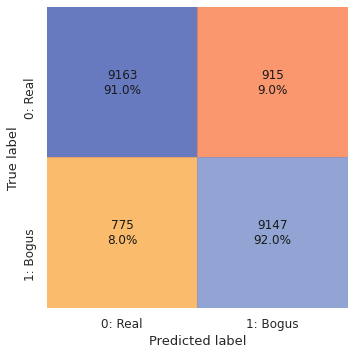

In [138]:
# labels = [f"diff:{v3} ({v4*100:.1f}%)\nsrch:{v5} ({v6*100:.1f}%)\ntmpl:{v7} ({v8*100:.1f}%)" for v3, v4, v5, v6, v7, v8 in
#       zip(con_matdiff.flatten(),con_mat_normdiff.flatten()
#          ,con_matsrch.flatten(), con_mat_normsrch.flatten(),con_mattemp.flatten(), con_mat_normtemp.flatten())]

labels = [f"{v1}\n{v2*100}%" for v1, v2 in
      zip(con_matG.flatten(),con_mat_normG.flatten())]


labels = np.asarray(labels).reshape(2,2)
categories = ["0: Real", "1: Bogus"]

figure = plt.figure(figsize=(5, 5))
ax = sns.heatmap(testt, annot=labels, annot_kws = {"color":"k", "fontsize":12}, 
            cbar=False,fmt='',xticklabels=categories,yticklabels=categories,
            cmap=cmap, alpha = alp, vmin = 1, vmax=4)#plt.cm.Blues)
ax.set_xticklabels(ax.get_xticklabels(), size = 12)
ax.set_yticklabels(ax.get_yticklabels(), size = 12)

# PuBuGn
# RdPu
# RdYlBu
plt.tight_layout()
plt.ylabel('True label', fontsize = 13)
plt.xlabel('Predicted label', fontsize = 13)
# plt.set_aspect('equal', adjustable='box')
# plt.savefig("confusionmatrix_saliencyDIA_poster.pdf",bbox_inches="tight")

# plt.savefig("confusionmatrix_model_more_dataAAAD_3s3DH_newcolors.pdf",bbox_inches="tight")
plt.show()

/global/homes/t/taceroc/.conda/envs/tff1/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  This is separate from the ipykernel package so we can avoid doing imports until


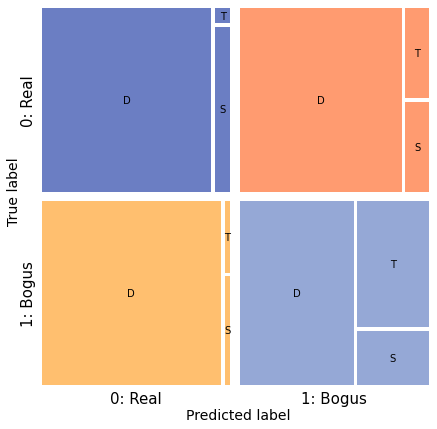

In [251]:

import squarify
fig, ax = plt.subplots(2,2, figsize = (7,7),constrained_layout=True)
fig.subplots_adjust(None, None, None, None, 0.03, 0.03)
sizes=[90, 9, 1]
label=["D", "S", "T"]
ax[0,0] = squarify.plot(sizes=sizes, label=label, alpha=alp,color='#465eb4', pad=True,ax=ax[0,0])
ax[0,0].set_ylabel("0: Real" ,fontsize = 15)
ax[0,0].set_xticks([]) 
ax[0,0].set_yticks([])
ax[0,0].set_frame_on(False)


sizes=[86, 7, 7]
ax[0,1] = squarify.plot(sizes=sizes, label=label, alpha=alp,color='#ff834d', pad=True,ax=ax[0,1])
ax[0,1].axis("off")
sizes=[95, 3, 2]
ax[1,0] = squarify.plot(sizes=sizes, label=label, alpha=alp,color='#ffb04b', pad=True,ax=ax[1,0])
ax[1,0].set_xlabel("0: Real" ,fontsize = 15)
ax[1,0].set_xticks([]) 
ax[1,0].set_yticks([])
ax[1,0].set_frame_on(False)

ax[1,0].set_ylabel("1: Bogus" ,fontsize = 15)
ax[1,0].set_xticks([]) 
ax[1,0].set_yticks([])
ax[1,0].set_frame_on(False)

sizes=[61, 12, 27]
ax[1,1] = squarify.plot(sizes=sizes, label=label, alpha=alp,color='#7b93cc', pad=True,ax=ax[1,1])
ax[1,1].set_xlabel("1: Bogus" ,fontsize = 15)
ax[1,1].set_xticks([]) 
ax[1,1].set_yticks([])
ax[1,1].set_frame_on(False)
plt.text(-27,-17,'Predicted label', fontsize = 14)
plt.text(-120,88,'True label', rotation=90, fontsize = 14)
# plt.savefig("confusionmatrix_saliencyDIA_new.pdf",bbox_inches="tight")
# plt.show()

In [143]:
dgrad_abs0 = saliency_map(0)
dgrad_abs1 = saliency_map(1)
dgrad_abs2 = saliency_map(2)
dgrad_abs3 = saliency_map(3)
dgrad_abs4 = saliency_map(4)
dgrad_abs5 = saliency_map(5)
dgrad_abs6 = saliency_map(6)
dgrad_abs7 = saliency_map(7)
dgrad_abs8 = saliency_map(8)
dgrad_abs9 = saliency_map(9)

(2000, 51, 153, 1)
(2000, 51, 153, 1)
(2000, 51, 153, 1)
(2000, 51, 153, 1)
(2000, 51, 153, 1)
(2000, 51, 153, 1)
(2000, 51, 153, 1)
(2000, 51, 153, 1)
(2000, 51, 153, 1)
(2000, 51, 153, 1)


In [144]:
dgrad_abs = np.concatenate((dgrad_abs0, dgrad_abs1, dgrad_abs2, dgrad_abs3, 
                dgrad_abs4, dgrad_abs5, dgrad_abs6, dgrad_abs7, 
                dgrad_abs8, dgrad_abs9))
np.save("sm_3DH",dgrad_abs)
dgrad_abs.shape

(20000, 51, 153, 1)

In [145]:
def add_gregsmetric(j,dgrad_abs):    
    diffmena = np.sum(dgrad_abs[:, :, :51,:], axis=(1,2)) /np.sum(dgrad_abs[:,:,:,:], axis = (1,2))
    srchmena = np.sum(dgrad_abs[:, :, 51:102,:], axis=(1,2))/np.sum(dgrad_abs[:,:,:,:], axis = (1,2))
    tempmena = np.sum(dgrad_abs[:, :, 102:,:], axis=(1,2))/np.sum(dgrad_abs[:,:,:,:], axis = (1,2))
    df_te1 = df_te[2000*j:(j*2000)+2000].copy()

    df_te1["diff_gm"] = diffmena
    df_te1["srch_gm"] = srchmena
    df_te1["temp_gm"] = tempmena
    
    return df_te1

In [146]:
df_te0_p = add_gregsmetric(0,dgrad_abs0)
df_te1_p = add_gregsmetric(1,dgrad_abs1)
df_te2_p = add_gregsmetric(2,dgrad_abs2)
df_te3_p = add_gregsmetric(3,dgrad_abs3)
df_te4_p = add_gregsmetric(4,dgrad_abs4)
df_te5_p = add_gregsmetric(5,dgrad_abs5)
df_te6_p = add_gregsmetric(6,dgrad_abs6)
df_te7_p = add_gregsmetric(7,dgrad_abs7)
df_te8_p = add_gregsmetric(8,dgrad_abs8)
df_te9_p = add_gregsmetric(9,dgrad_abs9)


In [147]:
df_te1_p[df_te1_p["ID"] == 8303161]

,ID,OBJECT_TYPE,predicted_float_Real,predicted_float_Bogus,predicted,diff_gm,srch_gm,temp_gm
3412,8303161,0,0.447437,0.552563,1,0.338841,0.260842,0.400317


In [148]:
df_te[df_te["ID"] == 8303161]

,ID,OBJECT_TYPE,predicted_float_Real,predicted_float_Bogus,predicted
3412,8303161,0,0.447437,0.552563,1


In [149]:
vertical_concat_p = pd.concat([df_te0_p, df_te1_p, df_te2_p, df_te3_p, df_te4_p, df_te5_p, df_te6_p, 
                               df_te7_p, df_te8_p, df_te9_p], axis=0)


In [150]:
vertical_concat_p[vertical_concat_p["ID"] == 8303161 ]

,ID,OBJECT_TYPE,predicted_float_Real,predicted_float_Bogus,predicted,diff_gm,srch_gm,temp_gm
3412,8303161,0,0.447437,0.552563,1,0.338841,0.260842,0.400317


In [151]:
vertical_concat_p[vertical_concat_p["ID"] == 11873901 ]

,ID,OBJECT_TYPE,predicted_float_Real,predicted_float_Bogus,predicted,diff_gm,srch_gm,temp_gm
10403,11873901,0,0.997804,0.002196,0,0.585501,0.237509,0.176991


In [152]:
vertical_concat_p[vertical_concat_p["ID"] == 6960264 ]

,ID,OBJECT_TYPE,predicted_float_Real,predicted_float_Bogus,predicted,diff_gm,srch_gm,temp_gm
17001,6960264,1,0.006795,0.993205,1,0.201154,0.259535,0.539311


In [153]:
vertical_concat_p[vertical_concat_p["ID"] == 11872501 ]

,ID,OBJECT_TYPE,predicted_float_Real,predicted_float_Bogus,predicted,diff_gm,srch_gm,temp_gm
4999,11872501,1,0.0017,0.9983,1,0.379531,0.316815,0.303654


In [154]:
vertical_concat_p[vertical_concat_p["ID"] == 11345377 ]

,ID,OBJECT_TYPE,predicted_float_Real,predicted_float_Bogus,predicted,diff_gm,srch_gm,temp_gm
7440,11345377,1,0.045496,0.954504,1,0.420685,0.325484,0.25383


In [155]:
vertical_concat_p[vertical_concat_p["ID"] == 8982164 ]

,ID,OBJECT_TYPE,predicted_float_Real,predicted_float_Bogus,predicted,diff_gm,srch_gm,temp_gm
9693,8982164,1,0.017315,0.982685,1,0.586043,0.253218,0.160739


In [156]:
vertical_concat_p[vertical_concat_p["ID"] == 8645524 ]

,ID,OBJECT_TYPE,predicted_float_Real,predicted_float_Bogus,predicted,diff_gm,srch_gm,temp_gm
5616,8645524,1,0.003952,0.996048,1,0.284679,0.299409,0.415912


In [157]:
diff_winner_p = vertical_concat_p[(vertical_concat_p["diff_gm"]>vertical_concat_p["srch_gm"])&
                (vertical_concat_p["diff_gm"]>vertical_concat_p["temp_gm"])]
diff_winner_p["winner_gm"] = ["diff_gm"]*len(diff_winner_p)
srch_winner_p = vertical_concat_p[(vertical_concat_p["srch_gm"]>vertical_concat_p["diff_gm"])&
                (vertical_concat_p["srch_gm"]>vertical_concat_p["temp_gm"])]
srch_winner_p["winner_gm"] = ["srch_gm"]*len(srch_winner_p)
temp_winner_p = vertical_concat_p[(vertical_concat_p["temp_gm"]>vertical_concat_p["diff_gm"])&
                (vertical_concat_p["temp_gm"]>vertical_concat_p["srch_gm"])]
temp_winner_p["winner_gm"] = ["temp_gm"]*len(temp_winner_p)

/global/homes/t/taceroc/.conda/envs/tff1/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/global/homes/t/taceroc/.conda/envs/tff1/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/global/homes/t/taceroc/.conda/envs/tff1/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a

In [158]:
winner_concat_p = pd.concat([diff_winner_p, srch_winner_p, temp_winner_p], axis=0)

In [159]:
con_matdiff_p = tf.math.confusion_matrix(labels=diff_winner_p["OBJECT_TYPE"], predictions=diff_winner_p["predicted"]).numpy()
con_matdiff_p.flatten()
con_mat_normdiff_p = np.around(con_matdiff_p.astype('float') / con_matG, decimals=2)
con_matdiff_p,con_mat_normdiff_p

(array([[8630,  444],
        [ 291, 5844]], dtype=int32),
 array([[0.9 , 0.86],
        [0.95, 0.61]]))

In [160]:
con_matsrch_p = tf.math.confusion_matrix(labels=srch_winner_p["OBJECT_TYPE"], predictions=srch_winner_p["predicted"]).numpy()
con_matsrch_p.flatten()
con_mat_normsrch_p = np.around(con_matsrch_p.astype('float') / con_matG, decimals=2)
con_matsrch_p,con_mat_normsrch_p

(array([[ 847,   35],
        [   9, 1200]], dtype=int32),
 array([[0.09, 0.07],
        [0.03, 0.12]]))

In [161]:
# fig, axes = plt.subplots(8,2,figsize=(19,23))
# fig.subplots_adjust(0.1, 0.05, 0.95, 0.95, -0.1, 0.3)


# indexes = diff_winner.index[67:75]
# for jj,ii in enumerate(indexes):
#     axes[jj,0].imshow(feat_te2[ii],cmap = "PRGn",clim = (-4,4))
#     mm = axes[jj,1].imshow(dgrad_abs[ii],cmap = "PRGn",clim = (-np.array(dgrad_abs[ii]).max(),np.array(dgrad_abs[ii]).max()))
#     axes[jj,0].text(140,-6, 
#                     "ID: {}, label: {}, pred: {} ".format(int(test_ID[ii]), 
#                                                           int(test_targ[ii]), df_te["predicted"][ii]), 
#                     fontsize = 12)
#     fig.colorbar(mm, ax = axes[jj,:],fraction=0.047)
    
    

In [162]:
flist = np.load('../data/paths.npy')
flist = [f for f in flist if int(f.split('/')[-1][4:-5]) in vertical_concat['ID'].to_numpy()]

inicial = '/global/cscratch1/sd/taceroc/'
flist2 = [flist[i][:len(inicial)] + 'BOGLC/' + flist[i][len(inicial):] for i in range(len(flist))]

# -- sort as: diff, srch, temp
flist3 = sorted(flist2, key=lambda s: s.split('/')[-1][:4])
# -- sort as: descending ID, convert float to integer 
flist3 = sorted(flist2, key=lambda s: int(s.split('/')[-1][4:-5]))

In [163]:
# data_full = open_data.open_fits(vertical_concat, flist3)


In [164]:
# np.save("data_full_orig", data_full)

In [165]:
data_full = np.load("data_full_orig.npy")

In [166]:
data_full.shape

(60000, 51, 51)

In [167]:
# from matplotlib import gridspec
# fig, ax = plt.subplots(8, 6,figsize=(30,39),constrained_layout=True)
# # fig = plt.figure(figsize=(19,23),constrained_layout=True)
# # fig.subplots_adjust(0.1, 0.05, 0.95, 0.95, -0.1, 0.3)

# gs = gridspec.GridSpec(8, 6)#,left=1,right=1.5,top=1.4,bottom=1)
# # indexes = diff_winner.index[17:25]
# np.random.seed(626)
# indexes = diff_winner.sample(8).index
# for jj,ii in enumerate(indexes):
#     index = np.where(np.char.find(flist3, str(vertical_concat["ID"].to_numpy()[ii]))>=0)
#     ax[jj,0] = plt.subplot(gs[jj, 0])
#     cmst0 = ax[jj,0].imshow(data_full[index[0][0]],cmap = "Greys", clim = (data_full[index[0][0]].min(),data_full[index[0][0]].max()))
# #     ax[jj,0].imshow(data_full[index[0][0]],cmap = "Greys", clim = (data_full[index[0][0]].min(),data_full[index[0][0]].max()))
#     ax[jj,1] = plt.subplot(gs[jj, 1])
#     cmst1 = ax[jj,1].imshow(data_full[index[0][1]],cmap = "Greys", clim = (data_full[index[0][1]].min(),data_full[index[0][1]].max()))
#     ax[jj,2] = plt.subplot(gs[jj, 2])
#     cmst2 = ax[jj,2].imshow(data_full[index[0][2]],cmap = "Greys", clim = (data_full[index[0][2]].min(),data_full[index[0][2]].max()))
    
#     ax[jj,3] = plt.subplot(gs[jj, 3:])
#     mm = ax[jj,3].imshow(dgrad_abs[ii],cmap = "PRGn",clim = (-np.array(dgrad_abs[ii]).max(),np.array(dgrad_abs[ii]).max()))
#     ax[jj,0].text(140,-6, 
#                     "ID: {}, label: {}, pred: {} ".format(int(test_ID[ii]), 
#                                                           int(test_targ[ii]), df_te["predicted"][ii]), 
#                     fontsize = 15)
#     fig.colorbar(mm, ax = ax[jj,3],fraction=0.047)
#     fig.colorbar(cmst0, ax = ax[jj, 0],fraction=0.047)
#     fig.colorbar(cmst1, ax = ax[jj, 1],fraction=0.047)
#     fig.colorbar(cmst2, ax = ax[jj, 2],fraction=0.047)

# # plt.show()
    

In [168]:
# fig, ax = plt.subplots(8, 6,figsize=(30,39),constrained_layout=True)
# # fig = plt.figure(figsize=(19,23),constrained_layout=True)
# # fig.subplots_adjust(0.1, 0.05, 0.95, 0.95, -0.1, 0.3)

# gs = gridspec.GridSpec(8, 6)#,left=1,right=1.5,top=1.4,bottom=1)
# np.random.seed(66)
# indexes = winner_concat.sample(8).index
# for jj,ii in enumerate(indexes):
#     index = np.where(np.char.find(flist3, str(vertical_concat["ID"].to_numpy()[ii]))>=0)
#     ax[jj,0] = plt.subplot(gs[jj, 0])
#     cmst0 = ax[jj,0].imshow(data_full[index[0][0]],cmap = "Greys", clim = (data_full[index[0][0]].min(),data_full[index[0][0]].max()))
# #     ax[jj,0].imshow(data_full[index[0][0]],cmap = "Greys", clim = (data_full[index[0][0]].min(),data_full[index[0][0]].max()))
#     ax[jj,1] = plt.subplot(gs[jj, 1])
#     cmst1 = ax[jj,1].imshow(data_full[index[0][1]],cmap = "Greys", clim = (data_full[index[0][1]].min(),data_full[index[0][1]].max()))
#     ax[jj,2] = plt.subplot(gs[jj, 2])
#     cmst2 = ax[jj,2].imshow(data_full[index[0][2]],cmap = "Greys", clim = (data_full[index[0][2]].min(),data_full[index[0][2]].max()))
    
#     ax[jj,3] = plt.subplot(gs[jj, 3:])
#     mm = ax[jj,3].imshow(dgrad_abs[ii],cmap = "PRGn",clim = (-np.array(dgrad_abs[ii]).max(),np.array(dgrad_abs[ii]).max()))
#     ax[jj,0].text(140,-6, 
#                     "ID: {}, label: {}, pred: {} ".format(int(test_ID[ii]), 
#                                                           int(test_targ[ii]), df_te["predicted"][ii]), 
#                     fontsize = 15)
#     fig.colorbar(mm, ax = ax[jj,3],fraction=0.047)
#     fig.colorbar(cmst0, ax = ax[jj, 0],fraction=0.047)
#     fig.colorbar(cmst1, ax = ax[jj, 1],fraction=0.047)
#     fig.colorbar(cmst2, ax = ax[jj, 2],fraction=0.047)

In [169]:
np.random.seed(66)
index = winner_concat.sample(8).index
index

Int64Index([1483, 7440, 9693, 2355, 18098, 5616, 4776, 12323], dtype='int64')

11345377
8982164
8645524


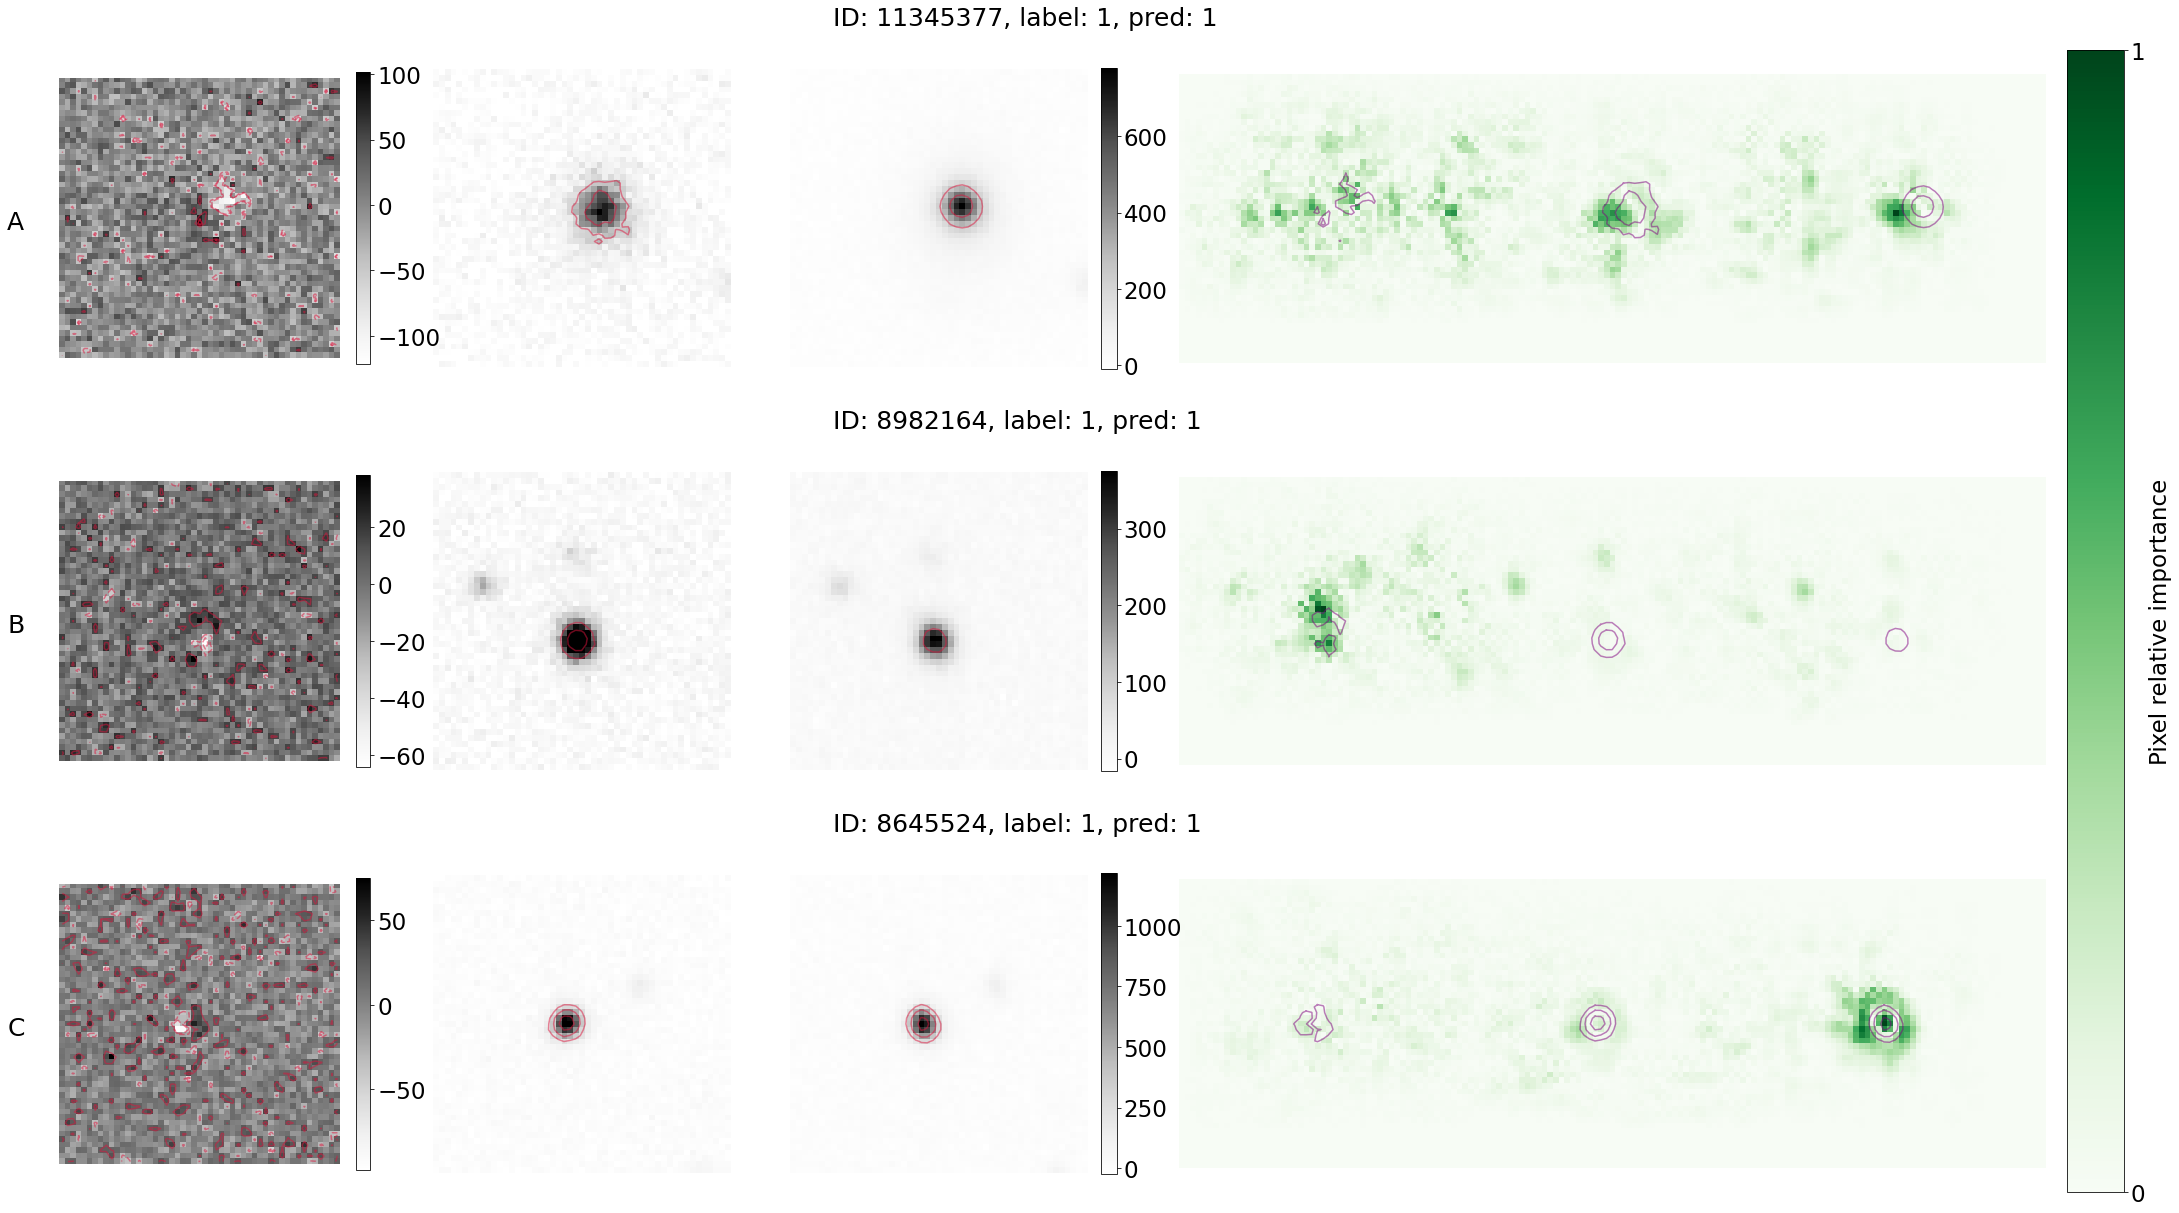

In [171]:
fig, ax = plt.subplots(3, 6,figsize=(39,21))

gs = gridspec.GridSpec(3, 6)#,left=1,right=1.5,top=1.4,bottom=1)
np.random.seed(66)
indexx = winner_concat.sample(8).index
indexes = [1,2,5]
for jj in range(3):

    index = np.where(np.char.find(flist3, str(vertical_concat["ID"].to_numpy()[indexx[indexes[jj]]]))>=0)
    print(str(vertical_concat["ID"].to_numpy()[indexx[indexes[jj]]]))
    ax[jj,0] = plt.subplot(gs[jj, 0])
    ax[jj,0].axis("off")
    cmst0 = ax[jj,0].imshow(data_full[index[0][0]],cmap = "Greys", clim = (data_full[index[0][0]].min(),data_full[index[0][0]].max()))
    if jj == 0:
        contodiff0 = ax[jj,0].contour(data_full[index[0][0]], levels=[-50, 50, 80], colors='crimson', alpha=0.5)
        xd0 = []
        yd0 = []
        ll = 0
        for ee in contodiff0.collections:
            ll = ll+1
        for rr in range(ll):
            if len(contodiff0.collections[rr].get_paths()) != 0:
                for ss in range(len(contodiff0.collections[rr].get_paths())):
                    pd0 = contodiff0.collections[rr].get_paths()[ss]
                    vd0 = pd0.vertices
                    xd0.append(vd0[:,0])
                    yd0.append(vd0[:,1])
    if jj == 1:
        contodiff1 = ax[jj,0].contour(data_full[index[0][0]], levels=[-20,15], colors='crimson', alpha=0.5)
        xd1 = []
        yd1 = []
        ll = 0
        for ee in contodiff1.collections:
            ll = ll+1
        for rr in range(ll):
            if len(contodiff1.collections[rr].get_paths()) != 0:
                for ss in range(len(contodiff1.collections[rr].get_paths())):
                    pd1 = contodiff1.collections[rr].get_paths()[ss]
                    vd1 = pd1.vertices
                    xd1.append(vd1[:,0])
                    yd1.append(vd1[:,1])
                
    if jj == 2:
        contodiff2 = ax[jj,0].contour(data_full[index[0][0]], levels=[-25,19], colors='crimson', alpha=0.5)
        xd2 = []
        yd2 = []
        ll = 0
        for ee in contodiff2.collections:
            ll = ll+1
        for rr in range(ll):
            if len(contodiff2.collections[rr].get_paths()) != 0:
                for ss in range(len(contodiff2.collections[rr].get_paths())):
                    pd2 = contodiff2.collections[rr].get_paths()[ss]
                    vd2 = pd2.vertices
                    xd2.append(vd2[:,0])
                    yd2.append(vd2[:,1])

    contodiff = ax[jj,0].contour(data_full[index[0][0]], levels=[-40, 80, 100], colors='crimson', alpha=0.5)

    ax[jj,1] = plt.subplot(gs[jj, 1])
    ax[jj,1].axis("off")
    cmst1 = ax[jj,1].imshow(data_full[index[0][1]],cmap = "Greys", clim = (data_full[index[0][2]].min(),data_full[index[0][2]].max()))
    contosrch = ax[jj,1].contour(data_full[index[0][1]], levels=[240, 500, 1000, 1600], colors='crimson', alpha=0.5)

    ax[jj,2] = plt.subplot(gs[jj, 2])
    ax[jj,2].axis("off")
    cmst2 = ax[jj,2].imshow(data_full[index[0][2]],cmap = "Greys", clim = (data_full[index[0][2]].min(),data_full[index[0][2]].max()))
    contotemp = ax[jj,2].contour(data_full[index[0][2]], levels=[240, 500, 1000, 1600], colors='crimson', alpha=0.5)

            
            
    x1 = []
    y1 = []
    ll = 0
    for ee in contotemp.collections:
        ll = ll+1
    for rr in range(ll):
        if len(contotemp.collections[rr].get_paths()) != 0:
            p1 = contotemp.collections[rr].get_paths()[0]
            v1 = p1.vertices
            x1.append(v1[:,0])
            y1.append(v1[:,1])
    x2 = []
    y2 = []
    ll = 0
    for ee in contosrch.collections:
        ll = ll+1
    for rr in range(ll):
        if len(contosrch.collections[rr].get_paths()) != 0:
            p2 = contosrch.collections[rr].get_paths()[0]
            v2 = p2.vertices
            x2.append(v2[:,0])
            y2.append(v2[:,1])
    ax[jj,3] = plt.subplot(gs[jj, 3:])
    ax[jj,3].axis("off")
    
    mm = ax[jj,3].imshow(dgrad_abs[indexx[indexes[jj]]],cmap = "Greens",clim = (np.array(dgrad_abs[indexx[indexes[jj]]]).min(),np.array(dgrad_abs[indexx[indexes[jj]]]).max()))
    ax[jj,0].text(140,-10, 
                    "ID: {}, label: {}, pred: {} ".format(int(vertical_concat["ID"].to_numpy()[indexx[indexes[jj]]]), 
                                                          int(vertical_concat["OBJECT_TYPE"].to_numpy()[indexx[jj]]), vertical_concat["predicted"].to_numpy()[indexx[indexes[jj]]]), 
                    fontsize = 25)
    for ii in range(len(x1)):
        ax[jj,3].plot(np.array(x1[ii])+102, np.array(y1[ii]), color='purple', alpha=0.5)
    for ii in range(len(x2)):
        ax[jj,3].plot(np.array(x2[ii])+51, np.array(y2[ii]), color='purple', alpha=0.5)


#     colorbar_sm = fig.colorbar(mm, ax = ax[jj,3],fraction=0.016, pad=0.02)
#     colorbar_sm.ax.tick_params(labelsize=23)
    colorbar_diff = fig.colorbar(cmst0, ax = ax[jj, 0],fraction=0.047)
    colorbar_diff.ax.tick_params(labelsize=23)

    colorbar_srch = fig.colorbar(cmst2, ax = ax[jj, 1:3],fraction=0.022, pad=0.02)
    colorbar_srch.ax.tick_params(labelsize=23)
summ = []
for hh in range(len(xd1)):
    xx = np.array(xd1[hh])
    yy = np.array(yd1[hh])
    summ.append((xx.sum()**2 + yy.sum()**2)**(1/2))
summ = np.array(summ)
ind = np.argsort(summ)
ax[1,3].plot(np.array(xd1[ind[-1]]), np.array(yd1[ind[-1]]), color='purple', alpha=0.5)
ax[1,3].plot(np.array(xd1[ind[-2]]), np.array(yd1[ind[-2]]), color='purple', alpha=0.5)

summ = []
for hh in range(len(xd2)):
    xx = np.array(xd2[hh])
    yy = np.array(yd2[hh])
    summ.append((xx.sum()**2 + yy.sum()**2)**(1/2))
summ = np.array(summ)
ind = np.argsort(summ)

ax[2,3].plot(np.array(xd2[ind[-1]]), np.array(yd2[ind[-1]]), color='purple', alpha=0.5)
ax[2,3].plot(np.array(xd2[ind[-2]]), np.array(yd2[ind[-2]]), color='purple', alpha=0.5)

ax[0,3].plot(np.array(xd0[24]), np.array(yd0[24]), color='purple', alpha=0.5)
ax[0,3].plot(np.array(xd0[63]), np.array(yd0[63]), color='purple', alpha=0.5)
ax[0,3].plot(np.array(xd0[78]), np.array(yd0[78]), color='purple', alpha=0.5)
ax[0,3].plot(np.array(xd0[62]), np.array(yd0[62]), color='purple', alpha=0.5)
ax[0,3].plot(np.array(xd0[79]), np.array(yd0[79]), color='purple', alpha=0.5)
    
    
ax[0, 0].text(-10, 27, "A", fontsize=25)
ax[1, 0].text(-10, 27, "B", fontsize=25)
ax[2, 0].text(-10, 27, "C", fontsize=25)

colorbar_sm = fig.colorbar(mm, ax = ax[0:,3], ticks = [np.array(dgrad_abs[indexx[indexes[jj]]]).min(), np.array(dgrad_abs[indexx[indexes[jj]]]).max()] , fraction=0.16, pad=0.02)
colorbar_sm.ax.set_ylabel("Pixel relative importance", fontsize=23)
colorbar_sm.ax.set_yticklabels(['0','1'])
colorbar_sm.ax.tick_params(labelsize=23)

plt.savefig("saliency_plot_3exam_contou_cheating.pdf",bbox_inches ="tight")
# plt.savefig("saliency_plot_3exam.pdf",bbox_inches ="tight")

In [172]:
winner_concat[winner_concat["ID"] == 8982164]

,ID,OBJECT_TYPE,predicted_float_Real,predicted_float_Bogus,predicted,diff,srch,temp,winner
9693,8982164,1,0.017315,0.982685,1,0.000065,0.000028,0.000018,diff


In [173]:
x1 = []
y1 = []
ll = 0
for ee in contodiff1.collections:
    ll = ll+1
for ii in range(ll):
    if len(contodiff1.collections[ii].get_paths()) != 0:
        for jj in range(len(contodiff1.collections[ii].get_paths())):
            p1 = contodiff1.collections[ii].get_paths()[jj]
            v1 = p1.vertices
            x1.append(v1[:,0])
            y1.append(v1[:,1])
summ = []
for ii in range(len(x1)):
    xx = np.array(x1[ii])
    yy = np.array(y1[ii])
    summ.append((xx.sum()**2 + yy.sum()**2)**(1/2))
summ = np.array(summ)
indexes = np.argsort(summ)

In [174]:
# for ii in range(len(x1)):
#     plt.plot(np.array(x1[ii]), np.array(y1[ii]), alpha=0.5, label = ii)
# plt.legend()

In [175]:
vertical_concat_p[vertical_concat_p["ID"] == 11872501]

,ID,OBJECT_TYPE,predicted_float_Real,predicted_float_Bogus,predicted,diff_gm,srch_gm,temp_gm
4999,11872501,1,0.0017,0.9983,1,0.379531,0.316815,0.303654


In [176]:
# fig, ax = plt.subplots(8, 6,figsize=(30,43))

# gs = gridspec.GridSpec(8, 6)#,left=1,right=1.5,top=1.4,bottom=1)
# np.random.seed(66)
# indexes = winner_concat.sample(8).index
# for jj,ii in enumerate(indexes):
#     index = np.where(np.char.find(flist3, str(vertical_concat["ID"].to_numpy()[ii]))>=0)
#     ax[jj,0] = plt.subplot(gs[jj, 0])
#     cmst0 = ax[jj,0].imshow(data_full[index[0][0]],cmap = "Greys", clim = (data_full[index[0][0]].min(),data_full[index[0][0]].max()))
#     contodiff = ax[jj,0].contour(data_full[index[0][0]], levels=[-90], colors='blue', alpha=0.5)

#     ax[jj,1] = plt.subplot(gs[jj, 1])
#     cmst1 = ax[jj,1].imshow(data_full[index[0][1]],cmap = "Greys", clim = (data_full[index[0][2]].min(),data_full[index[0][2]].max()))
#     contosrch = ax[jj,1].contour(data_full[index[0][1]], levels=[240, 500, 1000, 1600], colors='blue', alpha=0.5)

#     ax[jj,2] = plt.subplot(gs[jj, 2])
#     cmst2 = ax[jj,2].imshow(data_full[index[0][2]],cmap = "Greys", clim = (data_full[index[0][2]].min(),data_full[index[0][2]].max()))
#     contotemp = ax[jj,2].contour(data_full[index[0][2]], levels=[240, 500, 1000, 1600], colors='blue', alpha=0.5)

#     x1 = []
#     y1 = []
#     ll = 0
#     for ee in contotemp.collections:
#         ll = ll+1
#     for kk in range(ll):
#         if len(contotemp.collections[kk].get_paths()) != 0:
#             p1 = contotemp.collections[kk].get_paths()[0]
#             v1 = p1.vertices
#             x1.append(v1[:,0])
#             y1.append(v1[:,1])
#     x2 = []
#     y2 = []
#     ll = 0
#     for ee in contosrch.collections:
#         ll = ll+1
#     for rr in range(ll):
#         if len(contosrch.collections[rr].get_paths()) != 0:
#             p2 = contosrch.collections[rr].get_paths()[0]
#             v2 = p2.vertices
#             x2.append(v2[:,0])
#             y2.append(v2[:,1])
            
#     ax[jj,3] = plt.subplot(gs[jj, 3:])
    
#     mm = ax[jj,3].imshow(dgrad_abs[ii],cmap = "Greens",clim = (np.array(dgrad_abs[ii]).min(),np.array(dgrad_abs[ii]).max()))
#     ax[jj,0].text(140,-10, 
#                     "ID: {}, label: {}, pred: {} ".format(int(test_ID[ii]), 
#                                                           int(test_targ[ii]), df_te["predicted"][ii]), 
#                     fontsize = 21)
#     if len(x1)!= 0:
#         for ii in range(len(x1)):
#             ax[jj,3].plot(np.array(x1[ii])+102, np.array(y1[ii]), color='purple', alpha=0.5)
#     if len(x2)!= 0:
#         for ii in range(len(x2)):
#             ax[jj,3].plot(np.array(x2[ii])+51, np.array(y2[ii]), color='purple', alpha=0.5)
#     ax[jj,3].contour(data_full[index[0][0]], levels=[-90], colors='purple', alpha=0.5)
#     fig.colorbar(mm, ax = ax[jj,3],fraction=0.016, pad=0.02)
#     fig.colorbar(cmst0, ax = ax[jj, 0],fraction=0.047)
#     fig.colorbar(cmst2, ax = ax[jj, 1:3],fraction=0.022, pad=0.02)
    

In [177]:
winner_concat_p[winner_concat_p["ID"] == 6960264]

,ID,OBJECT_TYPE,predicted_float_Real,predicted_float_Bogus,predicted,diff_gm,srch_gm,temp_gm,winner_gm
17001,6960264,1,0.006795,0.993205,1,0.201154,0.259535,0.539311,temp_gm


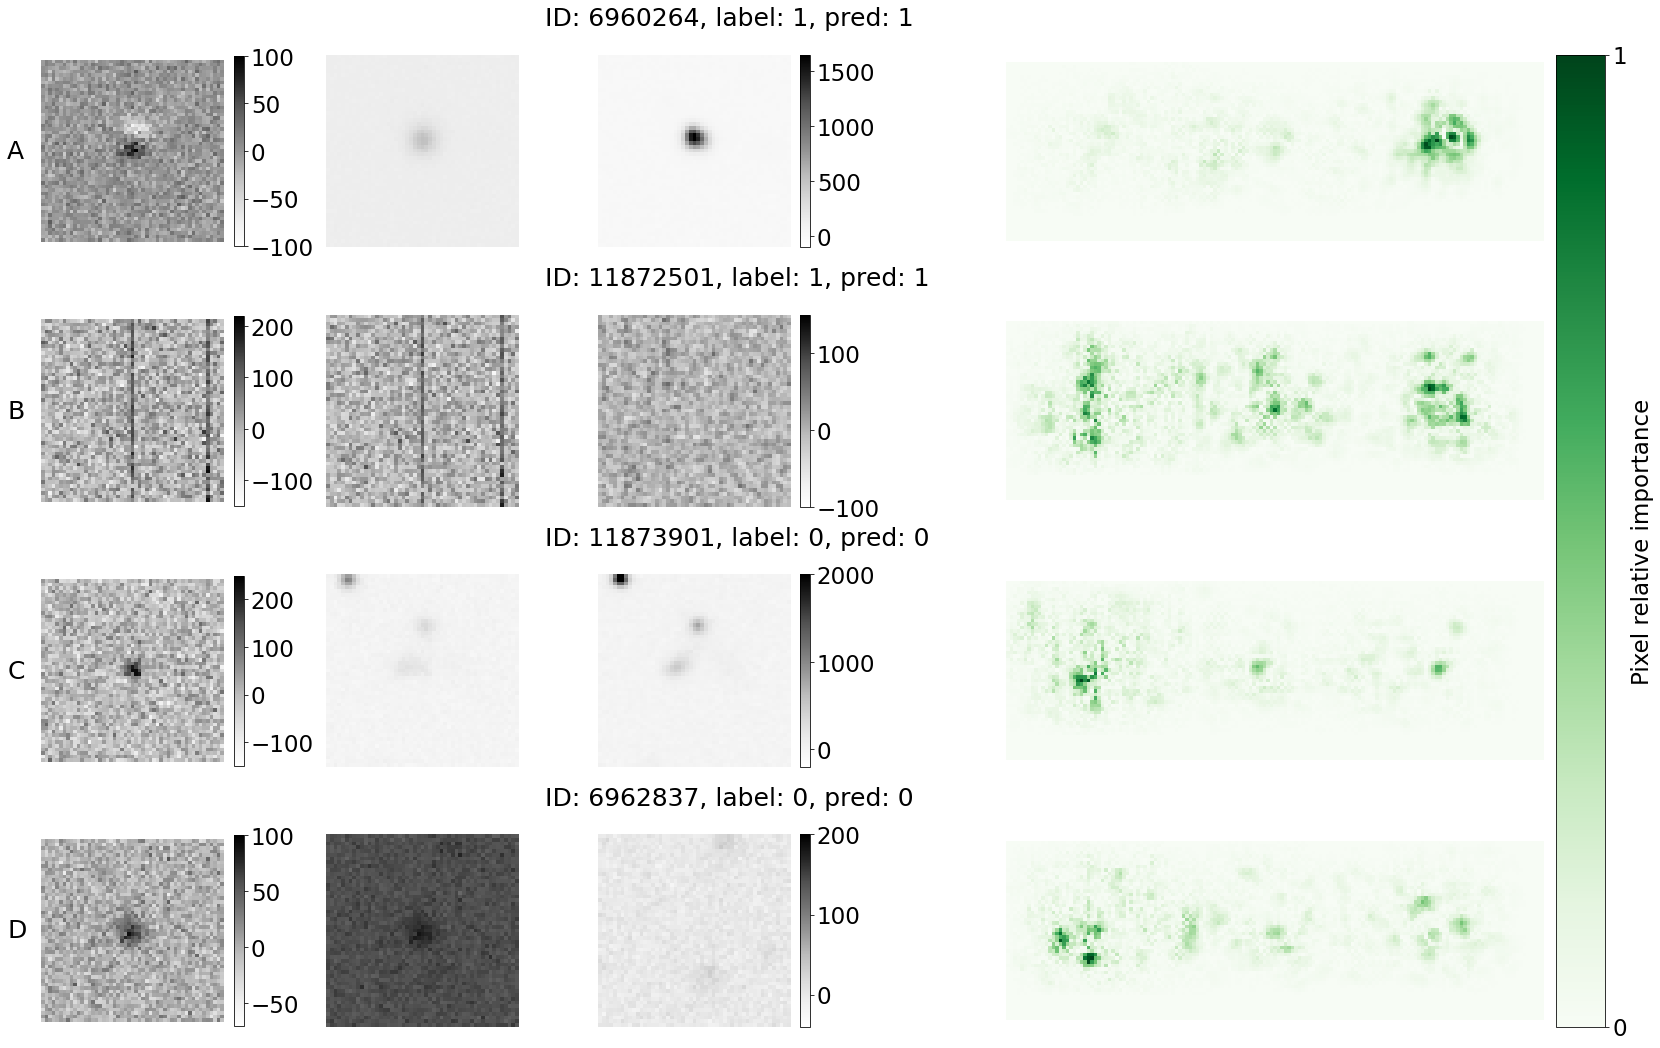

In [179]:
fig, ax = plt.subplots(4, 7,figsize=(25,15))
# fig = plt.figure(figsize=(19,23),constrained_layout=True)
# fig.subplots_adjust(0.1, 0.05, 0.95, 0.95, -0.1, 0.3)
fig.subplots_adjust(0.05, 0.05, 0.95, 0.95, 0.4, 0.35)

# gs = gridspec.GridSpec(4, 6)#,left=1,right=1.5,top=1.4,bottom=1)
np.random.seed(66)
ids = [str(6960264), str(11872501), str(11873901), str(6962837)]

ids_over = winner_concat[(winner_concat["ID"] == int(ids[0]))|(winner_concat["ID"] == int(ids[1]))|
             (winner_concat["ID"] == int(ids[2]))| (winner_concat["ID"] == int(ids[3]))]

indexes = ids_over.index
for jj,ii in enumerate(indexes): 
    index = np.where(np.char.find(flist3, ids[jj])>=0)
    
    ax[jj,4] = plt.subplot2grid((4,7), (jj,4), colspan=3)
    ax[jj,4].axis("off")
    ax[jj,4].axis("off")
    mm = ax[jj,4].imshow(dgrad_abs[ids_over[ids_over["ID"]==int(ids[jj])].index][0],cmap = "Greens",clim = (np.array(dgrad_abs[ids_over[ids_over["ID"]==int(ids[jj])].index][0]).min(),np.array(dgrad_abs[ids_over[ids_over["ID"]==int(ids[jj])].index][0]).max()))
#     ax[jj,3].contour(data_full[index[0][1]], levels=[240, 500, 1000, 1600], colors='purple', alpha=0.5)


    
    
    for ll in range(3):
        if (jj == 0) & (ll == 0):
            clims = (-100,100)
        if (jj == 0) & (ll in [1,2]):
            clims = (-100,1650)
        if (jj == 1) & (ll == 0):
            clims = (-150,220)
        if (jj == 1) & (ll in [1,2]):
            clims = (-100,150)
        if (jj == 2) & (ll == 0):
            clims = (-150,250)
        if (jj == 2) & (ll in [1,2]):
            clims = (-200,2000)
        if (jj == 3) & (ll == 0):
            clims = (-70,100)
        if (jj == 3) & (ll in [1,2]):
            clims = (-40,200)
        ax[jj,ll] = plt.subplot2grid((4,6), (jj,ll), colspan=1)
        ax[jj,ll].axis("off")
        cmst0 = ax[jj,ll].imshow(data_full[index[0][ll]],cmap = "Greys", clim = (clims[0],clims[1]))

        if ll == 0:
            colorbar_diff = fig.colorbar(cmst0, ax = ax[jj, 0], fraction=0.047)
            colorbar_diff.ax.tick_params(labelsize=23)
        if ll == 2:
            colorbar_srch = fig.colorbar(cmst0, ax = ax[jj, 1:3], fraction=0.022, pad=0.02)
            colorbar_srch.ax.tick_params(labelsize=23)
    
# plt.tight_layout()
    
right_index = [17001, 4999, 10403, 15881]
for jj,ii in enumerate(right_index):
#     print(jj, ii)
    ax[jj, 0].axis("off")
    ax[jj,0].text(140,-10, 
                "ID: {}, label: {}, pred: {} ".format(int(ids_over.loc[ii]["ID"]), 
                                                      int(ids_over.loc[ii]["OBJECT_TYPE"]), ids_over.loc[ii]["predicted"]), 
                fontsize = 25)
ax[0, 0].text(-10, 27, "A", fontsize=25)
ax[1, 0].text(-10, 27, "B", fontsize=25)
ax[2, 0].text(-10, 27, "C", fontsize=25)
ax[3, 0].text(-10, 27, "D", fontsize=25)

colorbar_sm = fig.colorbar(mm, ax = ax[0:,4], ticks = [np.array(dgrad_abs[ids_over[ids_over["ID"]==int(ids[jj])].index][0]).min(), np.array(dgrad_abs[ids_over[ids_over["ID"]==int(ids[jj])].index][0]).max()] , fraction=0.16, pad=0.02)
colorbar_sm.ax.set_ylabel("Pixel relative importance", fontsize=23)
colorbar_sm.ax.set_yticklabels(['0','1'])
colorbar_sm.ax.tick_params(labelsize=23)

plt.savefig("saliency_plot.pdf",bbox_inches ="tight")

In [180]:
to_save_fig = np.zeros((8*3,3,51, 51))
to_save_label = np.zeros((8*3))
to_save_ID = np.zeros((8*3))
to_save_predic = np.zeros((8*3))
to_save_salien = np.zeros((8*3, 51, 153, 1))

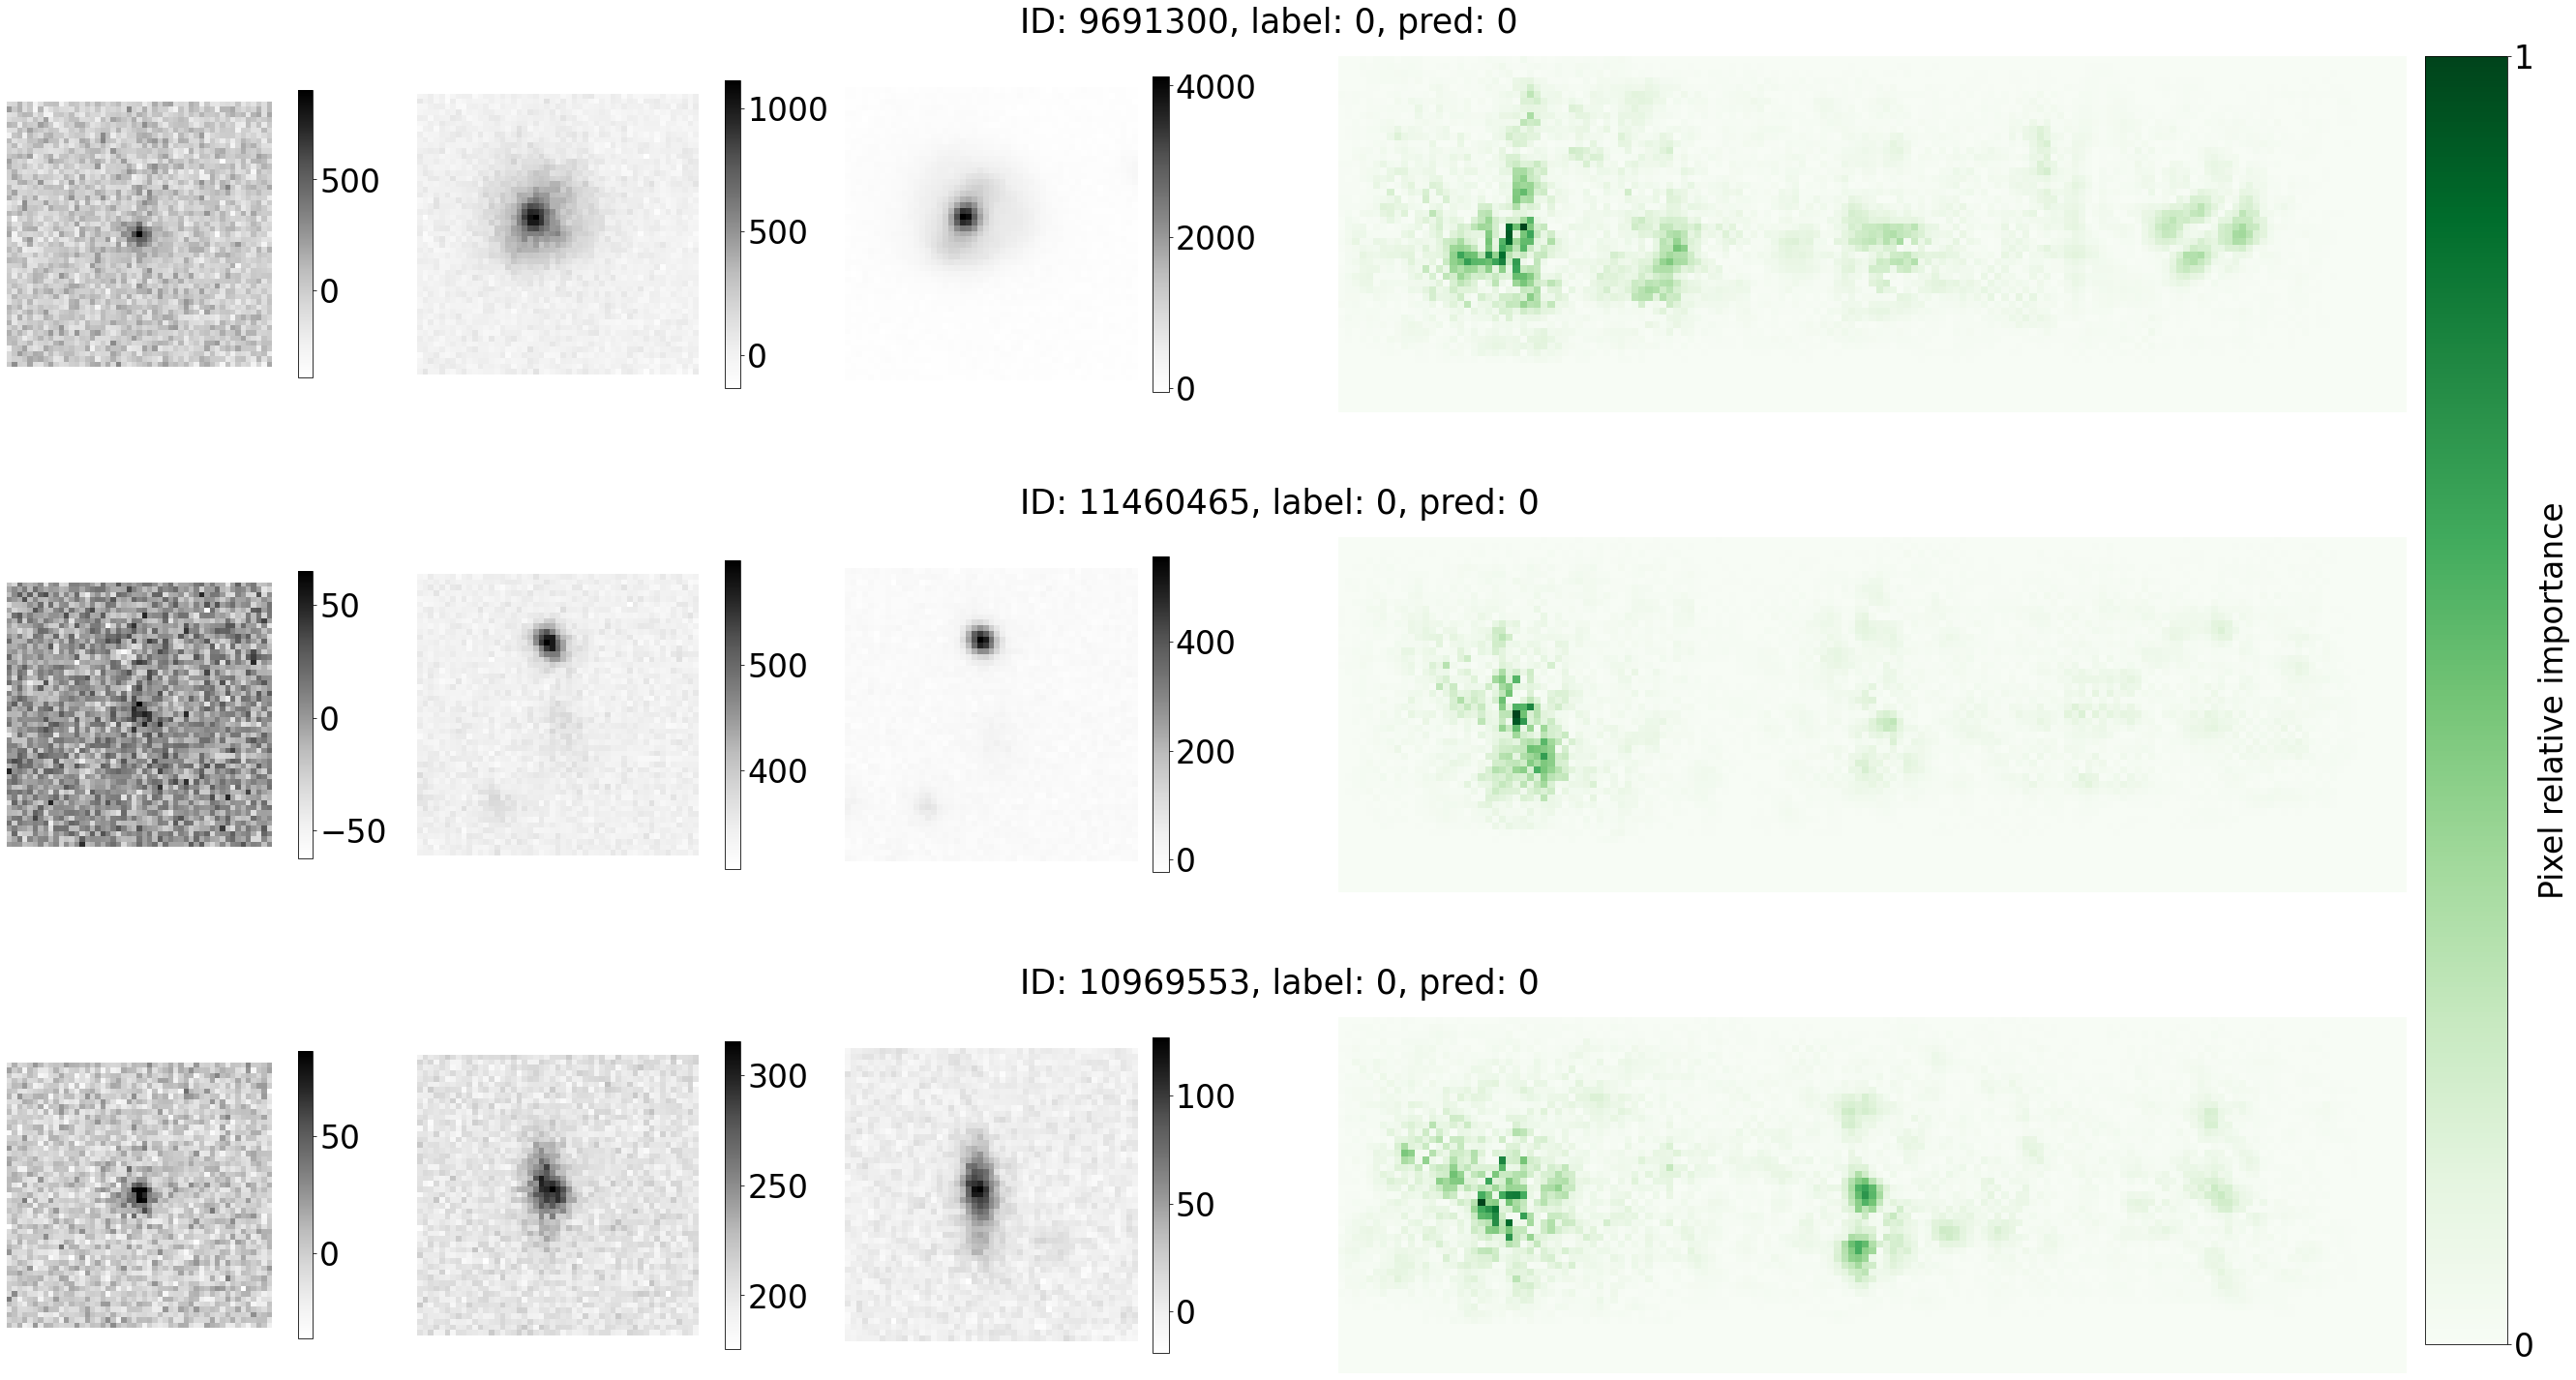

In [281]:
fig, ax = plt.subplots(3,7,figsize=(39,21))
# fig = plt.figure(figsize=(19,23),constrained_layout=True)
fig.subplots_adjust(0.05, 0.05, 0.95, 0.95, 0.4, 0.35)

ids_over = winner_concat[(winner_concat["OBJECT_TYPE"] == 0) & (winner_concat["predicted"] == 0)]
seed = 64
# seed = 109
# for seed in [64, 109]:
np.random.seed(seed)
indexes = ids_over.sample(3).index
# print(indexes)
for jj,ii in enumerate(indexes): 
#     print(jj,ii)
    index = np.where(np.char.find(flist3, str(ids_over.loc[ii]["ID"]))>=0)
    ax[jj,0] = plt.subplot2grid((3,6), (jj,0), colspan=1)
    ax[jj,0].axis("off")
    cmst0 = ax[jj,0].imshow(data_full[index[0][0]],cmap = "Greys", clim = (data_full[index[0][0]].min(),data_full[index[0][0]].max()))
    colorbar_diff = fig.colorbar(cmst0, ax = ax[jj, 0],fraction=0.047)
    colorbar_diff.ax.tick_params(labelsize=33)
    ax[jj,1] = plt.subplot2grid((3,6), (jj,1), colspan=1)
    ax[jj,1].axis("off")
    cmst1 = ax[jj,1].imshow(data_full[index[0][1]],cmap = "Greys", clim = (data_full[index[0][1]].min(),data_full[index[0][1]].max()))
    colorbar_srch = fig.colorbar(cmst1, ax = ax[jj, 0:2], fraction=0.021, pad=0.02)
    colorbar_srch.ax.tick_params(labelsize=33)
    ax[jj,2] = plt.subplot2grid((3,6), (jj,2), colspan=1)
    ax[jj,2].axis("off")
    cmst2 = ax[jj,2].imshow(data_full[index[0][2]],cmap = "Greys", clim = (data_full[index[0][2]].min(),data_full[index[0][2]].max()))
    colorbar_temp = fig.colorbar(cmst2, ax = ax[jj, 1:3], fraction=0.021, pad=0.02)
    colorbar_temp.ax.tick_params(labelsize=33)
    ax[jj,2].text(30, -10,
                "ID: {}, label: {}, pred: {} ".format(int(ids_over.loc[ii]["ID"]), 
                                                      int(ids_over.loc[ii]["OBJECT_TYPE"]), ids_over.loc[ii]["predicted"]), 
                fontsize = 35)
#         ax[jj,3].axis("off")
#     test45 = np.stack((data_full[index[0][0]], data_full[index[0][1]], data_full[index[0][2]]))
#     print(test45.shape)
    if seed == 64:
        to_save_fig[jj] = np.stack((data_full[index[0][0]], data_full[index[0][1]], data_full[index[0][2]]))
        to_save_ID[jj] = ids_over.loc[ii]["ID"]
        to_save_label[jj] = ids_over.loc[ii]["OBJECT_TYPE"]
        to_save_predic[jj] = ids_over.loc[ii]["predicted"]

    if seed == 109:
        to_save_fig[jj+3] = np.stack((data_full[index[0][0]], data_full[index[0][1]], data_full[index[0][2]]))
        to_save_ID[jj+3] = ids_over.loc[ii]["ID"]
        to_save_label[jj+3] = ids_over.loc[ii]["OBJECT_TYPE"]
        to_save_predic[jj+3] = ids_over.loc[ii]["predicted"]
#     np.save("fed_files", to_save_orig)

# gs2 = gridspec.GridSpecFromSubplotSpec(6, 1, subplot_spec=gs0[1])
for jj, ii in enumerate(indexes):
    ax = plt.subplot2grid((3,6), (jj,3), colspan=3)
    ax.axis("off")
    if seed == 64:
        to_save_salien[jj] = dgrad_abs[ids_over[ids_over["ID"]==ids_over.loc[ii]["ID"]].index[0]]
    if seed == 109:
        to_save_salien[jj+3] = dgrad_abs[ids_over[ids_over["ID"]==ids_over.loc[ii]["ID"]].index[0]]   
    mm = ax.imshow(dgrad_abs[ids_over[ids_over["ID"]==ids_over.loc[ii]["ID"]].index[0]],cmap = "Greens",clim = (np.array(dgrad_abs[ids_over[ids_over["ID"]==ids_over.loc[ii]["ID"]].index[0]]).min(),np.array(dgrad_abs[ids_over[ids_over["ID"]==ids_over.loc[ii]["ID"]].index[0]]).max()))
#     if jj == 0:
    cax = fig.add_axes([0.94, 0.07, 0.03, 0.88])
    colorbar_sm = fig.colorbar(mm, cax = cax, ticks=[np.array(dgrad_abs[ids_over[ids_over["ID"]==ids_over.loc[ii]["ID"]].index[0]]).min(), np.array(dgrad_abs[ids_over[ids_over["ID"]==ids_over.loc[ii]["ID"]].index[0]]).max()], fraction=0.016, pad=0.02)
    colorbar_sm.ax.set_ylabel("Pixel relative importance", fontsize=33)
    colorbar_sm.ax.set_yticklabels(['0','1'])
    colorbar_sm.ax.tick_params(labelsize=33)
# ax = plt.subplot2grid((3,6), (jj,3), colspan=1)

# plt.savefig("saliency_plot_other3-see{}.pdf".format(seed),bbox_inches ="tight")

In [57]:
# fig, ax = plt.subplots(2, 1)
# ax[0].imshow(to_save_fig[0][0], cmap = "Greys",) 
# ax[1].imshow(to_save_salien[0], cmap = "Greens",) 
#            #clim = (to_save_fig[1][0].min(),to_save_fig[1][0].max()))
# print(to_save_ID[0])

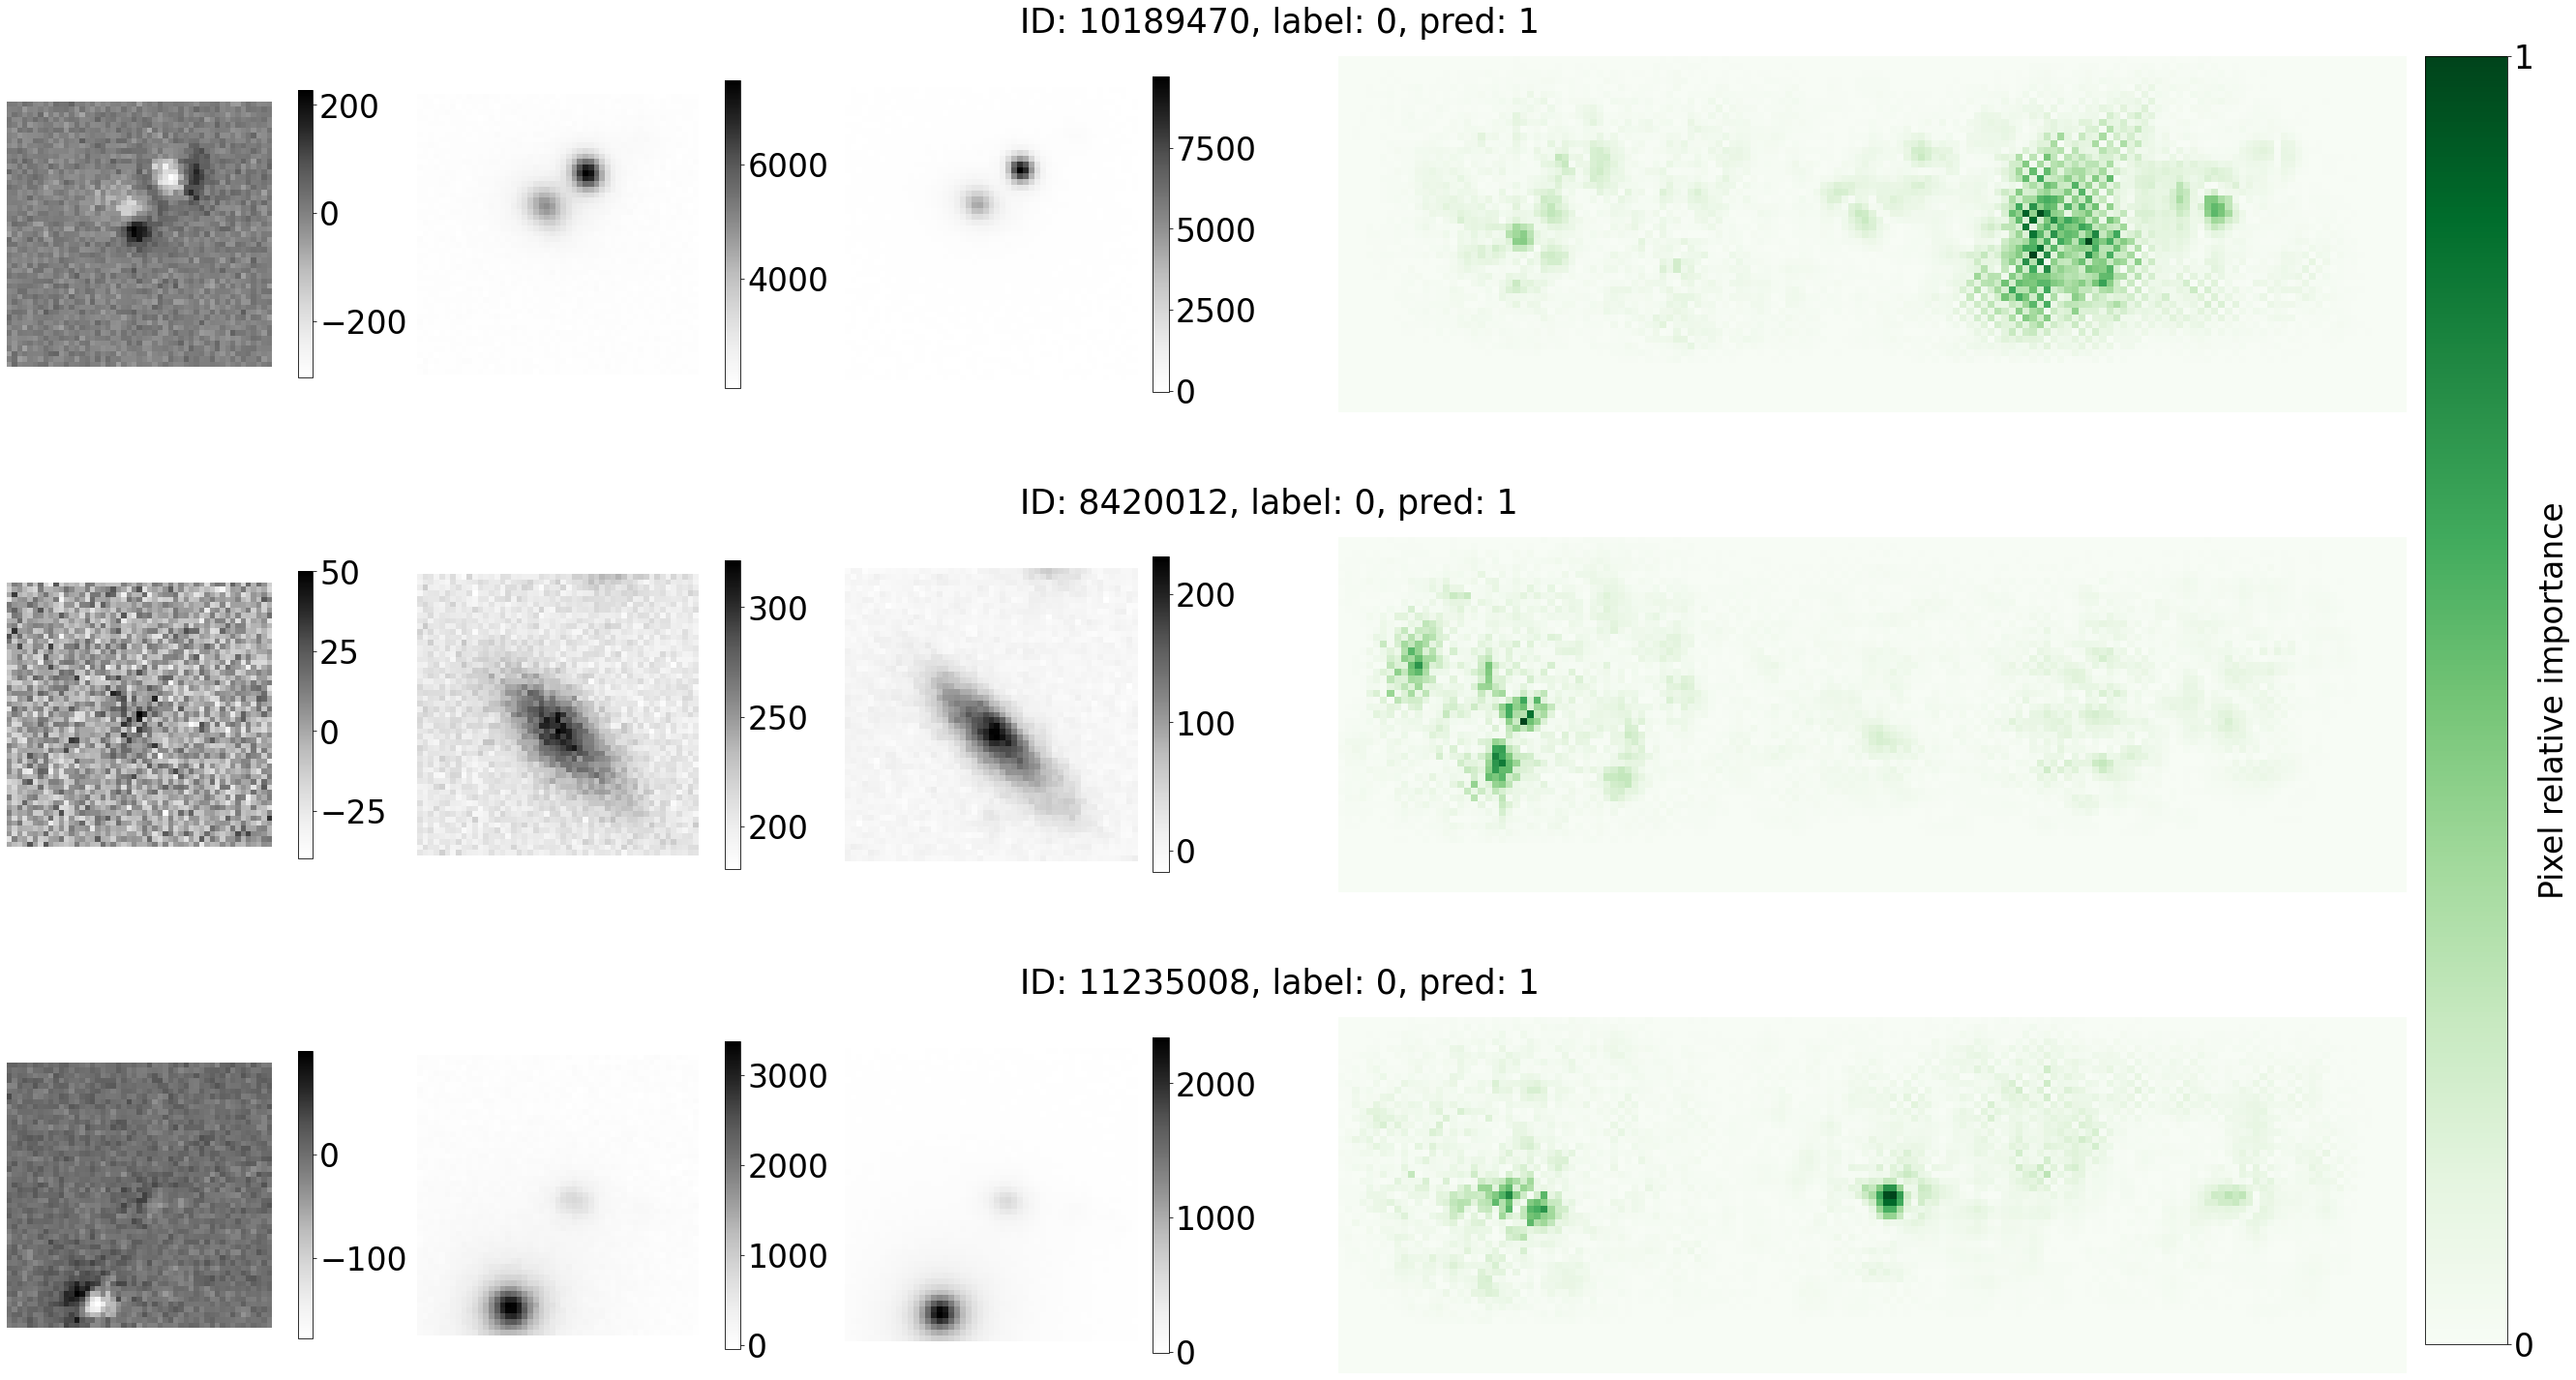

In [284]:
fig, ax = plt.subplots(3,6,figsize=(39,21))
# fig = plt.figure(figsize=(19,23),constrained_layout=True)
fig.subplots_adjust(0.05, 0.05, 0.95, 0.95, 0.4, 0.35)

ids_over = winner_concat[(winner_concat["OBJECT_TYPE"] == 0) & (winner_concat["predicted"] == 1)]
seed = 2041
# seed = 66
# for seed in [66, 2041]:
np.random.seed(seed)
indexes = ids_over.sample(3).index
# print(indexes)
for jj,ii in enumerate(indexes): 
#     print(jj,ii)
    index = np.where(np.char.find(flist3, str(ids_over.loc[ii]["ID"]))>=0)
    ax[jj,0] = plt.subplot2grid((3,6), (jj,0), colspan=1)
    ax[jj,0].axis("off")
    cmst0 = ax[jj,0].imshow(data_full[index[0][0]],cmap = "Greys", clim = (data_full[index[0][0]].min(),data_full[index[0][0]].max()))
    colorbar_diff = fig.colorbar(cmst0, ax = ax[jj, 0],fraction=0.047)
    colorbar_diff.ax.tick_params(labelsize=33)
    ax[jj,1] = plt.subplot2grid((3,6), (jj,1), colspan=1)
    ax[jj,1].axis("off")
    cmst1 = ax[jj,1].imshow(data_full[index[0][1]],cmap = "Greys", clim = (data_full[index[0][1]].min(),data_full[index[0][1]].max()))
    colorbar_srch = fig.colorbar(cmst1, ax = ax[jj, 0:2], fraction=0.021, pad=0.02)
    colorbar_srch.ax.tick_params(labelsize=33)
    ax[jj,2] = plt.subplot2grid((3,6), (jj,2), colspan=1)
    ax[jj,2].axis("off")
    cmst2 = ax[jj,2].imshow(data_full[index[0][2]],cmap = "Greys", clim = (data_full[index[0][2]].min(),data_full[index[0][2]].max()))
    colorbar_temp = fig.colorbar(cmst2, ax = ax[jj, 1:3], fraction=0.021, pad=0.02)
    colorbar_temp.ax.tick_params(labelsize=33)
    ax[jj,2].text(30, -10,
                "ID: {}, label: {}, pred: {} ".format(int(ids_over.loc[ii]["ID"]), 
                                                      int(ids_over.loc[ii]["OBJECT_TYPE"]), ids_over.loc[ii]["predicted"]), 
                fontsize = 35)
    if seed == 66:
        to_save_fig[jj+6] = np.stack((data_full[index[0][0]], data_full[index[0][1]], data_full[index[0][2]]))
        to_save_ID[jj+6] = ids_over.loc[ii]["ID"]
        to_save_label[jj+6] = ids_over.loc[ii]["OBJECT_TYPE"]
        to_save_predic[jj+6] = ids_over.loc[ii]["predicted"]

    if seed == 2041:
        to_save_fig[jj+9] = np.stack((data_full[index[0][0]], data_full[index[0][1]], data_full[index[0][2]]))
        to_save_ID[jj+9] = ids_over.loc[ii]["ID"]
        to_save_label[jj+9] = ids_over.loc[ii]["OBJECT_TYPE"]
        to_save_predic[jj+9] = ids_over.loc[ii]["predicted"]
#         ax[jj,3].axis("off")

# gs2 = gridspec.GridSpecFromSubplotSpec(6, 1, subplot_spec=gs0[1])
for jj, ii in enumerate(indexes):
    ax = plt.subplot2grid((3,6), (jj,3), colspan=3)
    ax.axis("off")
    if seed == 66:
        to_save_salien[jj+6] = dgrad_abs[ids_over[ids_over["ID"]==ids_over.loc[ii]["ID"]].index[0]]
    if seed == 2041:
        to_save_salien[jj+9] = dgrad_abs[ids_over[ids_over["ID"]==ids_over.loc[ii]["ID"]].index[0]] 
    mm = ax.imshow(dgrad_abs[ids_over[ids_over["ID"]==ids_over.loc[ii]["ID"]].index[0]],cmap = "Greens",clim = (np.array(dgrad_abs[ids_over[ids_over["ID"]==ids_over.loc[ii]["ID"]].index[0]]).min(),np.array(dgrad_abs[ids_over[ids_over["ID"]==ids_over.loc[ii]["ID"]].index[0]]).max()))
#     if jj == 1:
    cax = fig.add_axes([0.94, 0.07, 0.03, 0.88])
    colorbar_sm = fig.colorbar(mm, cax = cax, ticks=[np.array(dgrad_abs[ids_over[ids_over["ID"]==ids_over.loc[ii]["ID"]].index[0]]).min(), np.array(dgrad_abs[ids_over[ids_over["ID"]==ids_over.loc[ii]["ID"]].index[0]]).max()], fraction=0.016, pad=0.02)
    colorbar_sm.ax.set_ylabel("Pixel relative importance", fontsize=33)
    colorbar_sm.ax.set_yticklabels(['0','1'])
    colorbar_sm.ax.tick_params(labelsize=33)

# plt.savefig("saliency_plot_other3FN-see{}.pdf".format(seed),bbox_inches ="tight")

In [59]:
# fig, ax = plt.subplots(2, 1)
# ax[0].imshow(to_save_fig[8][0], cmap = "Greys",) 
# ax[1].imshow(to_save_salien[8], cmap = "Greens",) 
#            #clim = (to_save_fig[1][0].min(),to_save_fig[1][0].max()))
# print(to_save_ID[8])

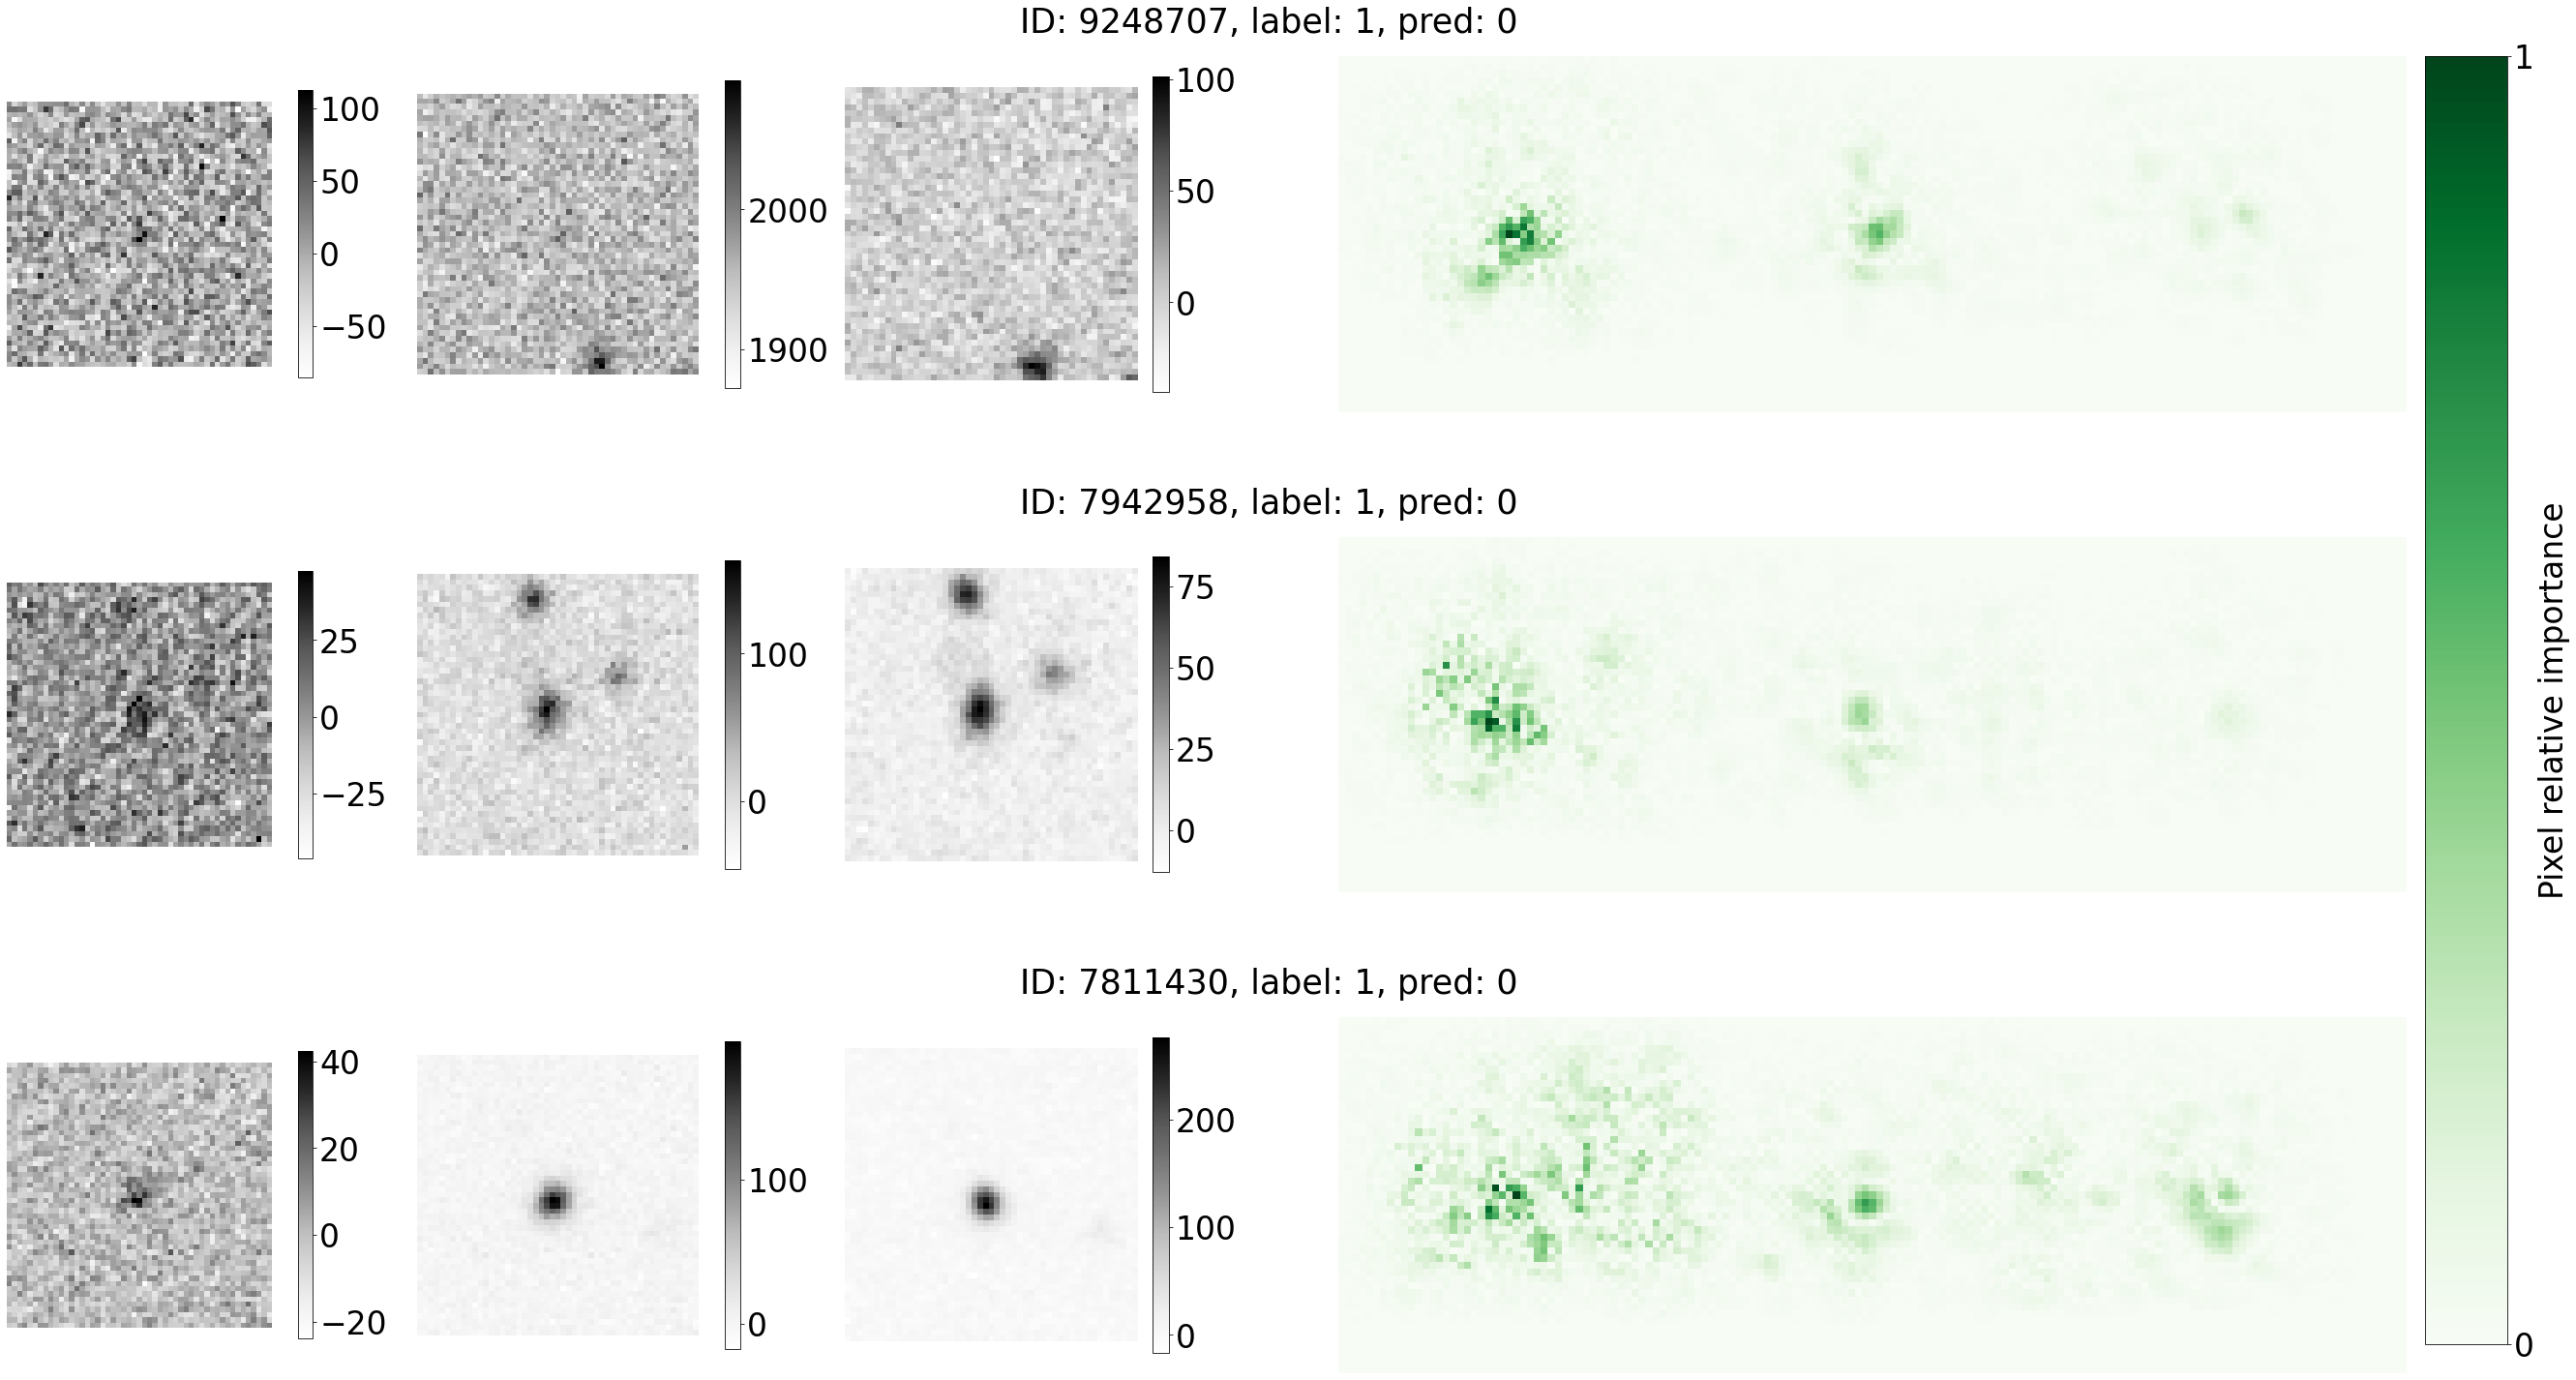

In [287]:
fig, ax = plt.subplots(3,6,figsize=(39,21))
# fig = plt.figure(figsize=(19,23),constrained_layout=True)
fig.subplots_adjust(0.05, 0.05, 0.95, 0.95, 0.4, 0.35)

ids_over = winner_concat[(winner_concat["OBJECT_TYPE"] == 1) & (winner_concat["predicted"] == 0)]
seed = 21
# seed = 369
# for seed in [21, 369]:
np.random.seed(seed)
indexes = ids_over.sample(3).index
# print(indexes)
for jj,ii in enumerate(indexes): 
#     print(jj,ii)
    index = np.where(np.char.find(flist3, str(ids_over.loc[ii]["ID"]))>=0)
    ax[jj,0] = plt.subplot2grid((3,6), (jj,0), colspan=1)
    ax[jj,0].axis("off")
    cmst0 = ax[jj,0].imshow(data_full[index[0][0]],cmap = "Greys", clim = (data_full[index[0][0]].min(),data_full[index[0][0]].max()))
    colorbar_diff = fig.colorbar(cmst0, ax = ax[jj, 0],fraction=0.047)
    colorbar_diff.ax.tick_params(labelsize=33)
    ax[jj,1] = plt.subplot2grid((3,6), (jj,1), colspan=1)
    ax[jj,1].axis("off")
    cmst1 = ax[jj,1].imshow(data_full[index[0][1]],cmap = "Greys", clim = (data_full[index[0][1]].min(),data_full[index[0][1]].max()))
    colorbar_srch = fig.colorbar(cmst1, ax = ax[jj, 0:2], fraction=0.021, pad=0.02)
    colorbar_srch.ax.tick_params(labelsize=33)
    ax[jj,2] = plt.subplot2grid((3,6), (jj,2), colspan=1)
    ax[jj,2].axis("off")
    cmst2 = ax[jj,2].imshow(data_full[index[0][2]],cmap = "Greys", clim = (data_full[index[0][2]].min(),data_full[index[0][2]].max()))
    colorbar_temp = fig.colorbar(cmst2, ax = ax[jj, 1:3], fraction=0.021, pad=0.02)
    colorbar_temp.ax.tick_params(labelsize=33)
    ax[jj,2].text(30, -10,
                "ID: {}, label: {}, pred: {} ".format(int(ids_over.loc[ii]["ID"]), 
                                                      int(ids_over.loc[ii]["OBJECT_TYPE"]), ids_over.loc[ii]["predicted"]), 
                fontsize = 35)
    if seed == 21:
        to_save_fig[jj+12] = np.stack((data_full[index[0][0]], data_full[index[0][1]], data_full[index[0][2]]))
        to_save_ID[jj+12] = ids_over.loc[ii]["ID"]
        to_save_label[jj+12] = ids_over.loc[ii]["OBJECT_TYPE"]
        to_save_predic[jj+12] = ids_over.loc[ii]["predicted"]

    if seed == 369:
        to_save_fig[jj+15] = np.stack((data_full[index[0][0]], data_full[index[0][1]], data_full[index[0][2]]))
        to_save_ID[jj+15] = ids_over.loc[ii]["ID"]
        to_save_label[jj+15] = ids_over.loc[ii]["OBJECT_TYPE"]
        to_save_predic[jj+15] = ids_over.loc[ii]["predicted"]
#         ax[jj,3].axis("off")

# gs2 = gridspec.GridSpecFromSubplotSpec(6, 1, subplot_spec=gs0[1])
for jj, ii in enumerate(indexes):
    ax = plt.subplot2grid((3,6), (jj,3), colspan=3)
    ax.axis("off")
    if seed == 21:
        to_save_salien[jj+12] = dgrad_abs[ids_over[ids_over["ID"]==ids_over.loc[ii]["ID"]].index[0]]
    if seed == 369:
        to_save_salien[jj+15] = dgrad_abs[ids_over[ids_over["ID"]==ids_over.loc[ii]["ID"]].index[0]]
    mm = ax.imshow(dgrad_abs[ids_over[ids_over["ID"]==ids_over.loc[ii]["ID"]].index[0]],cmap = "Greens",clim = (np.array(dgrad_abs[ids_over[ids_over["ID"]==ids_over.loc[ii]["ID"]].index[0]]).min(),np.array(dgrad_abs[ids_over[ids_over["ID"]==ids_over.loc[ii]["ID"]].index[0]]).max()))
#     fig.colorbar(mm, ax = ax, ticks=[np.array(dgrad_abs[ids_over[ids_over["ID"]==ids_over.loc[ii]["ID"]].index[0]]).min(), np.array(dgrad_abs[ids_over[ids_over["ID"]==ids_over.loc[ii]["ID"]].index[0]]).max()], fraction=0.016, pad=0.02)
#     if jj == 1:
    cax = fig.add_axes([0.94, 0.07, 0.03, 0.88])
    colorbar_sm = fig.colorbar(mm, cax = cax, ticks=[np.array(dgrad_abs[ids_over[ids_over["ID"]==ids_over.loc[ii]["ID"]].index[0]]).min(), np.array(dgrad_abs[ids_over[ids_over["ID"]==ids_over.loc[ii]["ID"]].index[0]]).max()], fraction=0.016, pad=0.02)
    colorbar_sm.ax.set_ylabel("Pixel relative importance", fontsize=33)
    colorbar_sm.ax.set_yticklabels(['0','1'])
    colorbar_sm.ax.tick_params(labelsize=33)
#     fig.add_axes([0.78, 0.07, 0.03, 0.88])

plt.savefig("saliency_plot_other3FP-see{}.pdf".format(seed),bbox_inches ="tight")

In [61]:
# fig, ax = plt.subplots(2, 1)
# ax[0].imshow(to_save_fig[14][0], cmap = "Greys",) 
# ax[1].imshow(to_save_salien[14], cmap = "Greens",) 
#            #clim = (to_save_fig[1][0].min(),to_save_fig[1][0].max()))
# print(to_save_ID[14], to_save_label[15], to_save_predic[15])

In [62]:
# fig, ax = plt.subplots(3,7,figsize=(39,21))
# # fig = plt.figure(figsize=(19,23),constrained_layout=True)
# fig.subplots_adjust(0.05, 0.05, 0.95, 0.95, 0.4, 0.35)

# ids_over = winner_concat[(winner_concat["OBJECT_TYPE"] == 1) & (winner_concat["predicted"] == 1)]
# # seed = 446
# for seed in [36, 446]:
#     np.random.seed(seed)
#     indexes = ids_over.sample(3).index
#     # print(indexes)
#     for jj,ii in enumerate(indexes): 
#     #     print(jj,ii)
#         index = np.where(np.char.find(flist3, str(ids_over.loc[ii]["ID"]))>=0)
# #         ax[jj,0] = plt.subplot2grid((3,6), (jj,0), colspan=1)
# #         ax[jj,0].axis("off")
# #         cmst0 = ax[jj,0].imshow(data_full[index[0][0]],cmap = "Greys", clim = (data_full[index[0][0]].min(),data_full[index[0][0]].max()))
# #         colorbar_diff = fig.colorbar(cmst0, ax = ax[jj, 0],fraction=0.047)
# #         colorbar_diff.ax.tick_params(labelsize=33)
# #         ax[jj,1] = plt.subplot2grid((3,6), (jj,1), colspan=1)
# #         ax[jj,1].axis("off")
# #         cmst1 = ax[jj,1].imshow(data_full[index[0][1]],cmap = "Greys", clim = (data_full[index[0][1]].min(),data_full[index[0][1]].max()))
# #         colorbar_srch = fig.colorbar(cmst1, ax = ax[jj, 0:2], fraction=0.021, pad=0.02)
# #         colorbar_srch.ax.tick_params(labelsize=33)
# #         ax[jj,2] = plt.subplot2grid((3,6), (jj,2), colspan=1)
# #         ax[jj,2].axis("off")
# #         cmst2 = ax[jj,2].imshow(data_full[index[0][2]],cmap = "Greys", clim = (data_full[index[0][2]].min(),data_full[index[0][2]].max()))
# #         colorbar_temp = fig.colorbar(cmst2, ax = ax[jj, 1:3], fraction=0.021, pad=0.02)
# #         colorbar_temp.ax.tick_params(labelsize=33)
# #         ax[jj,2].text(30, -10,
# #                     "ID: {}, label: {}, pred: {} ".format(int(ids_over.loc[ii]["ID"]), 
# #                                                           int(ids_over.loc[ii]["OBJECT_TYPE"]), ids_over.loc[ii]["predicted"]), 
# #                     fontsize = 35)
# #         ax[jj,3].axis("off")
#     #     test45 = np.stack((data_full[index[0][0]], data_full[index[0][1]], data_full[index[0][2]]))
#     #     print(test45.shape)
#         if seed == 36:
#             to_save_fig[jj+18] = np.stack((data_full[index[0][0]], data_full[index[0][1]], data_full[index[0][2]]))
#             to_save_ID[jj+18] = ids_over.loc[ii]["ID"]
#             to_save_label[jj+18] = ids_over.loc[ii]["OBJECT_TYPE"]
#             to_save_predic[jj+18] = ids_over.loc[ii]["predicted"]

#         if seed == 446:
#             to_save_fig[jj+21] = np.stack((data_full[index[0][0]], data_full[index[0][1]], data_full[index[0][2]]))
#             to_save_ID[jj+21] = ids_over.loc[ii]["ID"]
#             to_save_label[jj+21] = ids_over.loc[ii]["OBJECT_TYPE"]
#             to_save_predic[jj+21] = ids_over.loc[ii]["predicted"]
#     #     np.save("fed_files", to_save_orig)

#     # gs2 = gridspec.GridSpecFromSubplotSpec(6, 1, subplot_spec=gs0[1])
#     for jj, ii in enumerate(indexes):
#         ax = plt.subplot2grid((3,6), (jj,3), colspan=3)
#         ax.axis("off")
#         if seed == 36:
#             to_save_salien[jj+18] = dgrad_abs[ids_over[ids_over["ID"]==ids_over.loc[ii]["ID"]].index[0]]
#         if seed == 446:
#             to_save_salien[jj+21] = dgrad_abs[ids_over[ids_over["ID"]==ids_over.loc[ii]["ID"]].index[0]]   
#         mm = ax.imshow(dgrad_abs[ids_over[ids_over["ID"]==ids_over.loc[ii]["ID"]].index[0]],cmap = "Greens",clim = (np.array(dgrad_abs[ids_over[ids_over["ID"]==ids_over.loc[ii]["ID"]].index[0]]).min(),np.array(dgrad_abs[ids_over[ids_over["ID"]==ids_over.loc[ii]["ID"]].index[0]]).max()))
#     #     if jj == 0:
#         cax = fig.add_axes([0.94, 0.07, 0.03, 0.88])
#         colorbar_sm = fig.colorbar(mm, cax = cax, ticks=[np.array(dgrad_abs[ids_over[ids_over["ID"]==ids_over.loc[ii]["ID"]].index[0]]).min(), np.array(dgrad_abs[ids_over[ids_over["ID"]==ids_over.loc[ii]["ID"]].index[0]]).max()], fraction=0.016, pad=0.02)
#         colorbar_sm.ax.set_ylabel("Saliency pixel\nvalue Importance", fontsize=33)
#         colorbar_sm.ax.set_yticklabels(['min','max'])
#         colorbar_sm.ax.tick_params(labelsize=33)
#     # ax = plt.subplot2grid((3,6), (jj,3), colspan=1)

#     # plt.savefig("saliency_plot_other3-see36TN.pdf",bbox_inches ="tight")

In [63]:
# to_save_fig.shape, to_save_ID.shape

In [64]:
# np.save("fed_fig3d", to_save_fig)
# np.save("fed_ID3d", to_save_ID)
# np.save("fed_label3d", to_save_label)
# np.save("fed_pred3d", to_save_predic)
# np.save("fed_salien3d", to_save_salien)

In [65]:
# fig = plt.figure(figsize=(19,23), constrained_layout=True)
# gs0 = gridspec.GridSpec(1, 2, figure=fig)

# gs1 = gridspec.GridSpecFromSubplotSpec(8, 3, subplot_spec=gs0[0])
# indexes = diff_winner.index[17:25]
# for jj, ii in enumerate(indexes):
#     index = np.where(np.char.find(flist3, str(vertical_concat["ID"].to_numpy()[ii]))>=0)
#     ax[jj,0] = plt.subplot(gs1[jj,0])
#     ax[jj,0].imshow(data_full[index[0][0]],cmap = "Greys", clim = (data_full[index[0][0]].min(),data_full[index[0][0]].max()))
# #     fig.colorbar(cmst0, ax = ax[jj, 0],fraction=0.047)
#     ax[jj,1] = plt.subplot(gs1[jj, 1])
#     ax[jj,1].imshow(data_full[index[0][1]],cmap = "Greys", clim = (data_full[index[0][1]].min(),data_full[index[0][1]].max()))
#     ax[jj,2] = plt.subplot(gs1[jj, 2])
#     ax[jj,2].imshow(data_full[index[0][2]],cmap = "Greys", clim = (data_full[index[0][2]].min(),data_full[index[0][2]].max()))
#     ax[jj,1].set_title(
#                     "ID: {}, label: {}, pred: {} ".format(int(test_ID[ii]), 
#                                                           int(test_targ[ii]), df_te["predicted"][ii]), 
#                     fontsize = 12)


# gs2 = gridspec.GridSpecFromSubplotSpec(8, 1, subplot_spec=gs0[1])
# for jj, ii in enumerate(indexes):
#     ax = plt.subplot(gs2[jj])
#     mm = ax.imshow(dgrad_abs[ii],cmap = "PRGn",clim = (-np.array(dgrad_abs[ii]).max(),np.array(dgrad_abs[ii]).max()))

# fig.colorbar(cmst0, ax = ax[jj, 0],fraction=0.047)

# fig.colorbar(mm, ax = ax,fraction=0.047)


In [125]:
df_tr = pd.DataFrame()
df_te = pd.DataFrame()

train, test, train_targ, test_targ, train_ID, test_ID,df_te_2DH,y_pred_test_2DH,loaded_model_2DH = datas(df_tr, df_te, "CCC_3s2DH")

CCC_3s2DH
../data/data_split_3s/
Done with 0
Done with 1
Done with 2
Done with 3
Done with 4
Done with 5
Done with 6
Done with 7
Done with 8
Done with 9
(10, 51, 102) (20000, 51, 102)
CCC_3s2DH
Training accuracy : 0.8000
Testing accuracy  : 0.9155


In [126]:
feat_te2_2DH = test.reshape(len(test), 51, 102, 1)

In [127]:
def saliency_map_2DH(j):
    images = tf.convert_to_tensor(feat_te2_2DH[2000*j:(j*2000)+2000], dtype=tf.float32)

    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(images)

    #     pred = y_pred_test
        pred = loaded_model_2DH(images, training=False)
        max_outp = tf.reduce_max(pred, 1)
    #     loss = np.argmax(y_pred_test,axis=1)

    #     class_idxs_sorted = np.argsort(pred.flatten())[::-1]
    #     loss = pred.flatten()[class_idxs_sorted]
    # loss1 = tf.convert_to_tensor(loss, dtype=tf.float32)
    grads = tape.gradient(max_outp, images)
    print(grads.shape)
    dgrad_abs = tf.math.abs(grads)

    return dgrad_abs

In [128]:
def add_means_2DH(j,dgrad_abs):    
    srchmena = np.mean(dgrad_abs[:, :, :51,:], axis=(1,2))
    tempmena = np.mean(dgrad_abs[:, :, 51:,:], axis=(1,2))
    df_te1_2DH = df_te_2DH[2000*j:(j*2000)+2000].copy()

    df_te1_2DH["srch"] = srchmena
    df_te1_2DH["temp"] = tempmena
    
    return df_te1_2DH

In [129]:
df_te0_2DH = add_means_2DH(0,saliency_map_2DH(0))
df_te1_2DH = add_means_2DH(1,saliency_map_2DH(1))
df_te2_2DH = add_means_2DH(2,saliency_map_2DH(2))
df_te3_2DH = add_means_2DH(3,saliency_map_2DH(3))
df_te4_2DH = add_means_2DH(4,saliency_map_2DH(4))
df_te5_2DH = add_means_2DH(5,saliency_map_2DH(5))
df_te6_2DH = add_means_2DH(6,saliency_map_2DH(6))
df_te7_2DH = add_means_2DH(7,saliency_map_2DH(7))
df_te8_2DH = add_means_2DH(8,saliency_map_2DH(8))
df_te9_2DH = add_means_2DH(9,saliency_map_2DH(9))

(2000, 51, 102, 1)
(2000, 51, 102, 1)
(2000, 51, 102, 1)
(2000, 51, 102, 1)
(2000, 51, 102, 1)
(2000, 51, 102, 1)
(2000, 51, 102, 1)
(2000, 51, 102, 1)
(2000, 51, 102, 1)
(2000, 51, 102, 1)


In [130]:
vertical_concat_2DH = pd.concat([df_te0_2DH, df_te1_2DH, df_te2_2DH, df_te3_2DH, df_te4_2DH, 
                                 df_te5_2DH, df_te6_2DH, df_te7_2DH, df_te8_2DH, df_te9_2DH], axis=0)


In [131]:
srch_winner_2DH = vertical_concat_2DH[(vertical_concat_2DH["srch"]>vertical_concat_2DH["temp"])]
srch_winner_2DH["winner"] = ["srch"]*len(srch_winner_2DH)
temp_winner_2DH = vertical_concat_2DH[(vertical_concat_2DH["temp"]>vertical_concat_2DH["srch"])]
temp_winner_2DH["winner"] = ["temp"]*len(temp_winner_2DH)

/global/homes/t/taceroc/.conda/envs/tff1/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/global/homes/t/taceroc/.conda/envs/tff1/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [132]:
winner_concat_2DH = pd.concat([srch_winner_2DH, temp_winner_2DH], axis=0)

In [133]:
con_matG = tf.math.confusion_matrix(labels=winner_concat_2DH["OBJECT_TYPE"], predictions=winner_concat_2DH["predicted"]).numpy()
con_matG.flatten()
con_mat_normG = np.around(con_matG.astype('float') / con_matG.sum(axis=1)[:, np.newaxis], decimals=2)
con_mat_dfG = pd.DataFrame(con_mat_normG,
                 index = [0,1], 
                 columns = [0,1])
con_matG,con_mat_dfG

(array([[9163,  915],
        [ 775, 9147]], dtype=int32),
       0     1
 0  0.91  0.09
 1  0.08  0.92)

In [134]:
con_matsrch = tf.math.confusion_matrix(labels=srch_winner_2DH["OBJECT_TYPE"], predictions=srch_winner_2DH["predicted"]).numpy()
con_matsrch.flatten()
con_mat_normsrch = np.around(con_matsrch.astype('float') / con_matG, decimals=2)
con_matsrch,con_mat_normsrch

(array([[2897,  223],
        [ 264, 2197]], dtype=int32),
 array([[0.32, 0.24],
        [0.34, 0.24]]))

In [135]:
con_mattemp = tf.math.confusion_matrix(labels=temp_winner_2DH["OBJECT_TYPE"], predictions=temp_winner_2DH["predicted"]).numpy()
con_mattemp.flatten()
con_mat_normtemp = np.around(con_mattemp.astype('float') / con_matG, decimals=2)
con_mattemp,con_mat_normtemp

(array([[6266,  692],
        [ 511, 6950]], dtype=int32),
 array([[0.68, 0.76],
        [0.66, 0.76]]))

In [192]:
# testt

# Confusion Matrix

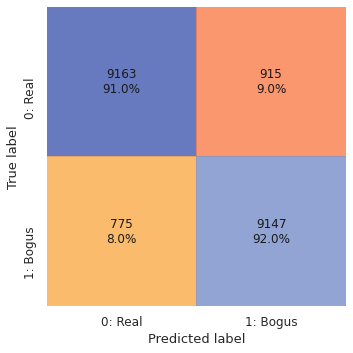

In [152]:
# make a color map of fixed colors
# cmap = colors.ListedColormap(['#eed9e2','#FF9AC8','#6eb8e4', '#04c1b1'])

# cmap = colors.ListedColormap(['#CAB8FF','#B5DEFF','#FCFFA6', '#C1FFD7'])

cooll = ['#ffb04b','#ff834d','#7b93cc','#465eb4']
# FNcolor = cooll[1]
# TPcolor = cooll[3]
# TNcolor = cooll[2]
# FPcolor = cooll[0]
alp = 0.8
# cmap = colors.ListedColormap(['#FCFFA6','#C1FFD7', '#CAB8FF','#B5DEFF'])

cmap = colors.ListedColormap(cooll)


# alp = 1

# cooll = ['#CAB8FF','#B5DEFF','#FCFFA6', '#C1FFD7']
# FNcolor = cooll[1]
# TPcolor = cooll[3]
# TNcolor = cooll[2]
# FPcolor = cooll[0]


bounds=[1,2,3,4]#0493b1#f66ca5
norm = colors.BoundaryNorm(bounds, cmap.N)


# labels = [f"srch:{v5} ({v6*100:.1f}%)\ntemp:{v7} ({v8*100:.1f}%)" for v5, v6, v7, v8 in
#       zip(con_matsrch.flatten(), 
#           con_mat_normsrch.flatten(),con_mattemp.flatten(), con_mat_normtemp.flatten())]

labels = [f"{v1}\n{v2*100}%" for v1, v2 in
      zip(con_matG.flatten(),con_mat_normG.flatten())]

labels = np.asarray(labels).reshape(2,2)
categories = ["0: Real", "1: Bogus"]

figure = plt.figure(figsize=(5, 5))
ax = sns.heatmap(testt, annot=labels, annot_kws = {"color":"k", "fontsize":12},
            cbar=False,fmt='',xticklabels=categories,yticklabels=categories,
            cmap=cmap, alpha = alp, vmin = 1, vmax=4)#plt.cm.Blues)
# sns.set(font_scale=1.4)
plt.tight_layout()
ax.set_xticklabels(ax.get_xticklabels(), size = 12)
ax.set_yticklabels(ax.get_yticklabels(), size = 12)

plt.ylabel('True label', fontsize = 13)
plt.xlabel('Predicted label', fontsize = 13)
# plt.savefig("confusionmatrix_saliencynoDIA_poster.pdf",bbox_inches="tight")

plt.savefig("confusionmatrix_model_more_dataCCC_3s2DH_newcolors.pdf",bbox_inches="tight")
plt.show()

In [68]:
# !pip3 install squarify

/global/homes/t/taceroc/.conda/envs/tff1/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  


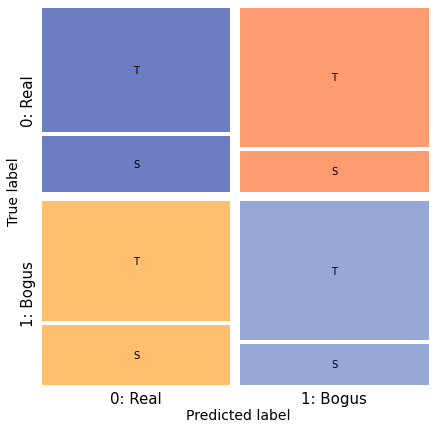

In [250]:
fig, ax = plt.subplots(2,2, figsize = (7,7),constrained_layout=True)
fig.subplots_adjust(None, None, None, None, 0.03, 0.03)
sizes=[32, 68]
label=["S", "T"]
ax[0,0] = squarify.plot(sizes=sizes, label=label, alpha=alp,color='#465eb4', pad=True,ax=ax[0,0])
ax[0,0].set_ylabel("0: Real" ,fontsize = 15)
ax[0,0].set_xticks([]) 
ax[0,0].set_yticks([])
ax[0,0].set_frame_on(False)


sizes=[24, 76]
ax[0,1] = squarify.plot(sizes=sizes, label=label, alpha=alp,color='#ff834d', pad=True,ax=ax[0,1])
ax[0,1].axis("off")

sizes=[34, 66]
ax[1,0] = squarify.plot(sizes=sizes, label=label, alpha=alp,color='#ffb04b', pad=True,ax=ax[1,0])
ax[1,0].set_xlabel("0: Real" ,fontsize = 15)
ax[1,0].set_xticks([]) 
ax[1,0].set_yticks([])
ax[1,0].set_frame_on(False)

ax[1,0].set_ylabel("1: Bogus" ,fontsize = 15)
ax[1,0].set_xticks([]) 
ax[1,0].set_yticks([])
ax[1,0].set_frame_on(False)

sizes=[24,76]
ax[1,1] = squarify.plot(sizes=sizes, label=label, alpha=alp,color='#7b93cc', pad=True,ax=ax[1,1])
ax[1,1].set_xlabel("1: Bogus" ,fontsize = 15)
ax[1,1].set_xticks([]) 
ax[1,1].set_yticks([])
ax[1,1].set_frame_on(False)
plt.text(-27,-17,'Predicted label', fontsize = 14)
plt.text(-120,88,'True label', rotation=90, fontsize = 14)
plt.savefig("confusionmatrix_saliencynoDIA_new.pdf",bbox_inches="tight")

# plt.test('Predicted label')
# plt.show()

In [195]:
dgrad_abs0_2DH = saliency_map_2DH(0)
dgrad_abs1_2DH = saliency_map_2DH(1)
dgrad_abs2_2DH = saliency_map_2DH(2)
dgrad_abs3_2DH = saliency_map_2DH(3)
dgrad_abs4_2DH = saliency_map_2DH(4)
dgrad_abs5_2DH = saliency_map_2DH(5)
dgrad_abs6_2DH = saliency_map_2DH(6)
dgrad_abs7_2DH = saliency_map_2DH(7)
dgrad_abs8_2DH = saliency_map_2DH(8)
dgrad_abs9_2DH = saliency_map_2DH(9)

(2000, 51, 102, 1)
(2000, 51, 102, 1)
(2000, 51, 102, 1)
(2000, 51, 102, 1)
(2000, 51, 102, 1)
(2000, 51, 102, 1)
(2000, 51, 102, 1)
(2000, 51, 102, 1)
(2000, 51, 102, 1)
(2000, 51, 102, 1)


In [196]:
dgrad_abs_2DH = np.concatenate((dgrad_abs0_2DH, dgrad_abs1_2DH, dgrad_abs2_2DH, dgrad_abs3_2DH, 
                dgrad_abs4_2DH, dgrad_abs5_2DH, dgrad_abs6_2DH, dgrad_abs7_2DH, 
                dgrad_abs8_2DH, dgrad_abs9_2DH))
# np.save("sm_2DH",dgrad_abs_2DH)
dgrad_abs_2DH.shape

(20000, 51, 102, 1)

In [197]:
def add_gregsmetric2DH(j,dgrad_abs):    
#     diffmena = np.sum(dgrad_abs[:, :, :51,:], axis=(1,2)) /np.sum(dgrad_abs[:,:,:,:], axis = (1,2))
    srchmena = np.sum(dgrad_abs[:, :, :51,:], axis=(1,2))/np.sum(dgrad_abs[:,:,:,:], axis = (1,2))
    tempmena = np.sum(dgrad_abs[:, :, 51:,:], axis=(1,2))/np.sum(dgrad_abs[:,:,:,:], axis = (1,2))
    df_te1_2DH = df_te_2DH[2000*j:(j*2000)+2000].copy()

#     df_te1["diff_gm"] = diffmena
    df_te1_2DH["srch_gm"] = srchmena
    df_te1_2DH["temp_gm"] = tempmena
    
    return df_te1_2DH

In [198]:
df_te0_2DHp = add_gregsmetric2DH(0,dgrad_abs0_2DH)
df_te1_2DHp = add_gregsmetric2DH(1,dgrad_abs1_2DH)
df_te2_2DHp = add_gregsmetric2DH(2,dgrad_abs2_2DH)
df_te3_2DHp = add_gregsmetric2DH(3,dgrad_abs3_2DH)
df_te4_2DHp = add_gregsmetric2DH(4,dgrad_abs4_2DH)
df_te5_2DHp = add_gregsmetric2DH(5,dgrad_abs5_2DH)
df_te6_2DHp = add_gregsmetric2DH(6,dgrad_abs6_2DH)
df_te7_2DHp = add_gregsmetric2DH(7,dgrad_abs7_2DH)
df_te8_2DHp = add_gregsmetric2DH(8,dgrad_abs8_2DH)
df_te9_2DHp = add_gregsmetric2DH(9,dgrad_abs9_2DH)

vertical_concat_2DHp = pd.concat([df_te0_2DHp, df_te1_2DHp, df_te2_2DHp, df_te3_2DHp, df_te4_2DHp, 
                                  df_te5_2DHp, df_te6_2DHp,df_te7_2DHp, df_te8_2DHp, 
                                  df_te9_2DHp], axis=0)

In [199]:
vertical_concat_2DHp[vertical_concat_2DHp["ID"] == 11345377 ]

,ID,OBJECT_TYPE,predicted_float_Real,predicted_float_Bogus,predicted,srch_gm,temp_gm
7440,11345377,1,0.685664,0.314336,0,0.29278,0.70722


In [200]:
vertical_concat_2DHp[vertical_concat_2DHp["ID"] == 8982164 ]

,ID,OBJECT_TYPE,predicted_float_Real,predicted_float_Bogus,predicted,srch_gm,temp_gm
9693,8982164,1,0.045234,0.954766,1,0.495423,0.504577


In [201]:
vertical_concat_2DHp[vertical_concat_2DHp["ID"] == 8645524 ]

,ID,OBJECT_TYPE,predicted_float_Real,predicted_float_Bogus,predicted,srch_gm,temp_gm
5616,8645524,1,0.00704,0.99296,1,0.421515,0.578485


In [87]:
# fig, axes = plt.subplots(8,2,figsize=(19,23))
# fig.subplots_adjust(0.1, 0.05, 0.95, 0.95, -0.1, 0.3)


# indexes = srch_winner_2DH.index[67:75]
# for jj,ii in enumerate(indexes):
#     axes[jj,0].imshow(feat_te2_2DH[ii],cmap = "PRGn",clim = (-4,4))
#     mm = axes[jj,1].imshow(dgrad_abs_2DH[ii],cmap = "PRGn",clim = (-np.array(dgrad_abs_2DH[ii]).max(),np.array(dgrad_abs_2DH[ii]).max()))
#     axes[jj,0].text(140,-6, 
#                     "ID: {}, label: {}, pred: {} ".format(int(test_ID[ii]), 
#                                                           int(test_targ[ii]), df_te["predicted"][ii]), 
#                     fontsize = 12)
#     fig.colorbar(mm, ax = axes[jj,:],fraction=0.047)

In [88]:
# from matplotlib import gridspec
# fig, axes = plt.subplots(8, 4,figsize=(23,34))
# # fig.subplots_adjust(0.1, 0.05, 0.95, 0.95, -0.1, 0.3)

# gs = gridspec.GridSpec(8, 4)
# # indexes = srch_winner_2DH.index[17:25]
# np.random.seed(626)
# indexes = srch_winner_2DH.sample(8).index
# for jj,ii in enumerate(indexes):
#     index = np.where(np.char.find(flist3, str(vertical_concat["ID"].to_numpy()[ii]))>=0)
#     axes[jj,0] = plt.subplot(gs[jj, 0])
#     axes[jj,0].axis("off")
#     cmst1 = axes[jj,0].imshow(data_full[index[0][1]],cmap = "Greys", clim = (data_full[index[0][1]].min(),data_full[index[0][1]].max()))
#     axes[jj,1] = plt.subplot(gs[jj, 1])
#     axes[jj,1].axis("off")
#     cmst2 = axes[jj,1].imshow(data_full[index[0][2]],cmap = "Greys", clim = (data_full[index[0][2]].min(),data_full[index[0][2]].max()))
    
#     axes[jj,2] = plt.subplot(gs[jj, 2:])
#     axes[jj,2].axis("off")
#     mm = axes[jj,2].imshow(dgrad_abs_2DH[ii],cmap = "PRGn",clim = (-np.array(dgrad_abs_2DH[ii]).max(),np.array(dgrad_abs_2DH[ii]).max()))
#     axes[jj,0].text(140,-6, 
#                     "ID: {}, label: {}, pred: {} ".format(int(test_ID[ii]), 
#                                                           int(test_targ[ii]), df_te["predicted"][ii]), 
#                     fontsize = 12)
#     fig.colorbar(mm, ax = axes[jj,2],fraction=0.047)
#     fig.colorbar(cmst1, ax = axes[jj, 0],fraction=0.047)
#     fig.colorbar(cmst2, ax = axes[jj, 1],fraction=0.047)

# # plt.show()

In [89]:
# from matplotlib import gridspec
# fig, axes = plt.subplots(8, 4,figsize=(23,34))
# # fig.subplots_adjust(0.1, 0.05, 0.95, 0.95, -0.1, 0.3)

# gs = gridspec.GridSpec(8, 4)
# np.random.seed(66)
# indexes = winner_concat_2DH.sample(8).index
# for jj,ii in enumerate(indexes):
#     index = np.where(np.char.find(flist3, str(vertical_concat["ID"].to_numpy()[ii]))>=0)
#     axes[jj,0] = plt.subplot(gs[jj, 0])
#     cmst1 = axes[jj,0].imshow(data_full[index[0][1]],cmap = "Greys", clim = (data_full[index[0][1]].min(),data_full[index[0][1]].max()))
#     axes[jj,1] = plt.subplot(gs[jj, 1])
#     cmst2 = axes[jj,1].imshow(data_full[index[0][2]],cmap = "Greys", clim = (data_full[index[0][2]].min(),data_full[index[0][2]].max()))
    
#     axes[jj,2] = plt.subplot(gs[jj, 2:])
#     mm = axes[jj,2].imshow(dgrad_abs_2DH[ii],cmap = "PRGn",clim = (-np.array(dgrad_abs_2DH[ii]).max(),np.array(dgrad_abs_2DH[ii]).max()))
#     axes[jj,0].text(140,-6, 
#                     "ID: {}, label: {}, pred: {} ".format(int(test_ID[ii]), 
#                                                           int(test_targ[ii]), df_te["predicted"][ii]), 
#                     fontsize = 12)
#     fig.colorbar(mm, ax = axes[jj,2],fraction=0.047)
#     fig.colorbar(cmst1, ax = axes[jj, 0],fraction=0.047)
#     fig.colorbar(cmst2, ax = axes[jj, 1],fraction=0.047)

/global/homes/t/taceroc/.conda/envs/tff1/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


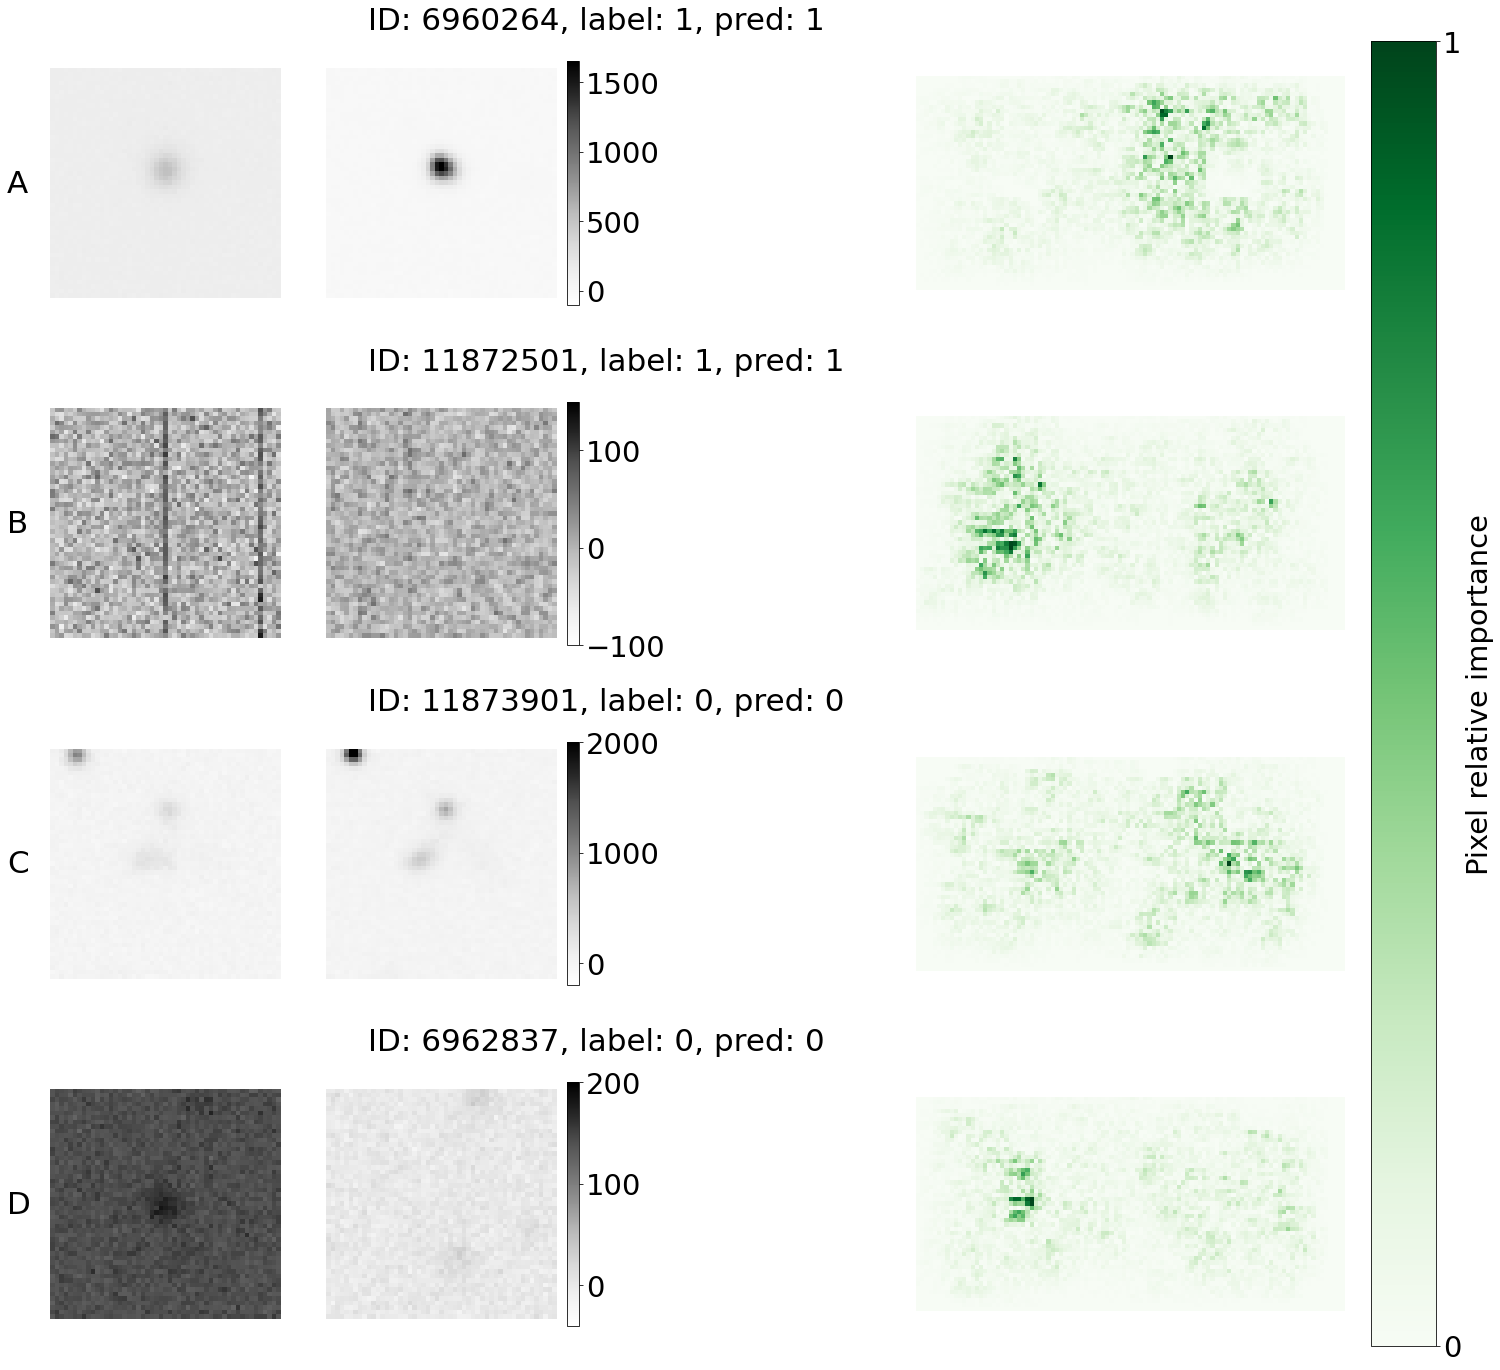

In [255]:
fig, ax = plt.subplots(4, 5,figsize=(25,24))
# fig = plt.figure(figsize=(19,23),constrained_layout=True)
# fig.subplots_adjust(0.1, 0.05, 0.95, 0.95, -0.1, 0.3)

gs = gridspec.GridSpec(4, 5)#,left=1,right=1.5,top=1.4,bottom=1)
np.random.seed(66)
ids = [str(6960264), str(11872501), str(11873901), str(6962837)]
ids_over = winner_concat[(winner_concat_2DH["ID"] == int(ids[0]))|(winner_concat["ID"] == int(ids[1]))|
             (winner_concat["ID"] == int(ids[2]))| (winner_concat["ID"] == int(ids[3]))]

indexes = ids_over.index
for jj,ii in enumerate(indexes): 
    index = np.where(np.char.find(flist3, ids[jj])>=0)
    for ll in [1,2]:
        if ll != 0:
            if (jj == 0) & (ll in [1,2]):
                clims = (-100,1650)
            if (jj == 1) & (ll in [1,2]):
                clims = (-100,150)
            if (jj == 2) & (ll in [1,2]):
                clims = (-200,2000)
            if (jj == 3) & (ll in [1,2]):
                clims = (-40,200)
        ax[jj,ll-1] = plt.subplot(gs[jj, ll-1])
        ax[jj, ll-1].axis("off")
        cmst0 = ax[jj,ll-1].imshow(data_full[index[0][ll]],cmap = "Greys", clim = (clims[0],clims[1]))
        # ax[jj,ll-1].contour(data_full[index[0][ll]], levels=[240, 500, 1000, 1600], colors='blue', alpha=0.5)

        if ll == 2:
            colorbar_srch = fig.colorbar(cmst0, ax = ax[jj, 0:2],fraction=0.023, pad=0.02)
            colorbar_srch.ax.tick_params(labelsize=29)
    
        # ax[jj,0].text(70,-6, 
        #             "ID: {}, label: {}, pred: {} ".format(int(test_ID[ii]), 
        #                                                   int(test_targ[ii]), df_te["predicted"][ii]), 
        #             fontsize = 21)
    ax[jj,2].axis("off")

    ax[jj,3] = plt.subplot(gs[jj, 3:])
    ax[jj,3].axis("off")
    mm = ax[jj,3].imshow(dgrad_abs_2DH[ids_over[ids_over["ID"]==int(ids[jj])].index][0],cmap = "Greens",clim = (np.array(dgrad_abs_2DH[ids_over[ids_over["ID"]==int(ids[jj])].index][0]).min(),np.array(dgrad_abs_2DH[ids_over[ids_over["ID"]==int(ids[jj])].index][0]).max()))
#     contosrch = ax[jj,2].contour(data_full[index[0][1]], levels=[240, 500, 1000, 1600], colors='purple', alpha=0.5)
#     contotemp = ax[jj,1].contour(data_full[index[0][2]], levels=[240, 500, 1000, 1600], colors='blue', alpha=0.5)
#     x1 = []
#     y1 = []
#     ll = 0
#     for ee in contosrch.collections:
#         ll = ll+1
#     for ii in range(ll):
#         if len(contotemp.collections[ii].get_paths()) != 0:
#             p1 = contotemp.collections[ii].get_paths()[0]
#             v1 = p1.vertices
#             x1.append(v1[:,0])
#             y1.append(v1[:,1])
#     for ii in range(len(x1)):
#         ax[jj,2].plot(np.array(x1[ii])+51, np.array(y1[ii]), color='purple', alpha=0.5)

#     colorbar_sm = fig.colorbar(mm, ax = ax[jj,2],fraction=0.024, pad=0.02)
#     colorbar_sm.ax.tick_params(labelsize=29)
    
right_index = [17001, 4999, 10403, 15881]
for jj,ii in enumerate(right_index):
#     print(jj, ii)
    ax[jj,0].axis("off")
    ax[jj,0].text(70,-9, 
                "ID: {}, label: {}, pred: {} ".format(int(ids_over.loc[ii]["ID"]), 
                                                      int(ids_over.loc[ii]["OBJECT_TYPE"]), ids_over.loc[ii]["predicted"]), 
                fontsize = 31)

ax[0, 0].text(-10, 27, "A", fontsize=31)
ax[1, 0].text(-10, 27, "B", fontsize=31)
ax[2, 0].text(-10, 27, "C", fontsize=31)
ax[3, 0].text(-10, 27, "D", fontsize=31)

colorbar_sm = fig.colorbar(mm, ax = ax[0:,3], ticks = [np.array(dgrad_abs_2DH[ids_over[ids_over["ID"]==int(ids[jj])].index][0]).min(), np.array(dgrad_abs_2DH[ids_over[ids_over["ID"]==int(ids[jj])].index][0]).max()], fraction=0.14)
colorbar_sm.ax.set_ylabel("Pixel relative importance", fontsize=29)
colorbar_sm.ax.set_yticklabels(['0','1'])
colorbar_sm.ax.tick_params(labelsize=29)

# plt.savefig("saliency_plot_noDIA.pdf",bbox_inches ="tight")

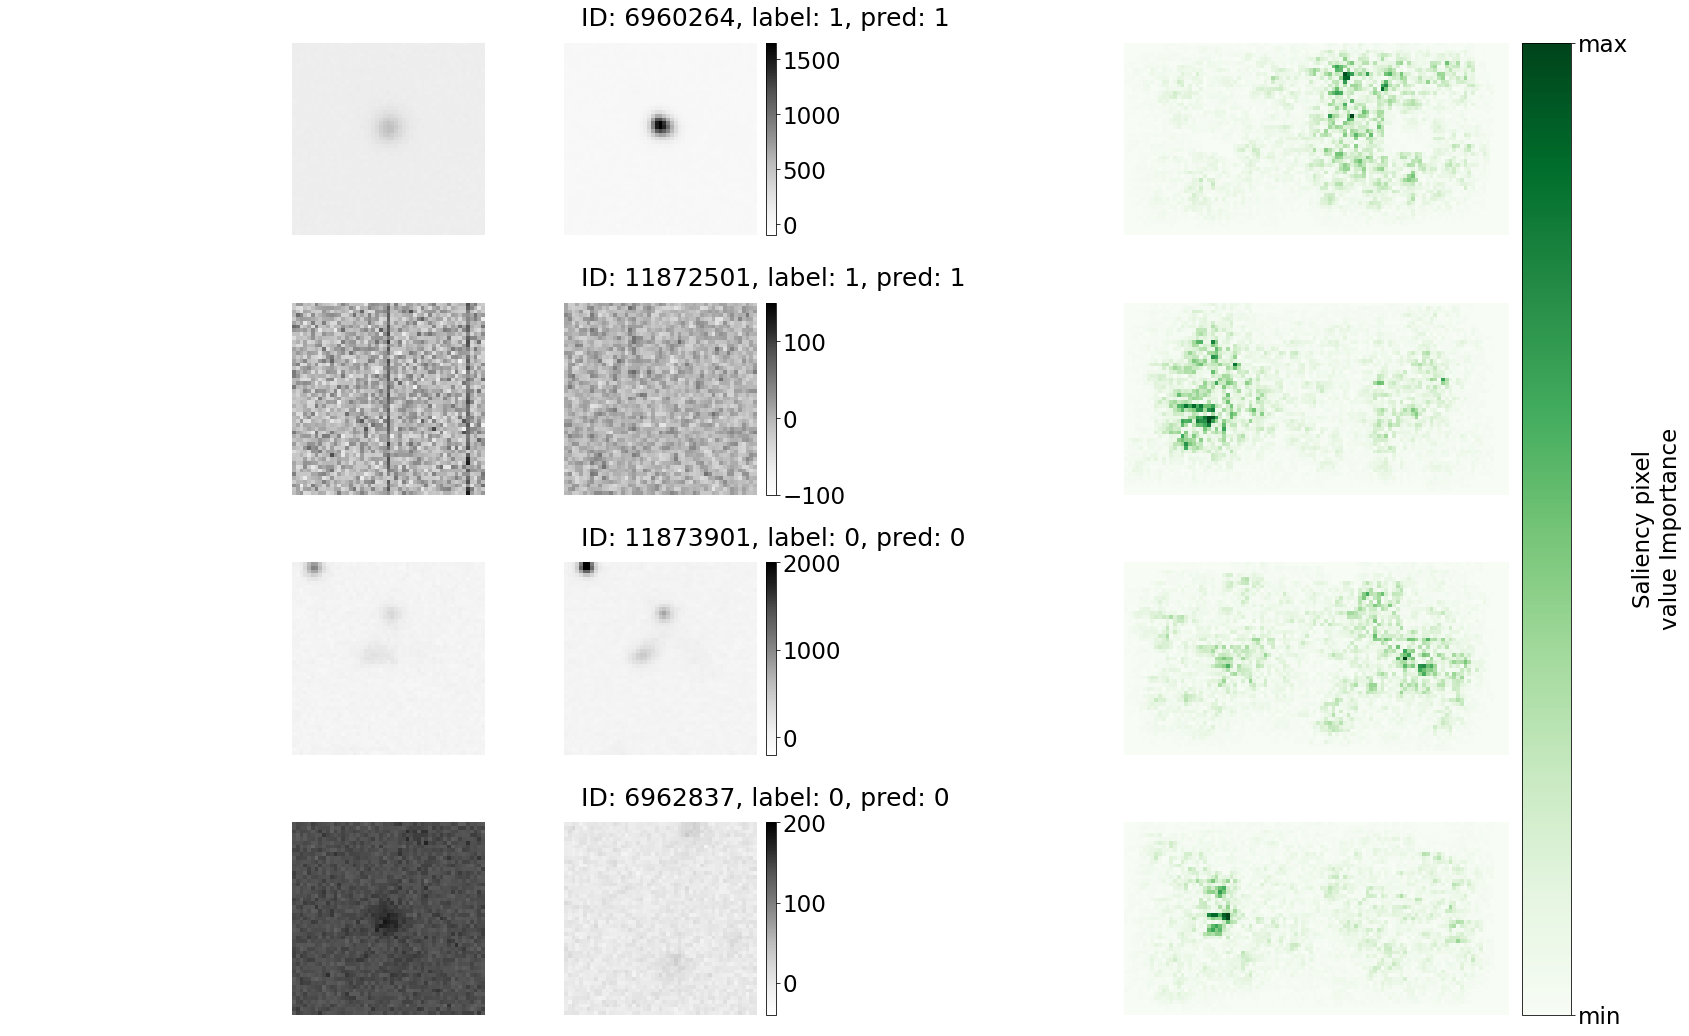

In [72]:
fig, ax = plt.subplots(4, 7,figsize=(25,15))
# fig = plt.figure(figsize=(19,23),constrained_layout=True)
# fig.subplots_adjust(0.1, 0.05, 0.95, 0.95, -0.1, 0.3)
fig.subplots_adjust(0.05, 0.05, 0.95, 0.95, 0.4, 0.35)

# gs = gridspec.GridSpec(4, 6)#,left=1,right=1.5,top=1.4,bottom=1)
np.random.seed(66)
ids = [str(6960264), str(11872501), str(11873901), str(6962837)]

ids_over = winner_concat[(winner_concat["ID"] == int(ids[0]))|(winner_concat["ID"] == int(ids[1]))|
             (winner_concat["ID"] == int(ids[2]))| (winner_concat["ID"] == int(ids[3]))]

indexes = ids_over.index
for jj,ii in enumerate(indexes): 
    index = np.where(np.char.find(flist3, ids[jj])>=0)
    
    ax[jj,4] = plt.subplot2grid((4,7), (jj,4), colspan=3)
    ax[jj,4].axis("off")
    ax[jj,4].axis("off")
    mm = ax[jj,4].imshow(dgrad_abs_2DH[ids_over[ids_over["ID"]==int(ids[jj])].index][0],cmap = "Greens",clim = (np.array(dgrad_abs_2DH[ids_over[ids_over["ID"]==int(ids[jj])].index][0]).min(),np.array(dgrad_abs_2DH[ids_over[ids_over["ID"]==int(ids[jj])].index][0]).max()))
#     ax[jj,3].contour(data_full[index[0][1]], levels=[240, 500, 1000, 1600], colors='purple', alpha=0.5)


    
    
    for ll in range(3):
        if (jj == 0) & (ll == 0):
            clims = (-100,100)
        if (jj == 0) & (ll in [1,2]):
            clims = (-100,1650)
        if (jj == 1) & (ll == 0):
            clims = (-150,220)
        if (jj == 1) & (ll in [1,2]):
            clims = (-100,150)
        if (jj == 2) & (ll == 0):
            clims = (-150,250)
        if (jj == 2) & (ll in [1,2]):
            clims = (-200,2000)
        if (jj == 3) & (ll == 0):
            clims = (-70,100)
        if (jj == 3) & (ll in [1,2]):
            clims = (-40,200)
        ax[jj,ll] = plt.subplot2grid((4,6), (jj,ll), colspan=1)
        ax[jj,ll].axis("off")
        
        if ll != 0:
            cmst0 = ax[jj,ll].imshow(data_full[index[0][ll]],cmap = "Greys", clim = (clims[0],clims[1]))
        
        # if ll == 0:
        #     colorbar_diff = fig.colorbar(cmst0, ax = ax[jj, 0], fraction=0.047)
        #     colorbar_diff.ax.tick_params(labelsize=23)
            if ll == 2:
                colorbar_srch = fig.colorbar(cmst0, ax = ax[jj, 1:3], fraction=0.022, pad=0.02)
                colorbar_srch.ax.tick_params(labelsize=23)
    
# plt.tight_layout()
    
right_index = [17001, 4999, 10403, 15881]
for jj,ii in enumerate(right_index):
#     print(jj, ii)
    ax[jj, 0].axis("off")
    ax[jj,2].text(4,-5, 
                "ID: {}, label: {}, pred: {} ".format(int(ids_over.loc[ii]["ID"]), 
                                                      int(ids_over.loc[ii]["OBJECT_TYPE"]), ids_over.loc[ii]["predicted"]), 
                fontsize = 25)
# ax[0, 0].text(-10, 27, "A", fontsize=25)
# ax[1, 0].text(-10, 27, "B", fontsize=25)
# ax[2, 0].text(-10, 27, "C", fontsize=25)
# ax[3, 0].text(-10, 27, "D", fontsize=25)

colorbar_sm = fig.colorbar(mm, ax = ax[0:,4], ticks = [np.array(dgrad_abs_2DH[ids_over[ids_over["ID"]==int(ids[jj])].index][0]).min(), np.array(dgrad_abs_2DH[ids_over[ids_over["ID"]==int(ids[jj])].index][0]).max()] , fraction=0.16, pad=0.02)
colorbar_sm.ax.set_ylabel("Saliency pixel\nvalue Importance", fontsize=23)
colorbar_sm.ax.set_yticklabels(['min','max'])
colorbar_sm.ax.tick_params(labelsize=23)

# plt.savefig("saliency_plot_2d_poster.pdf",bbox_inches ="tight")

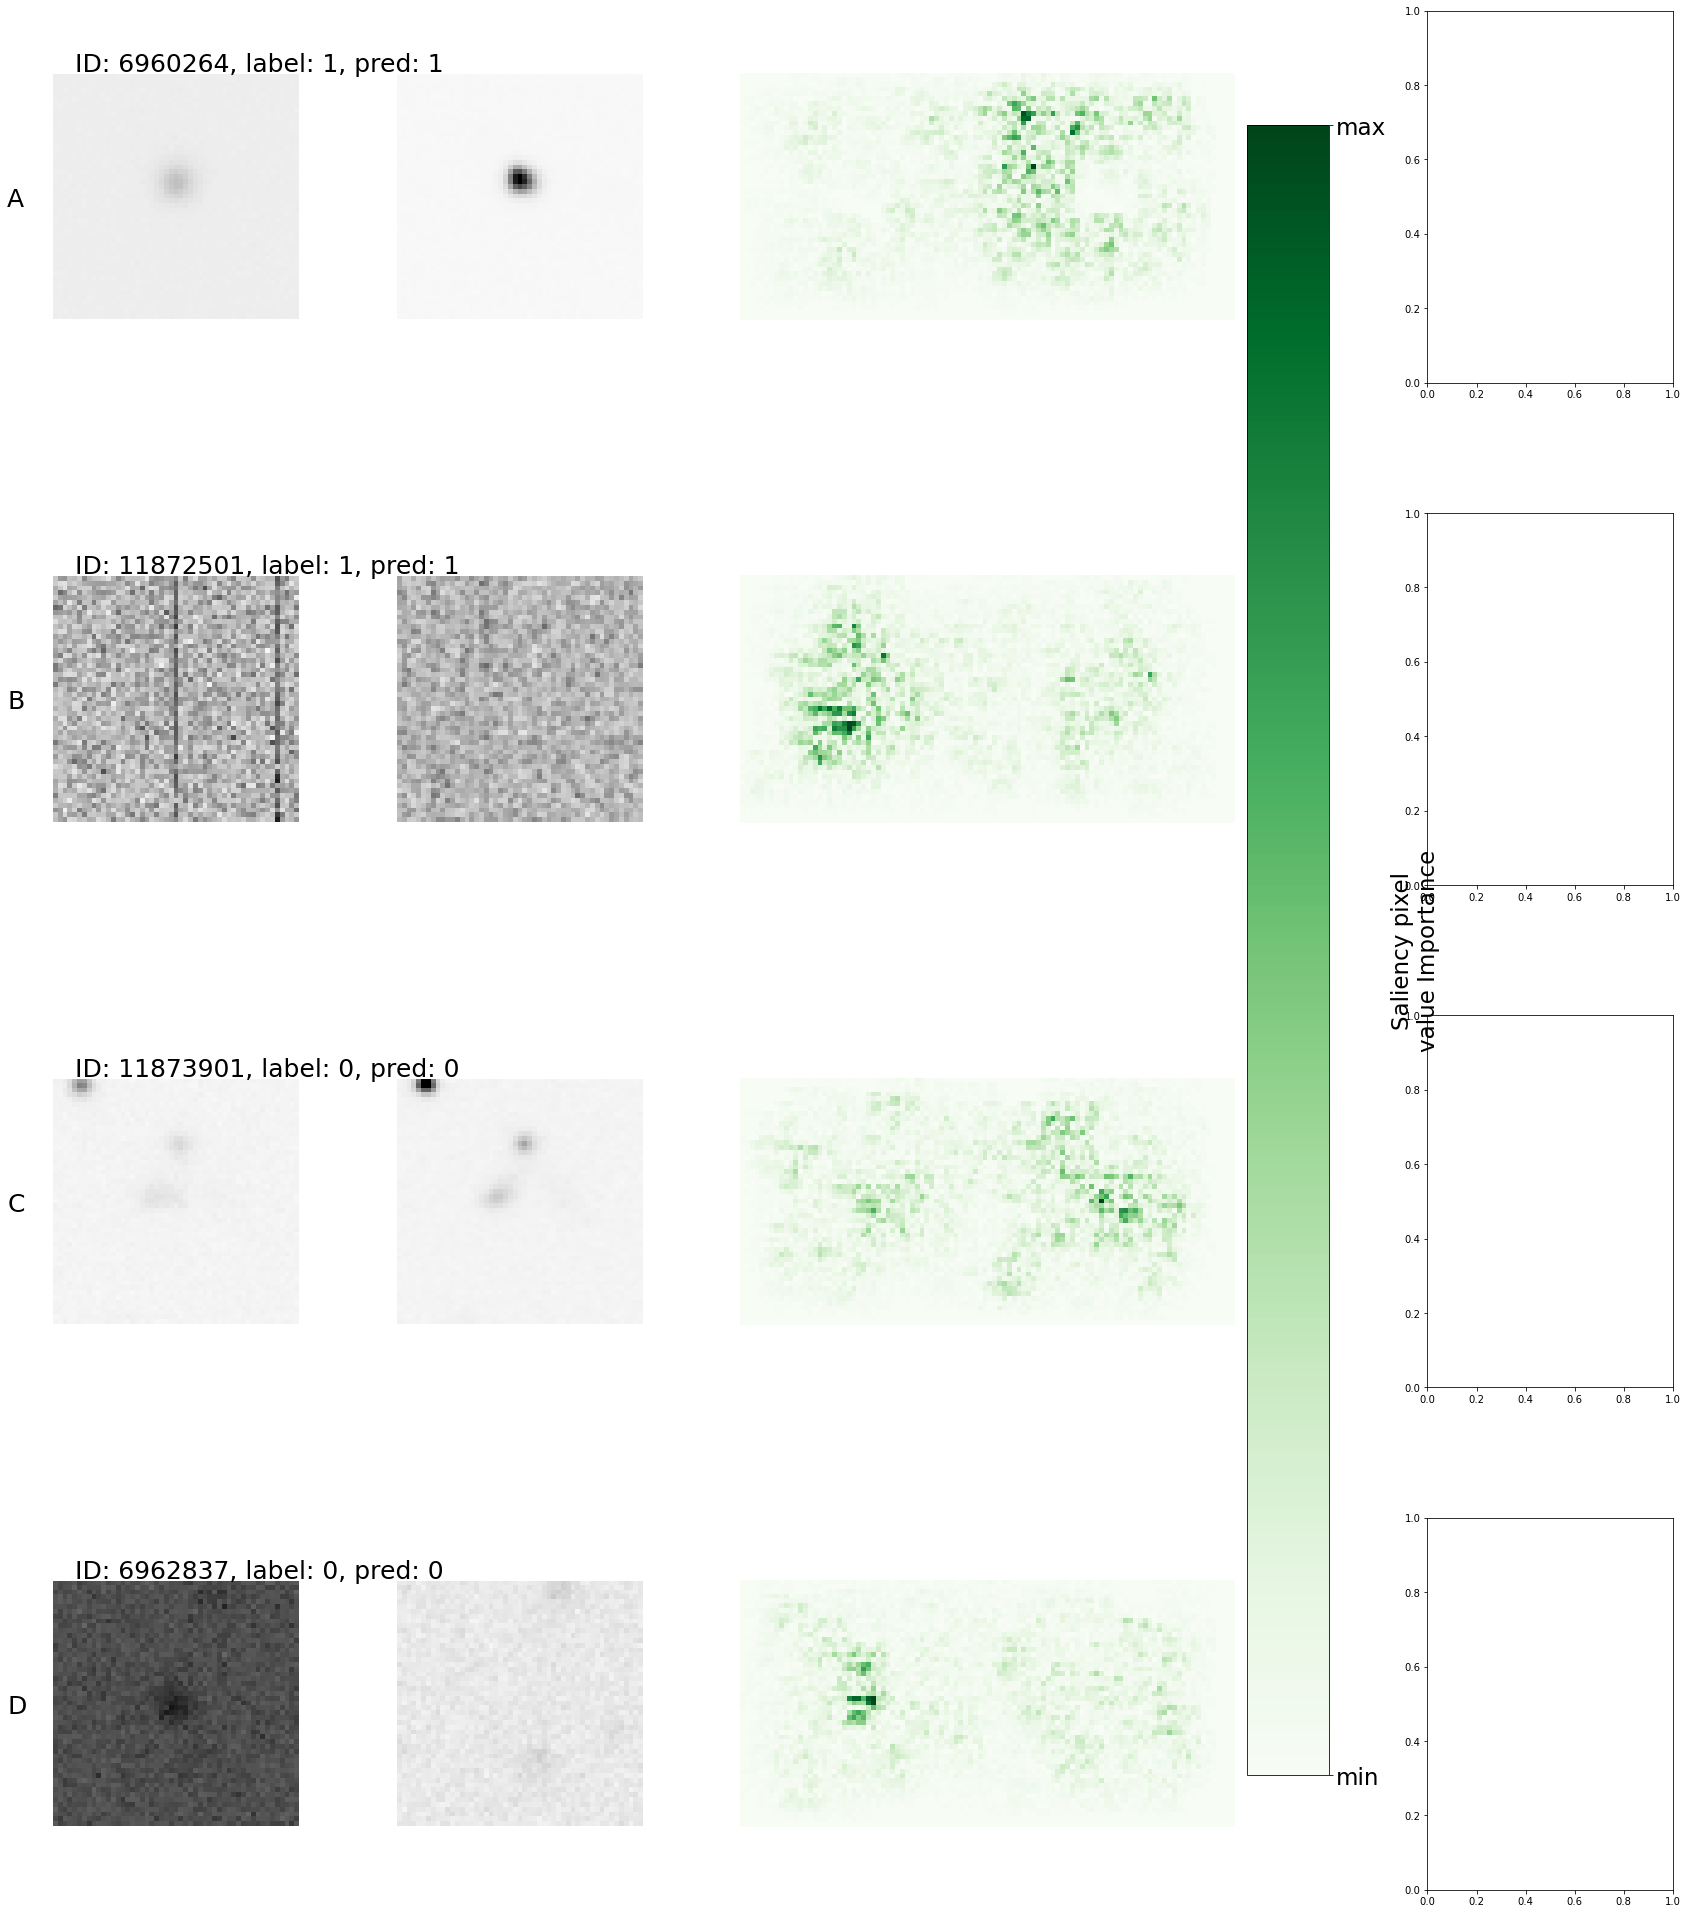

In [73]:
fig, ax = plt.subplots(4, 5, figsize=(25,29))
# fig = plt.figure(figsize=(19,23),constrained_layout=True)
# fig.subplots_adjust(0.1, 0.05, 0.95, 0.95, -0.1, 0.3)
fig.subplots_adjust(0.05, 0.05, 0.95, 0.95, 0.4, 0.35)

# gs = gridspec.GridSpec(4, 6)#,left=1,right=1.5,top=1.4,bottom=1)
np.random.seed(66)
ids = [str(6960264), str(11872501), str(11873901), str(6962837)]

ids_over = winner_concat[(winner_concat["ID"] == int(ids[0]))|(winner_concat["ID"] == int(ids[1]))|
             (winner_concat["ID"] == int(ids[2]))| (winner_concat["ID"] == int(ids[3]))]

indexes = ids_over.index
for jj,ii in enumerate(indexes): 
    index = np.where(np.char.find(flist3, ids[jj])>=0)
    ax[jj,4] = plt.subplot2grid((4,5), (jj,2), colspan=2)
    ax[jj,4].axis("off")
    ax[jj,4].axis("off")
    ax[jj,2].axis("off")
    mm = ax[jj,4].imshow(dgrad_abs_2DH[ids_over[ids_over["ID"]==int(ids[jj])].index][0],cmap = "Greens",clim = (np.array(dgrad_abs_2DH[ids_over[ids_over["ID"]==int(ids[jj])].index][0]).min(),np.array(dgrad_abs_2DH[ids_over[ids_over["ID"]==int(ids[jj])].index][0]).max()))
#     ax[jj,3].contour(data_full[index[0][1]], levels=[240, 500, 1000, 1600], colors='purple', alpha=0.5)


#     index = np.where(np.char.find(flist3, ids[jj])>=0)
    for ll in [1,2]:
        if ll != 0:
            if (jj == 0) & (ll in [1,2]):
                clims = (-100,1650)
            if (jj == 1) & (ll in [1,2]):
                clims = (-100,150)
            if (jj == 2) & (ll in [1,2]):
                clims = (-200,2000)
            if (jj == 3) & (ll in [1,2]):
                clims = (-40,200)
        ax[jj,ll-1] = plt.subplot2grid((4,5), (jj,ll-1), colspan=1)
        ax[jj,ll-1].axis("off")
        cmst0 = ax[jj,ll-1].imshow(data_full[index[0][ll]],cmap = "Greys", clim = (clims[0],clims[1]))

        if ll == 1:
            colorbar_srch = fig.colorbar(cmst0, ax = ax[jj, 1], fraction=0.022, pad=-0.2)
            colorbar_srch.ax.tick_params(labelsize=23)
    
# plt.tight_layout()
    
right_index = [17001, 4999, 10403, 15881]
for jj,ii in enumerate(right_index):
#     print(jj, ii)
    ax[jj, 0].axis("off")
    ax[jj,0].text(4,-1, 
                "ID: {}, label: {}, pred: {} ".format(int(ids_over.loc[ii]["ID"]), 
                                                      int(ids_over.loc[ii]["OBJECT_TYPE"]), ids_over.loc[ii]["predicted"]), 
                fontsize = 25)
ax[0, 0].text(-10, 27, "A", fontsize=25)
ax[1, 0].text(-10, 27, "B", fontsize=25)
ax[2, 0].text(-10, 27, "C", fontsize=25)
ax[3, 0].text(-10, 27, "D", fontsize=25)
colorbar_sm = fig.colorbar(mm, ax = ax[0:,4], ticks = [np.array(dgrad_abs_2DH[ids_over[ids_over["ID"]==int(ids[jj])].index][0]).min(), np.array(dgrad_abs_2DH[ids_over[ids_over["ID"]==int(ids[jj])].index][0]).max()] , fraction=0.14, pad=0.02)
colorbar_sm.ax.set_ylabel("Saliency pixel\nvalue Importance", fontsize=23)
colorbar_sm.ax.set_yticklabels(['min','max'])
colorbar_sm.ax.tick_params(labelsize=23)

In [ ]:
from astropy.io import fits
imges_train = np.zeros((4*3,51,51))

imges_train[0] = fits.open('../data/stamps9/SNWG/Archive/2013/Y1/20130829/470681007/diff6960264.fits')[0].data
imges_train[1] = fits.open('../data/stamps9/SNWG/Archive/2013/Y1/20130829/470681007/srch6960264.fits')[0].data
imges_train[2] = fits.open('../data/stamps9/SNWG/Archive/2013/Y1/20130829/470681007/temp6960264.fits')[0].data
imges_train[3] = fits.open('../data/stamps9/SNWG/Archive/2013/Y1/20140209/498352745/diff11872501.fits')[0].data
imges_train[4] = fits.open('../data/stamps9/SNWG/Archive/2013/Y1/20140209/498352745/srch11872501.fits')[0].data
imges_train[5] = fits.open('../data/stamps9/SNWG/Archive/2013/Y1/20140209/498352745/temp11872501.fits')[0].data
imges_train[6] = fits.open('../data/stamps2/SNWG/Archive/2013/Y1/20140209/498151557/diff11873901.fits')[0].data
imges_train[7] = fits.open('../data/stamps2/SNWG/Archive/2013/Y1/20140209/498151557/srch11873901.fits')[0].data
imges_train[8] = fits.open('../data/stamps2/SNWG/Archive/2013/Y1/20140209/498151557/temp11873901.fits')[0].data
imges_train[9] = fits.open('../data/stamps2/SNWG/Archive/2013/Y1/20130829/470681009/diff6962837.fits')[0].data
imges_train[10] = fits.open('../data/stamps2/SNWG/Archive/2013/Y1/20130829/470681009/srch6962837.fits')[0].data
imges_train[11] = fits.open('../data/stamps2/SNWG/Archive/2013/Y1/20130829/470681009/temp6962837.fits')[0].data


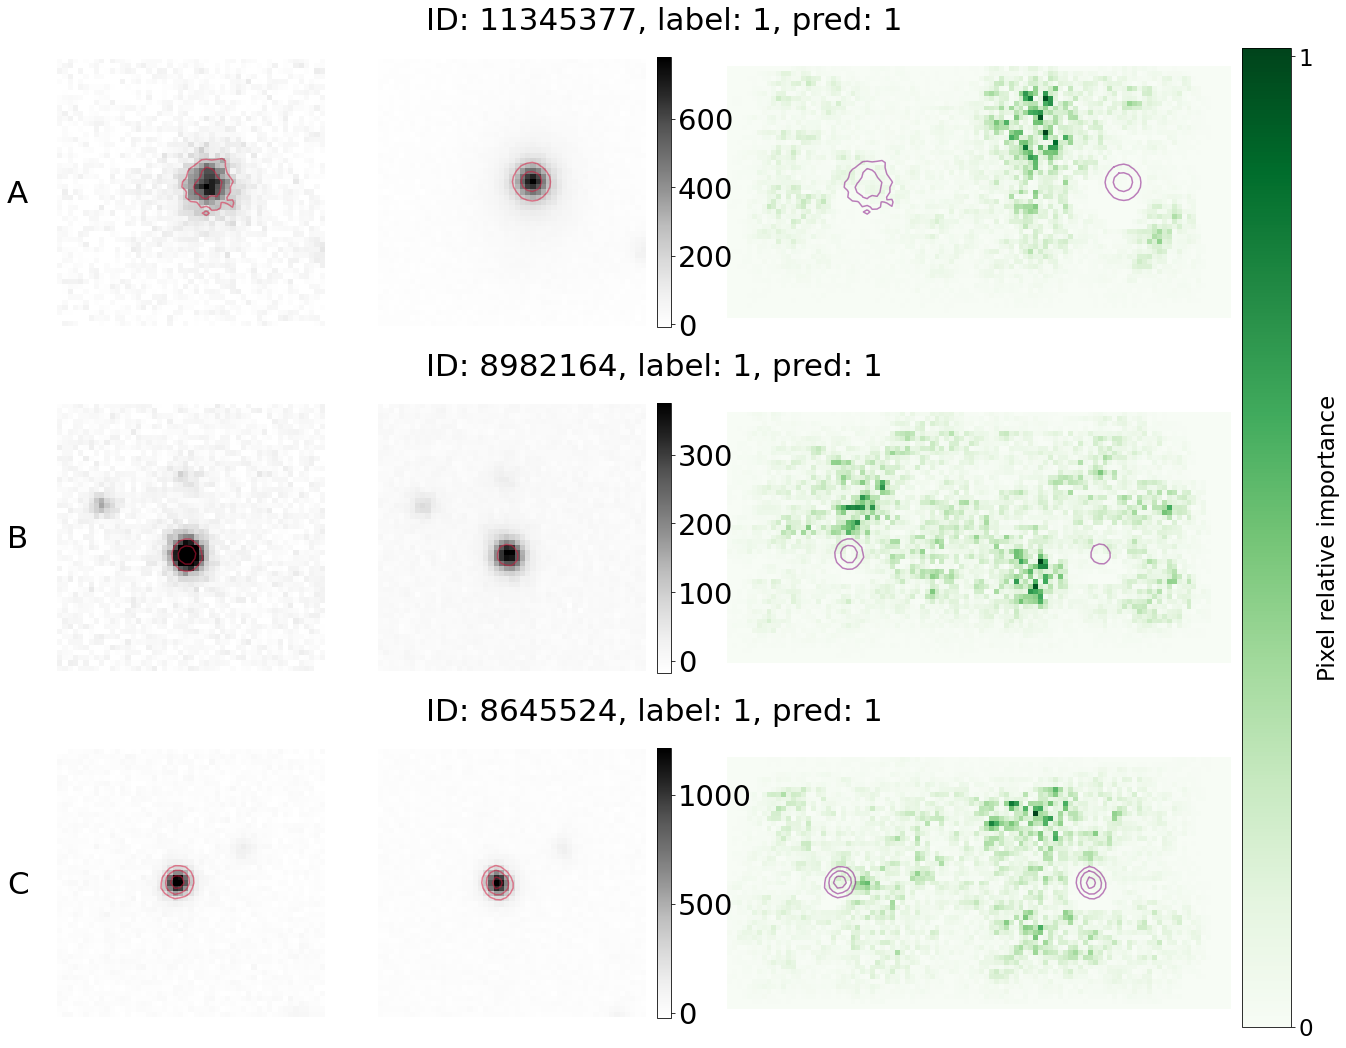

In [257]:
fig, ax = plt.subplots(3, 4,figsize=(23,18))

gs = gridspec.GridSpec(3, 4)#,left=1,right=1.5,top=1.4,bottom=1)
np.random.seed(66)
indexx = winner_concat.sample(8).index
indexes = [1,2,5]
for jj in range(3):
    
    index = np.where(np.char.find(flist3, str(vertical_concat["ID"].to_numpy()[indexx[indexes[jj]]]))>=0)
#     ax[jj,0] = plt.subplot(gs[jj, 0])
#     cmst0 = ax[jj,0].imshow(data_full[index[0][0]],cmap = "Greys", clim = (data_full[index[0][0]].min(),data_full[index[0][0]].max()))
#     ax[jj,0].imshow(data_full[index[0][0]],cmap = "Greys", clim = (data_full[index[0][0]].min(),data_full[index[0][0]].max()))
    ax[jj,0] = plt.subplot(gs[jj, 0])
    ax[jj,0].axis("off")
    cmst1 = ax[jj,0].imshow(data_full[index[0][1]],cmap = "Greys", clim = (data_full[index[0][2]].min(),data_full[index[0][2]].max()))
    contosrch = ax[jj,0].contour(data_full[index[0][1]], levels=[240, 500, 1000, 1600], colors='crimson', alpha=0.5)
    ax[jj,1] = plt.subplot(gs[jj, 1])
    ax[jj,1].axis("off")
    cmst2 = ax[jj,1].imshow(data_full[index[0][2]],cmap = "Greys", clim = (data_full[index[0][2]].min(),data_full[index[0][2]].max()))
    contotemp = ax[jj,1].contour(data_full[index[0][2]], levels=[240, 500, 1000, 1600], colors='crimson', alpha=0.5)
    x1 = []
    y1 = []
    ll = 0
    for ee in contosrch.collections:
        ll = ll+1
    for ii in range(ll):
        if len(contotemp.collections[ii].get_paths()) != 0:
            p1 = contotemp.collections[ii].get_paths()[0]
            v1 = p1.vertices
            x1.append(v1[:,0])
            y1.append(v1[:,1])
    ax[jj,2] = plt.subplot(gs[jj, 2:])
    ax[jj,2].axis("off")
    mm = ax[jj,2].imshow(dgrad_abs_2DH[indexx[indexes[jj]]],cmap = "Greens",clim = (np.array(dgrad_abs_2DH[indexx[indexes[jj]]]).min(),np.array(dgrad_abs_2DH[indexx[indexes[jj]]]).max()))
    ax[jj,2].contour(data_full[index[0][1]], levels=[240, 500, 1000, 1600], colors='purple', alpha=0.5)
    for ii in range(len(x1)):
        ax[jj,2].plot(np.array(x1[ii])+51, np.array(y1[ii]), color='purple', alpha=0.5)
#     ax[jj,2].contour(data_full[index[0][2]], levels=[240, 500, 1000, 1600], colors='red', alpha=0.5)
    ax[jj,0].text(70,-6, 
                    "ID: {}, label: {}, pred: {} ".format(int(vertical_concat["ID"].to_numpy()[indexx[indexes[jj]]]), 
                                                          int(vertical_concat["OBJECT_TYPE"].to_numpy()[indexx[jj]]), vertical_concat["predicted"].to_numpy()[indexx[indexes[jj]]]), 
                    fontsize = 31)
#     colorbar_sm = fig.colorbar(mm, ax = ax[jj,2],fraction=0.024, pad=0.02)
#     colorbar_sm.ax.tick_params(labelsize=29)
#     fig.colorbar(cmst0, ax = ax[jj, 0],fraction=0.047)
#     fig.colorbar(cmst1, ax = ax[jj, 1],fraction=0.047)
    colorbar_srch = fig.colorbar(cmst2, ax = ax[jj, 0:2],fraction=0.022, pad=0.02)
    colorbar_srch.ax.tick_params(labelsize=29)

    
    
ax[0, 0].text(-10, 27, "A", fontsize=31)
ax[1, 0].text(-10, 27, "B", fontsize=31)
ax[2, 0].text(-10, 27, "C", fontsize=31)

colorbar_sm = fig.colorbar(mm, ax = ax[0:,2], ticks = [np.array(dgrad_abs[indexx[indexes[0]]]).min(), 0.0077] , fraction=0.16, pad=0.02)
colorbar_sm.ax.set_ylabel("Pixel relative importance", fontsize=23)
colorbar_sm.ax.set_yticklabels(['0','1'])
colorbar_sm.ax.tick_params(labelsize=23)

plt.savefig("saliency_plot_noDIA3exam.pdf",bbox_inches ="tight")

In [76]:
index = np.where(np.char.find(flist3, str(11476563))>=0)
print(index)

(array([54498, 54499, 54500]),)


In [259]:
to_save_fig_2d = np.zeros((8*3, 3, 51, 51))
to_save_ID_2d = np.zeros((8*3))
to_save_label_2d = np.zeros((8*3))
to_save_predic_2d = np.zeros((8*3))
to_save_salien_2d = np.zeros((8*3, 51, 102, 1))

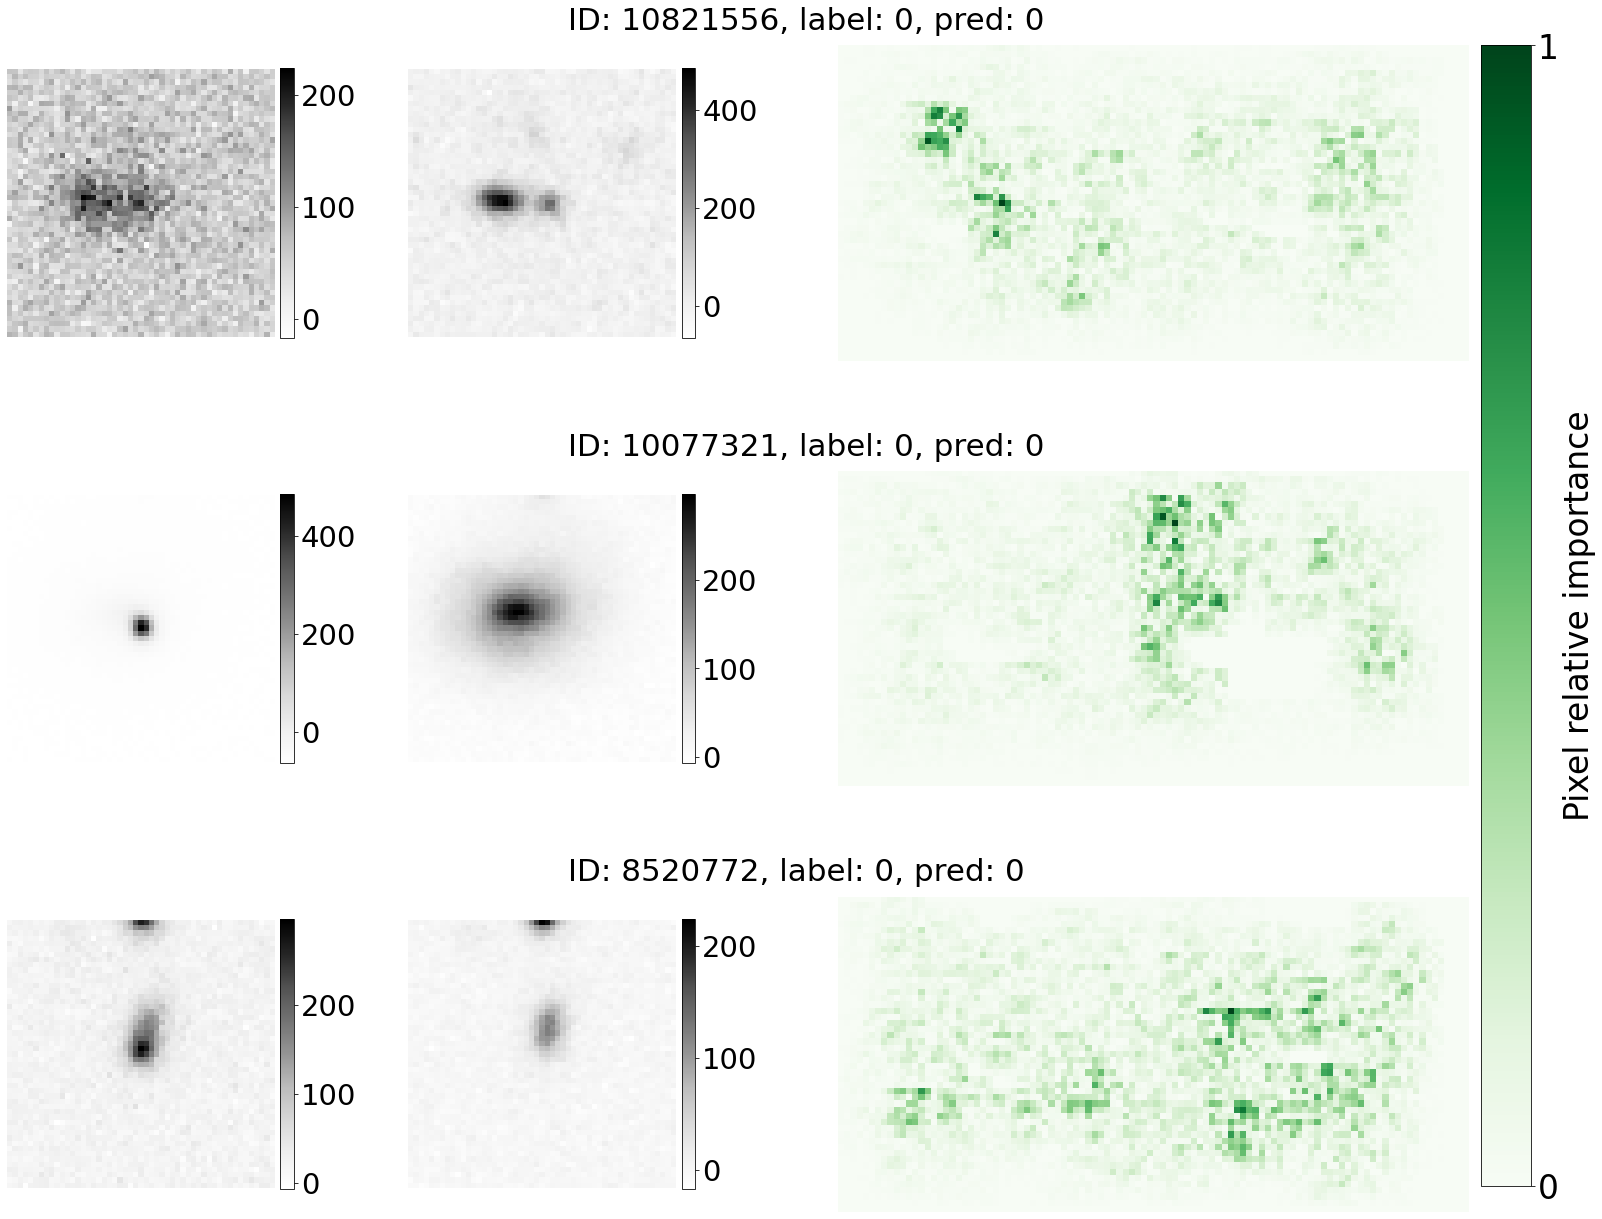

In [266]:
fig, ax = plt.subplots(3,4,figsize=(23,18))
fig.subplots_adjust(0.05, 0.05, 0.95, 0.95, 0.4, 0.35)

ids_over = vertical_concat_2DHp[(vertical_concat_2DHp["OBJECT_TYPE"] == 0) & (vertical_concat_2DHp["predicted"] == 0)]
# seed = 766
seed = 7407
# for seed in [766, 7407]:
np.random.seed(seed)
indexes = ids_over.sample(3).index
# print(indexes)
for jj,ii in enumerate(indexes): 
    index = np.where(np.char.find(flist3, str(int(ids_over.loc[ii]["ID"])))>=0)
    ax[jj,0] = plt.subplot2grid((3,4), (jj,0), colspan=1)
    ax[jj,0].axis("off")
    cmst1 = ax[jj,0].imshow(data_full[index[0][1]],cmap = "Greys", clim = (data_full[index[0][1]].min(),data_full[index[0][1]].max()))
    colorbar_srch = fig.colorbar(cmst2, ax = ax[jj, 0:1], fraction=0.047, pad=0.02)
    colorbar_srch.ax.tick_params(labelsize=29)
    ax[jj,1] = plt.subplot2grid((3,4), (jj,1), colspan=1)
    ax[jj,1].axis("off")
    cmst2 = ax[jj,1].imshow(data_full[index[0][2]],cmap = "Greys", clim = (data_full[index[0][2]].min(),data_full[index[0][2]].max()))
    colorbar_temp = fig.colorbar(cmst2, ax = ax[jj, 1:2], fraction=0.047, pad=0.02)
    colorbar_temp.ax.tick_params(labelsize=29)
    ax[jj,2].axis("off")
    ax[jj,1].text(30,-8,
                "ID: {}, label: {}, pred: {} ".format(int(ids_over.loc[ii]["ID"]), 
                                                      int(ids_over.loc[ii]["OBJECT_TYPE"]), int(ids_over.loc[ii]["predicted"])), 
                fontsize = 31)
    if seed == 766:
        to_save_fig_2d[jj] = np.stack((data_full[index[0][0]], data_full[index[0][1]], data_full[index[0][2]]))
        to_save_ID_2d[jj] = ids_over.loc[ii]["ID"]
        to_save_label_2d[jj] = ids_over.loc[ii]["OBJECT_TYPE"]
        to_save_predic_2d[jj] = ids_over.loc[ii]["predicted"]

    if seed == 7407:
        to_save_fig_2d[jj+3] = np.stack((data_full[index[0][0]], data_full[index[0][1]], data_full[index[0][2]]))
        to_save_ID_2d[jj+3] = ids_over.loc[ii]["ID"]
        to_save_label_2d[jj+3] = ids_over.loc[ii]["OBJECT_TYPE"]
        to_save_predic_2d[jj+3] = ids_over.loc[ii]["predicted"]
#     ax[jj,4].axis("off")

# gs2 = gridspec.GridSpecFromSubplotSpec(6, 1, subplot_spec=gs0[1])
for jj, ii in enumerate(indexes):
    ax = plt.subplot2grid((3,4), (jj,2), colspan=2)
    ax.axis("off")
    if seed == 766:
        to_save_salien_2d[jj] = dgrad_abs_2DH[ids_over[ids_over["ID"]==ids_over.loc[ii]["ID"]].index[0]]
    if seed == 7407:
        to_save_salien_2d[jj+3] = dgrad_abs_2DH[ids_over[ids_over["ID"]==ids_over.loc[ii]["ID"]].index[0]]
    mm = ax.imshow(dgrad_abs_2DH[ids_over[ids_over["ID"]==ids_over.loc[ii]["ID"]].index[0]],cmap = "Greens",clim = (np.array(dgrad_abs_2DH[ids_over[ids_over["ID"]==ids_over.loc[ii]["ID"]].index[0]]).min(),np.array(dgrad_abs_2DH[ids_over[ids_over["ID"]==ids_over.loc[ii]["ID"]].index[0]]).max()))
#     colorbar_sm = fig.colorbar(mm, ax = ax,fraction=0.026, pad=0.02)
#     colorbar_sm.ax.tick_params(labelsize=29)
    cax = fig.add_axes([0.94, 0.07, 0.03, 0.88])
    colorbar_sm = fig.colorbar(mm, cax = cax, ticks=[np.array(dgrad_abs_2DH[ids_over[ids_over["ID"]==ids_over.loc[ii]["ID"]].index[0]]).min(), np.array(dgrad_abs_2DH[ids_over[ids_over["ID"]==ids_over.loc[ii]["ID"]].index[0]]).max()], fraction=0.016, pad=0.02)
    colorbar_sm.ax.set_ylabel("Pixel relative importance", fontsize=33)
    colorbar_sm.ax.set_yticklabels(['0','1'])
    colorbar_sm.ax.tick_params(labelsize=33)

# plt.savefig("saliency_plot_other3nodiaTP-see{}.pdf".format(seed),bbox_inches ="tight")


10821556.0 0.0 0.0


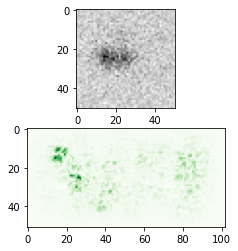

In [79]:
fig, ax = plt.subplots(2, 1)
ax[0].imshow(to_save_fig_2d[3][1], cmap = "Greys",) 
ax[1].imshow(to_save_salien_2d[3], cmap = "Greens",) 
           #clim = (to_save_fig[1][0].min(),to_save_fig[1][0].max()))
print(to_save_ID_2d[3], to_save_label_2d[1], to_save_predic_2d[1])

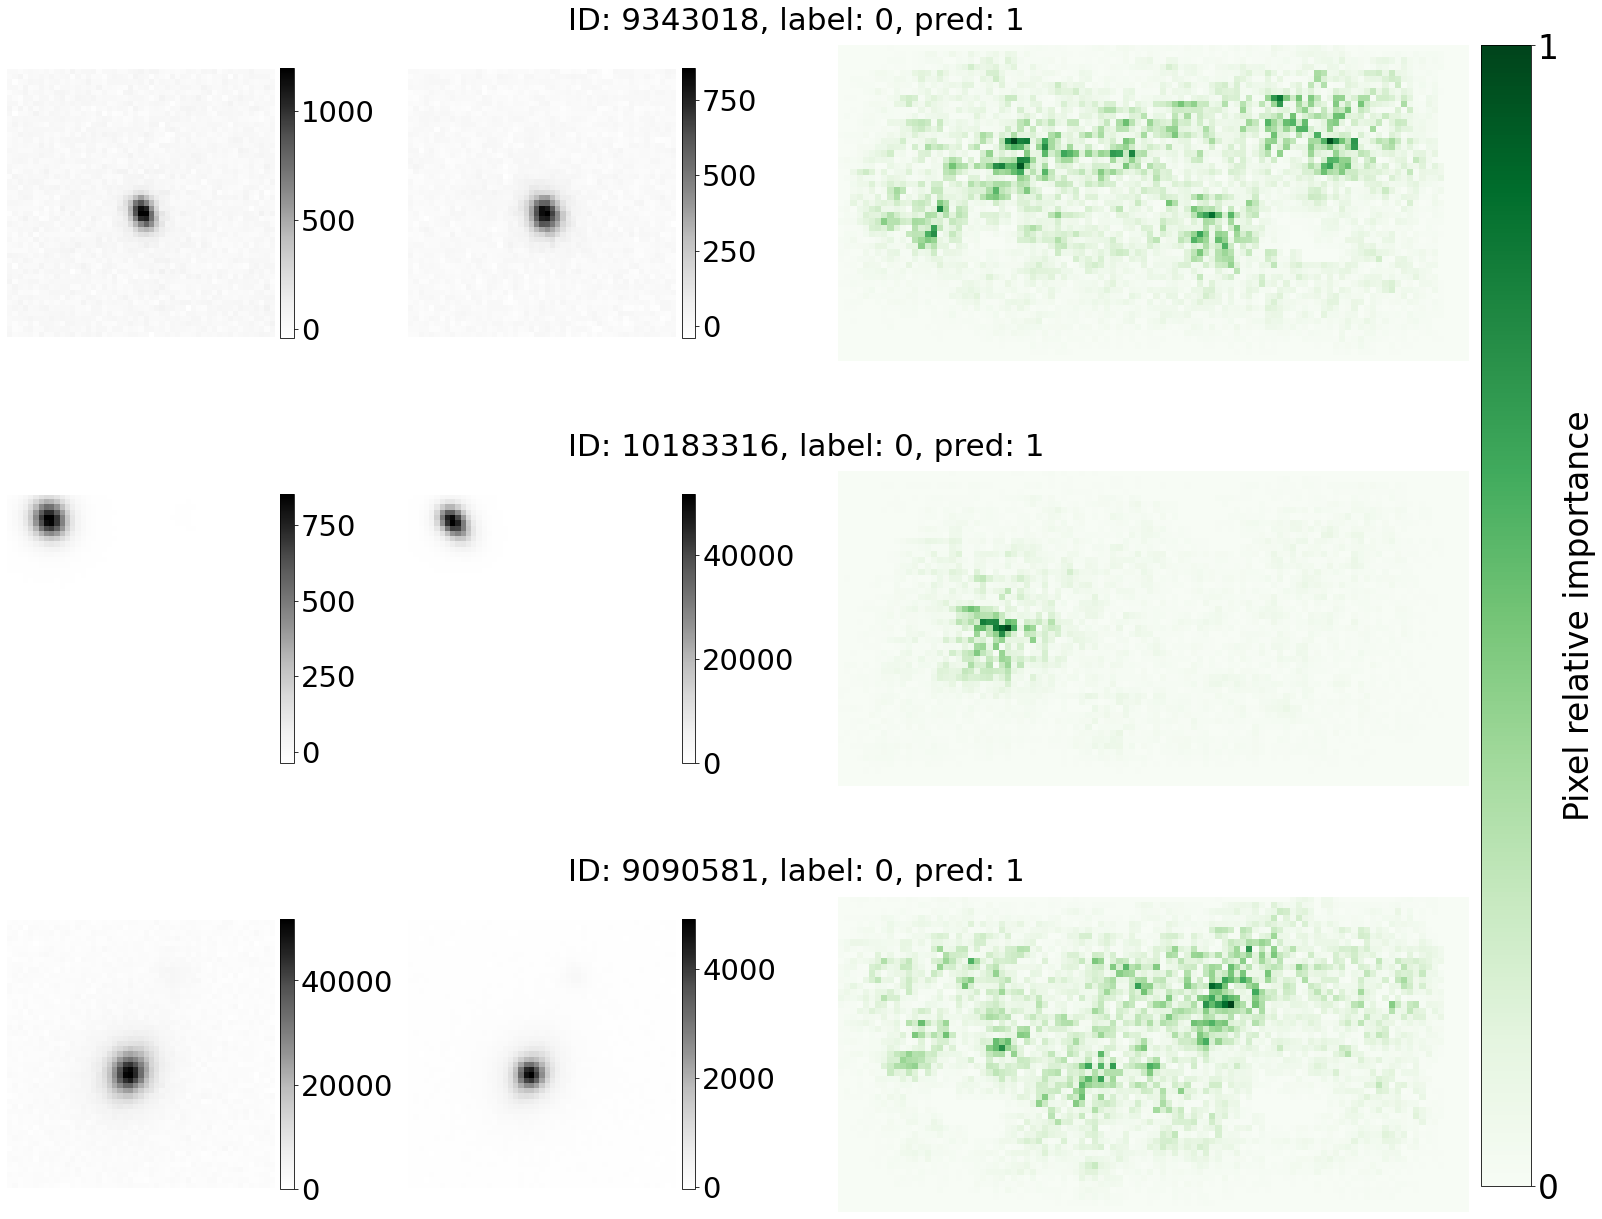

In [271]:
fig, ax = plt.subplots(3,4,figsize=(23,18))
fig.subplots_adjust(0.05, 0.05, 0.95, 0.95, 0.4, 0.35)

ids_over = vertical_concat_2DHp[(vertical_concat_2DHp["OBJECT_TYPE"] == 0) & (vertical_concat_2DHp["predicted"] == 1)]
# seed = 356
seed = 981
# for seed in [356, 981]:
np.random.seed(seed)
indexes = ids_over.sample(3).index
# print(indexes)
for jj,ii in enumerate(indexes): 
    index = np.where(np.char.find(flist3, str(int(ids_over.loc[ii]["ID"])))>=0)
    ax[jj,0] = plt.subplot2grid((3,4), (jj,0), colspan=1)
    ax[jj,0].axis("off")
    cmst1 = ax[jj,0].imshow(data_full[index[0][1]],cmap = "Greys", clim = (data_full[index[0][1]].min(),data_full[index[0][1]].max()))
    colorbar_srch = fig.colorbar(cmst2, ax = ax[jj, 0:1], fraction=0.047, pad=0.02)
    colorbar_srch.ax.tick_params(labelsize=29)
    ax[jj,1] = plt.subplot2grid((3,4), (jj,1), colspan=1)
    ax[jj,1].axis("off")
    cmst2 = ax[jj,1].imshow(data_full[index[0][2]],cmap = "Greys", clim = (data_full[index[0][2]].min(),data_full[index[0][2]].max()))
    colorbar_temp = fig.colorbar(cmst2, ax = ax[jj, 1:2], fraction=0.047, pad=0.02)
    colorbar_temp.ax.tick_params(labelsize=29)
    ax[jj,2].axis("off")
    ax[jj,1].text(30,-8,
                "ID: {}, label: {}, pred: {} ".format(int(ids_over.loc[ii]["ID"]), 
                                                      int(ids_over.loc[ii]["OBJECT_TYPE"]), int(ids_over.loc[ii]["predicted"])), 
                fontsize = 31)  
    if seed == 356:
        to_save_fig_2d[jj+6] = np.stack((data_full[index[0][0]], data_full[index[0][1]], data_full[index[0][2]]))
        to_save_ID_2d[jj+6] = ids_over.loc[ii]["ID"]
        to_save_label_2d[jj+6] = ids_over.loc[ii]["OBJECT_TYPE"]
        to_save_predic_2d[jj+6] = ids_over.loc[ii]["predicted"]

    if seed == 981:
        to_save_fig_2d[jj+9] = np.stack((data_full[index[0][0]], data_full[index[0][1]], data_full[index[0][2]]))
        to_save_ID_2d[jj+9] = ids_over.loc[ii]["ID"]
        to_save_label_2d[jj+9] = ids_over.loc[ii]["OBJECT_TYPE"]
        to_save_predic_2d[jj+9] = ids_over.loc[ii]["predicted"]
#     ax[jj,4].axis("off")

# gs2 = gridspec.GridSpecFromSubplotSpec(6, 1, subplot_spec=gs0[1])
for jj, ii in enumerate(indexes):
    ax = plt.subplot2grid((3,4), (jj,2), colspan=2)
    ax.axis("off")
    if seed == 356:
        to_save_salien_2d[jj+6] = dgrad_abs_2DH[ids_over[ids_over["ID"]==ids_over.loc[ii]["ID"]].index[0]]
    if seed == 981:
        to_save_salien_2d[jj+9] = dgrad_abs_2DH[ids_over[ids_over["ID"]==ids_over.loc[ii]["ID"]].index[0]]
    mm = ax.imshow(dgrad_abs_2DH[ids_over[ids_over["ID"]==ids_over.loc[ii]["ID"]].index[0]],cmap = "Greens",clim = (np.array(dgrad_abs_2DH[ids_over[ids_over["ID"]==ids_over.loc[ii]["ID"]].index[0]]).min(),np.array(dgrad_abs_2DH[ids_over[ids_over["ID"]==ids_over.loc[ii]["ID"]].index[0]]).max()))
    cax = fig.add_axes([0.94, 0.07, 0.03, 0.88])
    colorbar_sm = fig.colorbar(mm, cax = cax, ticks=[np.array(dgrad_abs_2DH[ids_over[ids_over["ID"]==ids_over.loc[ii]["ID"]].index[0]]).min(), np.array(dgrad_abs_2DH[ids_over[ids_over["ID"]==ids_over.loc[ii]["ID"]].index[0]]).max()], fraction=0.016, pad=0.02)
    colorbar_sm.ax.set_ylabel("Pixel relative importance", fontsize=33)
    colorbar_sm.ax.set_yticklabels(['0','1'])
    colorbar_sm.ax.tick_params(labelsize=33)
    
# plt.savefig("saliency_plot_other3nodiaFN-see{}.pdf".format(seed),bbox_inches ="tight")


9343018.0 0.0 1.0


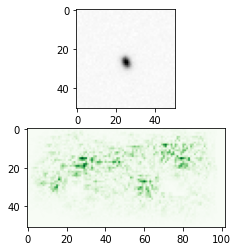

In [98]:
fig, ax = plt.subplots(2, 1)
ax[0].imshow(to_save_fig_2d[9][1], cmap = "Greys",) 
ax[1].imshow(to_save_salien_2d[9], cmap = "Greens",) 
           #clim = (to_save_fig[1][0].min(),to_save_fig[1][0].max()))
print(to_save_ID_2d[9], to_save_label_2d[7], to_save_predic_2d[7])

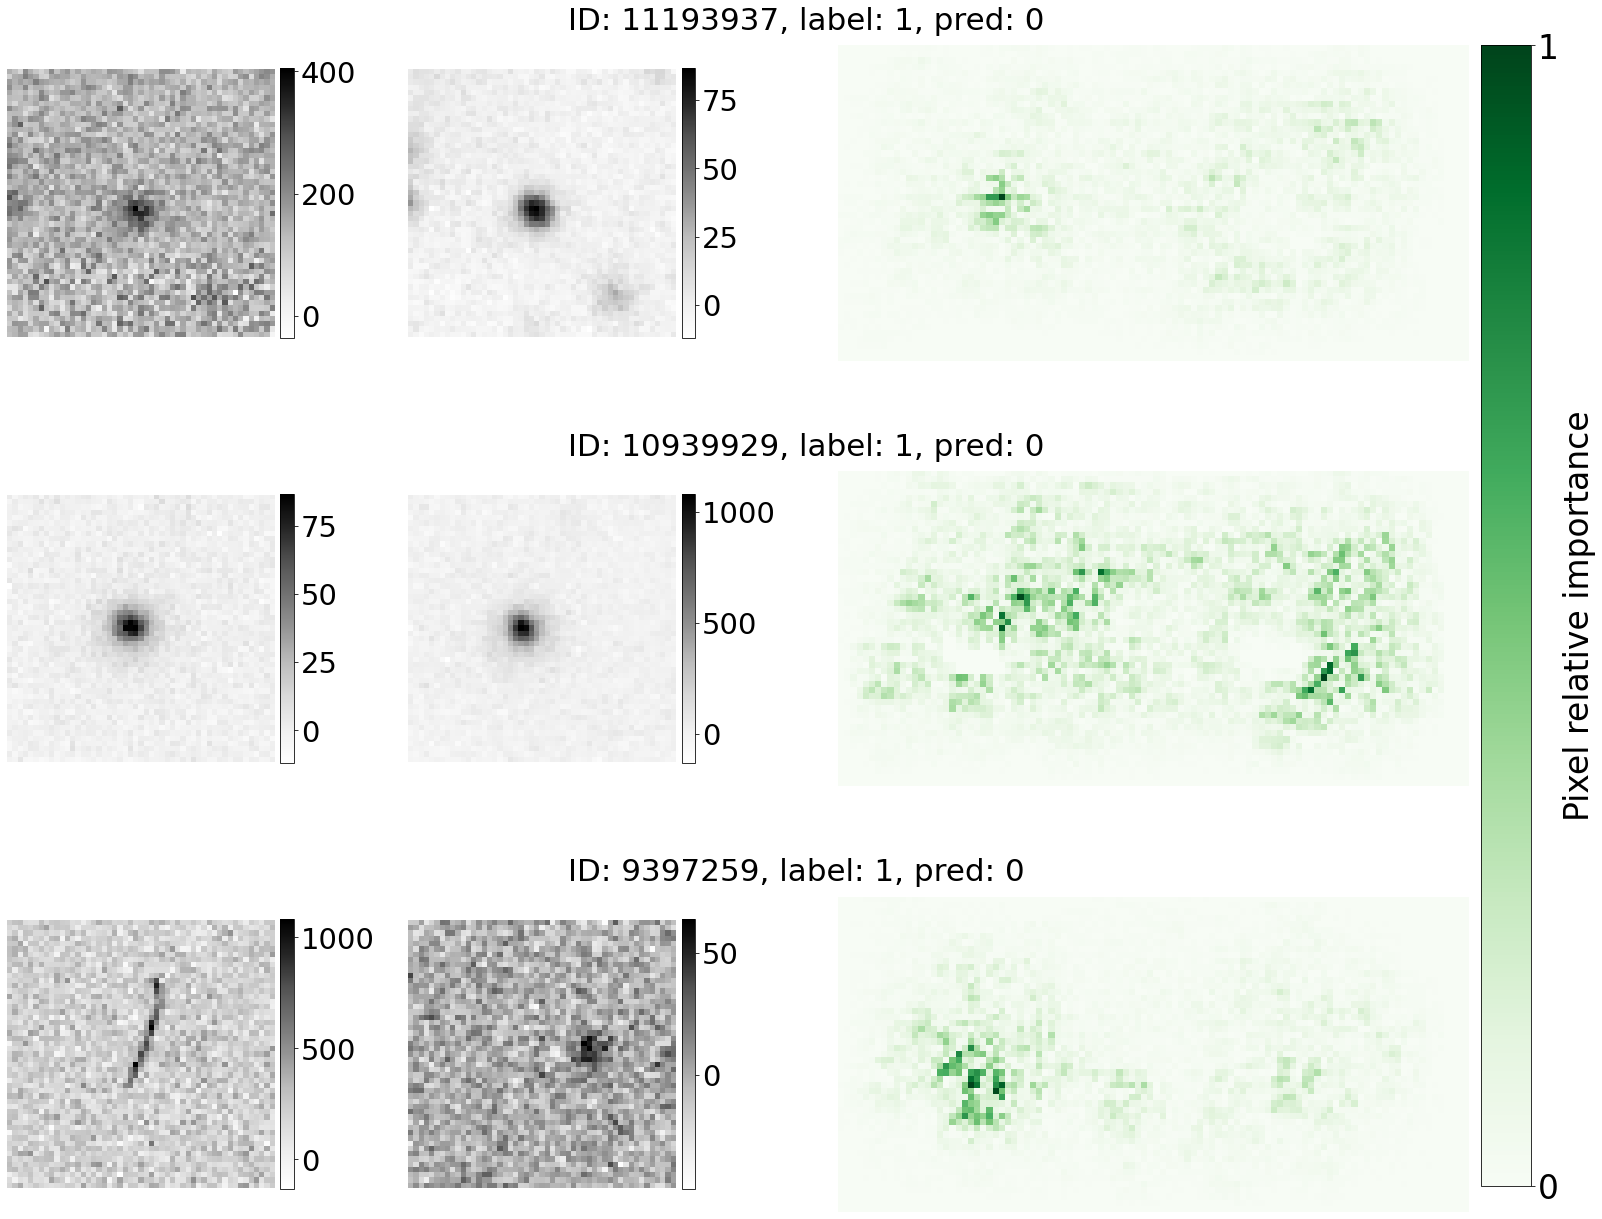

In [278]:
fig, ax = plt.subplots(3,4,figsize=(23,18))
fig.subplots_adjust(0.05, 0.05, 0.95, 0.95, 0.4, 0.35)

ids_over = vertical_concat_2DHp[(vertical_concat_2DHp["OBJECT_TYPE"] == 1) & (vertical_concat_2DHp["predicted"] == 0)]
# seed = 18
seed = 854
# for seed in [18, 854]:
np.random.seed(seed)
indexes = ids_over.sample(3).index
# print(indexes)
for jj,ii in enumerate(indexes): 
    index = np.where(np.char.find(flist3, str(int(ids_over.loc[ii]["ID"])))>=0)
    ax[jj,0] = plt.subplot2grid((3,4), (jj,0), colspan=1)
    ax[jj,0].axis("off")
    cmst1 = ax[jj,0].imshow(data_full[index[0][1]],cmap = "Greys", clim = (data_full[index[0][1]].min(),data_full[index[0][1]].max()))
    colorbar_srch = fig.colorbar(cmst2, ax = ax[jj, 0:1], fraction=0.047, pad=0.02)
    colorbar_srch.ax.tick_params(labelsize=29)
    ax[jj,1] = plt.subplot2grid((3,4), (jj,1), colspan=1)
    ax[jj,1].axis("off")
    cmst2 = ax[jj,1].imshow(data_full[index[0][2]],cmap = "Greys", clim = (data_full[index[0][2]].min(),data_full[index[0][2]].max()))
    colorbar_temp = fig.colorbar(cmst2, ax = ax[jj, 1:2], fraction=0.047, pad=0.02)
    colorbar_temp.ax.tick_params(labelsize=29)
    ax[jj,2].axis("off")
    ax[jj,1].text(30,-8,
                "ID: {}, label: {}, pred: {} ".format(int(ids_over.loc[ii]["ID"]), 
                                                      int(ids_over.loc[ii]["OBJECT_TYPE"]), int(ids_over.loc[ii]["predicted"])), 
                fontsize = 31)  
    if seed == 18:
        to_save_fig_2d[jj+12] = np.stack((data_full[index[0][0]], data_full[index[0][1]], data_full[index[0][2]]))
        to_save_ID_2d[jj+12] = ids_over.loc[ii]["ID"]
        to_save_label_2d[jj+12] = ids_over.loc[ii]["OBJECT_TYPE"]
        to_save_predic_2d[jj+12] = ids_over.loc[ii]["predicted"]

    if seed == 854:
        to_save_fig_2d[jj+15] = np.stack((data_full[index[0][0]], data_full[index[0][1]], data_full[index[0][2]]))
        to_save_ID_2d[jj+15] = ids_over.loc[ii]["ID"]
        to_save_label_2d[jj+15] = ids_over.loc[ii]["OBJECT_TYPE"]
        to_save_predic_2d[jj+15] = ids_over.loc[ii]["predicted"]
#     ax[jj,4].axis("off")

# gs2 = gridspec.GridSpecFromSubplotSpec(6, 1, subplot_spec=gs0[1])
for jj, ii in enumerate(indexes):
    ax = plt.subplot2grid((3,4), (jj,2), colspan=2)
    ax.axis("off")
    if seed == 18:
        to_save_salien_2d[jj+12] = dgrad_abs_2DH[ids_over[ids_over["ID"]==ids_over.loc[ii]["ID"]].index[0]]
    if seed == 854:
        to_save_salien_2d[jj+15] = dgrad_abs_2DH[ids_over[ids_over["ID"]==ids_over.loc[ii]["ID"]].index[0]]
    mm = ax.imshow(dgrad_abs_2DH[ids_over[ids_over["ID"]==ids_over.loc[ii]["ID"]].index[0]],cmap = "Greens",clim = (np.array(dgrad_abs_2DH[ids_over[ids_over["ID"]==ids_over.loc[ii]["ID"]].index[0]]).min(),np.array(dgrad_abs_2DH[ids_over[ids_over["ID"]==ids_over.loc[ii]["ID"]].index[0]]).max()))
    cax = fig.add_axes([0.94, 0.07, 0.03, 0.88])
    colorbar_sm = fig.colorbar(mm, cax = cax, ticks=[np.array(dgrad_abs_2DH[ids_over[ids_over["ID"]==ids_over.loc[ii]["ID"]].index[0]]).min(), np.array(dgrad_abs_2DH[ids_over[ids_over["ID"]==ids_over.loc[ii]["ID"]].index[0]]).max()], fraction=0.016, pad=0.02)
    colorbar_sm.ax.set_ylabel("Pixel relative importance", fontsize=33)
    colorbar_sm.ax.set_yticklabels(['0','1'])
    colorbar_sm.ax.tick_params(labelsize=33)

# plt.savefig("saliency_plot_other3nodiaFP-see{}.pdf".format(seed),bbox_inches ="tight")


10939929.0 0.0 1.0


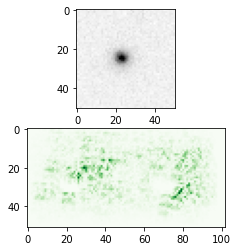

In [100]:
fig, ax = plt.subplots(2, 1)
ax[0].imshow(to_save_fig_2d[12][1], cmap = "Greys",) 
ax[1].imshow(to_save_salien_2d[12], cmap = "Greens",) 
           #clim = (to_save_fig[1][0].min(),to_save_fig[1][0].max()))
print(to_save_ID_2d[12], to_save_label_2d[9], to_save_predic_2d[9])

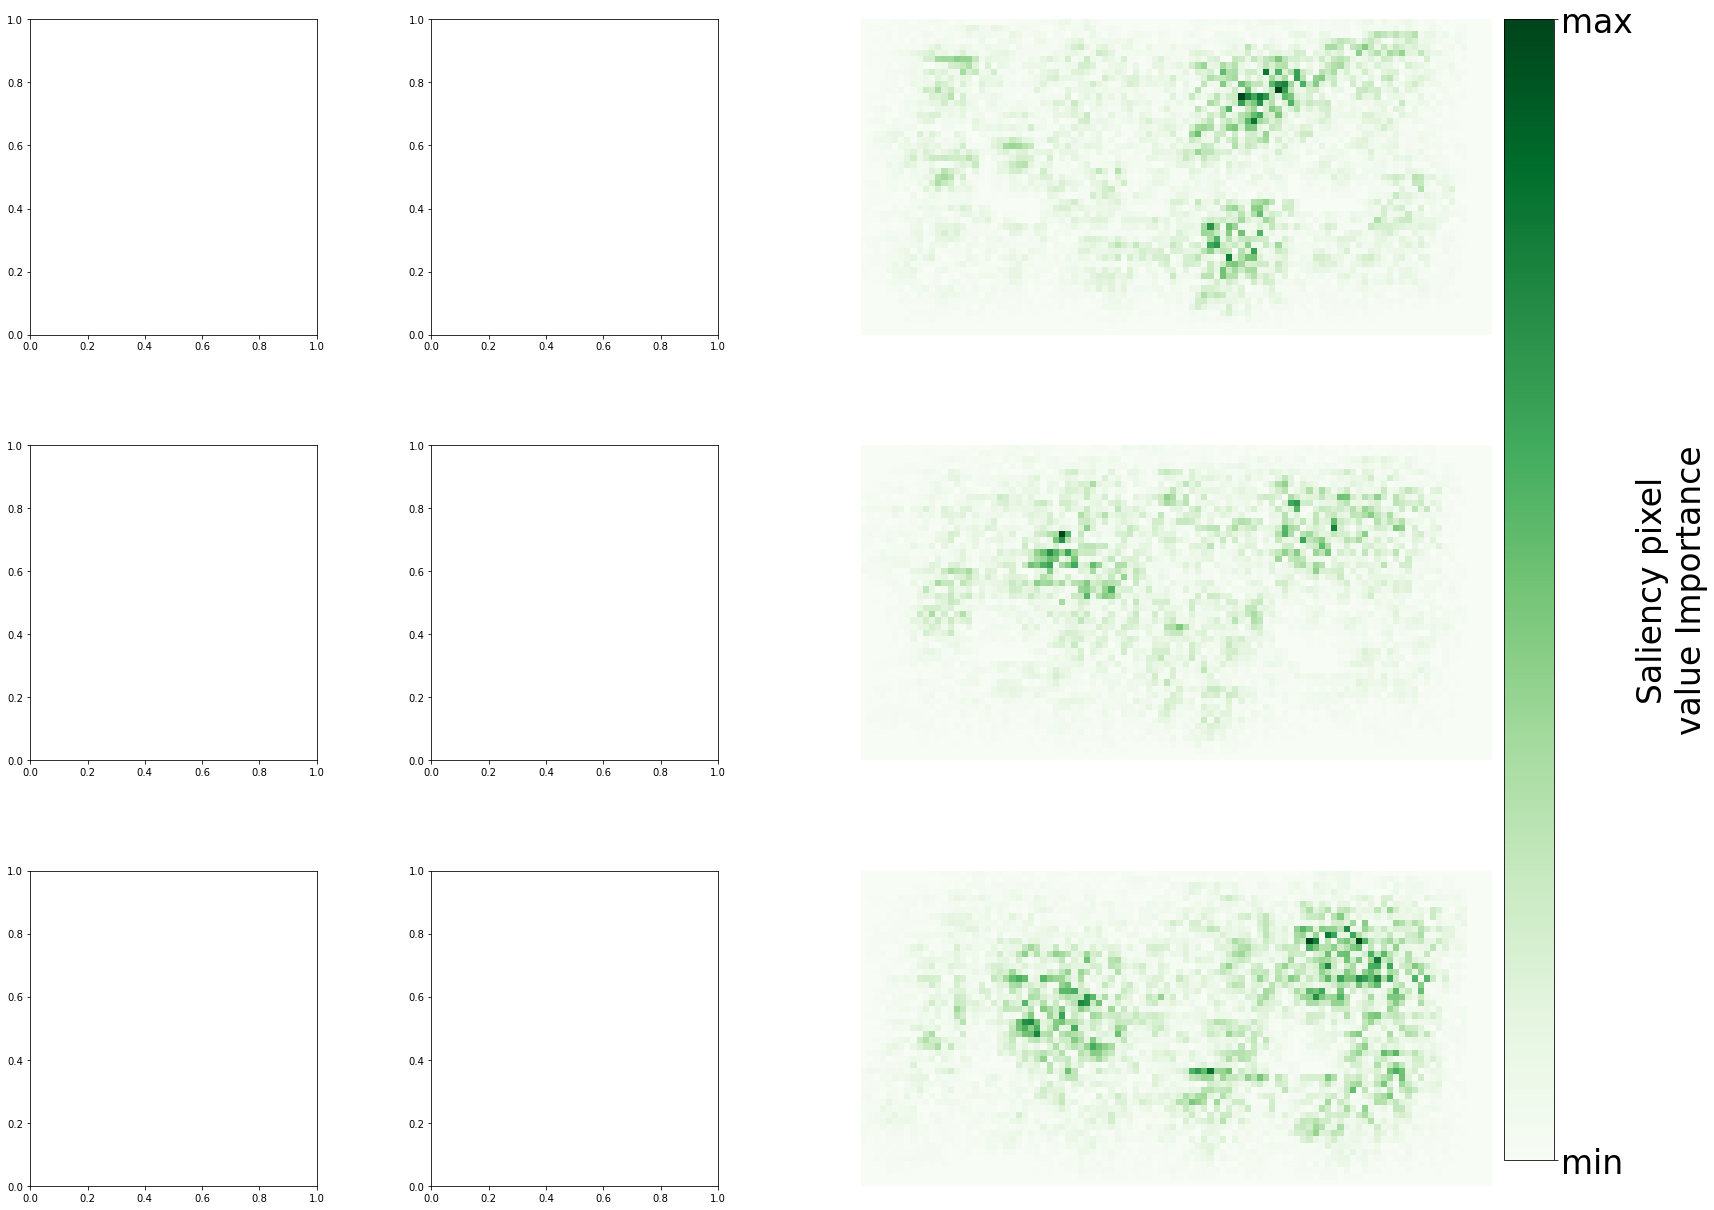

In [101]:
fig, ax = plt.subplots(3,4,figsize=(23,18))
fig.subplots_adjust(0.05, 0.05, 0.95, 0.95, 0.4, 0.35)

ids_over = vertical_concat_2DHp[(vertical_concat_2DHp["OBJECT_TYPE"] == 1) & (vertical_concat_2DHp["predicted"] == 1)]
for seed in [90, 4]:
    np.random.seed(seed)
    indexes = ids_over.sample(3).index
    # print(indexes)
    for jj,ii in enumerate(indexes): 
        index = np.where(np.char.find(flist3, str(int(ids_over.loc[ii]["ID"])))>=0)
#         ax[jj,0] = plt.subplot2grid((3,4), (jj,0), colspan=1)
#         ax[jj,0].axis("off")
#         cmst1 = ax[jj,0].imshow(data_full[index[0][1]],cmap = "Greys", clim = (data_full[index[0][1]].min(),data_full[index[0][1]].max()))
#         colorbar_srch = fig.colorbar(cmst2, ax = ax[jj, 0:1], fraction=0.047, pad=0.02)
#         colorbar_srch.ax.tick_params(labelsize=29)
#         ax[jj,1] = plt.subplot2grid((3,4), (jj,1), colspan=1)
#         ax[jj,1].axis("off")
#         cmst2 = ax[jj,1].imshow(data_full[index[0][2]],cmap = "Greys", clim = (data_full[index[0][2]].min(),data_full[index[0][2]].max()))
#         colorbar_temp = fig.colorbar(cmst2, ax = ax[jj, 1:2], fraction=0.047, pad=0.02)
#         colorbar_temp.ax.tick_params(labelsize=29)
#         ax[jj,2].axis("off")
#         ax[jj,1].text(30,-8,
#                     "ID: {}, label: {}, pred: {} ".format(int(ids_over.loc[ii]["ID"]), 
#                                                           int(ids_over.loc[ii]["OBJECT_TYPE"]), int(ids_over.loc[ii]["predicted"])), 
#                     fontsize = 31) 
        if seed == 90:
            to_save_fig_2d[jj+18] = np.stack((data_full[index[0][0]], data_full[index[0][1]], data_full[index[0][2]]))
            to_save_ID_2d[jj+18] = ids_over.loc[ii]["ID"]
            to_save_label_2d[jj+18] = ids_over.loc[ii]["OBJECT_TYPE"]
            to_save_predic_2d[jj+18] = ids_over.loc[ii]["predicted"]

        if seed == 4:
            to_save_fig_2d[jj+21] = np.stack((data_full[index[0][0]], data_full[index[0][1]], data_full[index[0][2]]))
            to_save_ID_2d[jj+21] = ids_over.loc[ii]["ID"]
            to_save_label_2d[jj+21] = ids_over.loc[ii]["OBJECT_TYPE"]
            to_save_predic_2d[jj+21] = ids_over.loc[ii]["predicted"]
    #     ax[jj,4].axis("off")

    # gs2 = gridspec.GridSpecFromSubplotSpec(6, 1, subplot_spec=gs0[1])
    for jj, ii in enumerate(indexes):
        ax = plt.subplot2grid((3,4), (jj,2), colspan=2)
        ax.axis("off")
        if seed == 90:
            to_save_salien_2d[jj+18] = dgrad_abs_2DH[ids_over[ids_over["ID"]==ids_over.loc[ii]["ID"]].index[0]]
        if seed == 4:
            to_save_salien_2d[jj+21] = dgrad_abs_2DH[ids_over[ids_over["ID"]==ids_over.loc[ii]["ID"]].index[0]]
        mm = ax.imshow(dgrad_abs_2DH[ids_over[ids_over["ID"]==ids_over.loc[ii]["ID"]].index[0]],cmap = "Greens",clim = (np.array(dgrad_abs_2DH[ids_over[ids_over["ID"]==ids_over.loc[ii]["ID"]].index[0]]).min(),np.array(dgrad_abs_2DH[ids_over[ids_over["ID"]==ids_over.loc[ii]["ID"]].index[0]]).max()))
        cax = fig.add_axes([0.94, 0.07, 0.03, 0.88])
        colorbar_sm = fig.colorbar(mm, cax = cax, ticks=[np.array(dgrad_abs_2DH[ids_over[ids_over["ID"]==ids_over.loc[ii]["ID"]].index[0]]).min(), np.array(dgrad_abs_2DH[ids_over[ids_over["ID"]==ids_over.loc[ii]["ID"]].index[0]]).max()], fraction=0.016, pad=0.02)
        colorbar_sm.ax.set_ylabel("Saliency pixel\nvalue Importance", fontsize=33)
        colorbar_sm.ax.set_yticklabels(['min','max'])
        colorbar_sm.ax.tick_params(labelsize=33)

#     plt.savefig("saliency_plot_other3nodiaFP-see18.pdf",bbox_inches ="tight")



11781559.0 0.0 0.0


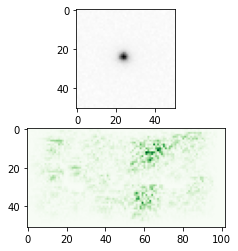

In [102]:
fig, ax = plt.subplots(2, 1)
ax[0].imshow(to_save_fig_2d[21][1], cmap = "Greys",) 
ax[1].imshow(to_save_salien_2d[21], cmap = "Greens",) 
           #clim = (to_save_fig[1][0].min(),to_save_fig[1][0].max()))
print(to_save_ID_2d[21], to_save_label_2d[1], to_save_predic_2d[1])

In [103]:
to_save_fig_2d.shape, to_save_salien_2d.shape

((24, 3, 51, 51), (24, 51, 102, 1))

In [104]:
np.save("fed_fig2d", to_save_fig_2d)
np.save("fed_ID2d", to_save_ID_2d)
np.save("fed_label2d", to_save_label_2d)
np.save("fed_pred2d", to_save_predic_2d)
np.save("fed_salien2d", to_save_salien_2d)

11036484.0 1.0 1.0


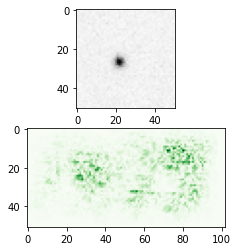

In [105]:
fig, ax = plt.subplots(2, 1)
ax[0].imshow(to_save_fig_2d[23][1], cmap = "Greys",) 
ax[1].imshow(to_save_salien_2d[23], cmap = "Greens",) 
           #clim = (to_save_fig[1][0].min(),to_save_fig[1][0].max()))
print(to_save_ID_2d[23], to_save_label_2d[23], to_save_predic_2d[23])

In [106]:
# fig, ax = plt.subplots(8, 4,figsize=(23,39))

# gs = gridspec.GridSpec(8, 4)#,left=1,right=1.5,top=1.4,bottom=1)
# np.random.seed(26)
# indexx = winner_concat.sample(8).index
# indexes = [0,1,2,3,4,5,6,7]
# for jj in range(8):
    
#     index = np.where(np.char.find(flist3, str(vertical_concat["ID"].to_numpy()[indexx[indexes[jj]]]))>=0)
# #     ax[jj,0] = plt.subplot(gs[jj, 0])
# #     cmst0 = ax[jj,0].imshow(data_full[index[0][0]],cmap = "Greys", clim = (data_full[index[0][0]].min(),data_full[index[0][0]].max()))
# #     ax[jj,0].imshow(data_full[index[0][0]],cmap = "Greys", clim = (data_full[index[0][0]].min(),data_full[index[0][0]].max()))
#     ax[jj,0] = plt.subplot(gs[jj, 0])
#     cmst1 = ax[jj,0].imshow(data_full[index[0][1]],cmap = "Greys", clim = (data_full[index[0][1]].min(),data_full[index[0][1]].max()))
#     contosrch = ax[jj,0].contour(data_full[index[0][1]], levels=[240, 500, 1000, 1600], colors='crimson', alpha=0.5)
#     ax[jj,1] = plt.subplot(gs[jj, 1])
#     cmst2 = ax[jj,1].imshow(data_full[index[0][2]],cmap = "Greys", clim = (data_full[index[0][2]].min(),data_full[index[0][2]].max()))
#     contotemp = ax[jj,1].contour(data_full[index[0][2]], levels=[240, 500, 1000, 1600], colors='crimson', alpha=0.5)
    
# #     if jj == 1:
# #         ax[jj,1].contour(data_full[index[0][2]], levels=[2000], colors='purple', alpha=0.5)
#     x1 = []
#     y1 = []
#     ll = 0
#     for ee in contotemp.collections:
#         ll = ll+1
#     for ii in range(ll):
#         if len(contotemp.collections[ii].get_paths()) != 0:
#             p1 = contotemp.collections[ii].get_paths()[0]
#             v1 = p1.vertices
#             x1.append(v1[:,0])
#             y1.append(v1[:,1])
#     ax[jj,2] = plt.subplot(gs[jj, 2:])
    
#     mm = ax[jj,2].imshow(dgrad_abs_2DH[indexx[indexes[jj]]],cmap = "Greens",clim = (np.array(dgrad_abs_2DH[indexx[indexes[jj]]]).min(),np.array(dgrad_abs_2DH[indexx[indexes[jj]]]).max()))
#     ax[jj,2].contour(data_full[index[0][1]], levels=[240, 500, 1000, 1600], colors='purple', alpha=0.5)
#     for ii in range(len(x1)):
#         ax[jj,2].plot(np.array(x1[ii])+51, np.array(y1[ii]), color='purple', alpha=0.5)
# #     ax[jj,2].contour(data_full[index[0][2]], levels=[240, 500, 1000, 1600], colors='red', alpha=0.5)
#     ax[jj,0].text(120,-4, 
#                     "ID: {}, label: {}, pred: {} ".format(int(test_ID[indexx[indexes[jj]]]), 
#                                                           int(test_targ[indexx[jj]]), df_te["predicted"][indexx[indexes[jj]]]), 
#                     fontsize = 18)
#     fig.colorbar(mm, ax = ax[jj,2],fraction=0.024, pad=0.02)
# #     fig.colorbar(cmst0, ax = ax[jj, 0],fraction=0.047)
#     fig.colorbar(cmst1, ax = ax[jj, 0],fraction=0.042, pad=0.02)
#     fig.colorbar(cmst2, ax = ax[jj, 0:2],fraction=0.022, pad=0.02)
    
# # ax[0, 0].text(-10, 27, "A", fontsize=21)
# # ax[1, 0].text(-10, 27, "B", fontsize=21)
# # ax[2, 0].text(-10, 27, "C", fontsize=21)

# # plt.savefig("saliency_plot_noDIA3exam_contour.pdf",bbox_inches ="tight")

In [107]:
vertical_concat_2DHp

,ID,OBJECT_TYPE,predicted_float_Real,predicted_float_Bogus,predicted,srch_gm,temp_gm
0,7956414,1,0.154537,0.845463,1,0.342667,0.657333
1,9152143,0,0.937056,0.062945,0,0.438832,0.561168
2,10595982,1,0.019109,0.980891,1,0.561979,0.438021
3,9482134,0,0.294298,0.705702,1,0.481386,0.518614
4,9238157,0,0.989753,0.010247,0,0.395021,0.604979
...,...,...,...,...,...,...,...
19995,8763685,1,0.016201,0.983799,1,0.473372,0.526628
19996,11377777,0,0.996489,0.003511,0,0.401482,0.598518
19997,9074085,1,0.006779,0.993221,1,0.401363,0.598637
19998,9398109,1,0.027539,0.972461,1,0.380557,0.619443


In [204]:
ids = [str(6960264), str(11872501), str(11873901), str(6962837), 
       str(11345377),str(8982164),str(8645524) ]
dfff0 = winner_concat_p[(winner_concat_p["ID"] == int(ids[0]))]
dfff1 = winner_concat_p[(winner_concat_p["ID"] == int(ids[1]))]
dfff2 = winner_concat_p[(winner_concat_p["ID"] == int(ids[2]))]
dfff3 = winner_concat_p[(winner_concat_p["ID"] == int(ids[3]))]
dfff4 = winner_concat_p[(winner_concat_p["ID"] == int(ids[4]))]
dfff5 = winner_concat_p[(winner_concat_p["ID"] == int(ids[5]))]
dfff6 = winner_concat_p[(winner_concat_p["ID"] == int(ids[6]))]

dfff= pd.concat((dfff0,dfff1,dfff2,dfff3,dfff4,dfff5,dfff6))
dfff["diff_gm"] = dfff["diff_gm"]*100
dfff["srch_gm"] = dfff["srch_gm"]*100
dfff["temp_gm"] = dfff["temp_gm"]*100

Text(0, 0.5, '% of importance of each section')

<Figure size 864x864 with 0 Axes>

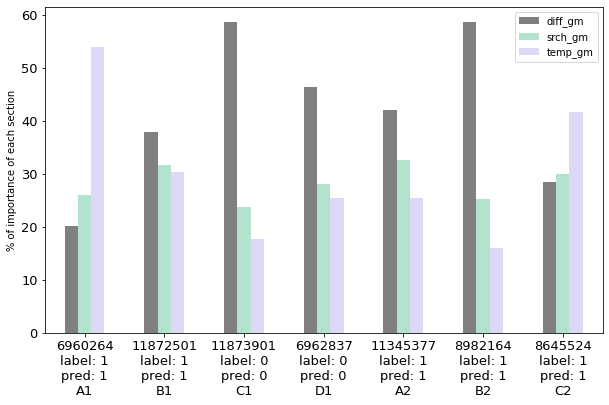

In [205]:
plt.figure(figsize=(12,12))
# indexes = ids_over.index
ids_over = dfff.astype({"ID": str}) 
ids_over_copy  = dfff[["ID", "diff_gm", "srch_gm","temp_gm"]]
ids_over_copy.set_index("ID",drop=True,inplace=True)

color_list = ["gray", "#b3e2cd","#ddd8f5"]
ax = ids_over_copy.plot.bar(color=color_list, figsize = (10,6))
ax.tick_params(axis='x', labelsize=13, rotation=360)
ax.tick_params(axis='y', labelsize=13)

enumeration = ["A1","B1","C1","D1","A2","B2","C2"]
ax.set_xticklabels([str(list(x)[0])+"\n"+"label:"+" "+str(list(x)[1])+"\n"+"pred:"+" "+str(list(x)[2]) +"\n"+str(list(x)[-1]) for x in zip(dfff["ID"], dfff["OBJECT_TYPE"],dfff["predicted"], enumeration)])

plt.xlabel("")
plt.ylabel("% of importance of each section")


# plt.savefig("histo_saliency_porcenta.pdf",bbox_inches ="tight" )

In [206]:
# ids_over_copy  = winner_concat_p[["ID", "diff_gm"]]
# ids_over_copy.set_index("ID",drop=True,inplace=True)

# # color_list = ["gray", "#b3e2cd","#ddd8f5"]
# ax = ids_over_copy.plot.bar(figsize = (10,6))

In [207]:
ids_over_copy  = winner_concat_p[["ID", "diff_gm"]]
ids_over_copy = ids_over_copy[ids_over_copy["diff_gm"] > 1/3]
ids_over_copy

,ID,diff_gm
1,9152143,0.544768
3,9482134,0.483067
4,9238157,0.584513
5,7866607,0.472442
7,9521980,0.577775
...,...,...
19647,8453234,0.350195
19756,10579756,0.358102
19829,10140455,0.380732
19834,10093742,0.336382


Text(0, 0.5, 'Count')

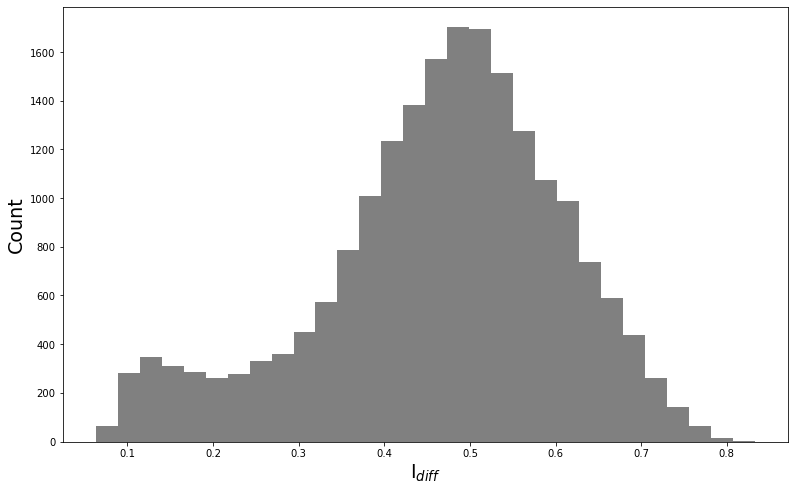

In [208]:
plt.figure(figsize = (13,8))
plt.hist(winner_concat_p["diff_gm"].to_numpy(), bins = 30, color="gray")
plt.xlabel(r"I$_{diff}$", fontsize = 19)
plt.ylabel("Count", fontsize = 19)

# plt.savefig("try_histogram_diff.pdf")

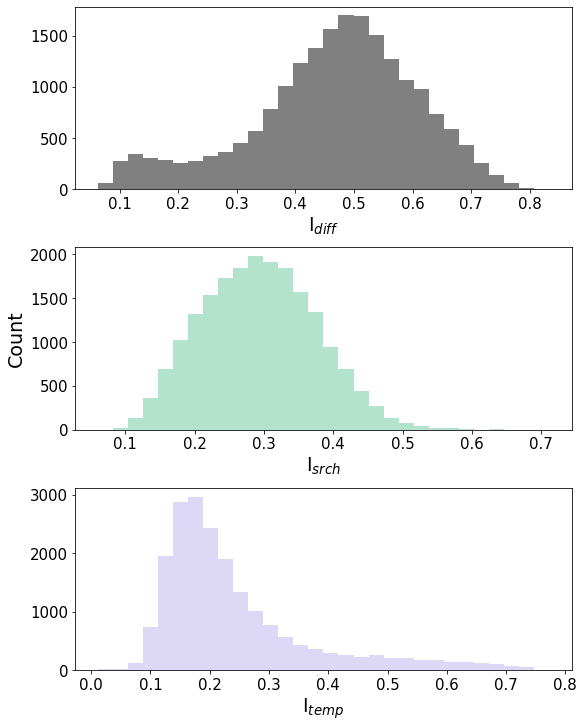

In [209]:
fig, ax = plt.subplots(3,1,figsize = (8,10),constrained_layout=True )

ax[0].hist(winner_concat_p["diff_gm"].to_numpy(), bins = 30, color="gray")
ax[0].set_xlabel(r"I$_{diff}$", fontsize = 19)
# ax[0].set_ylabel("Count", fontsize = 19)

ax[1].hist(winner_concat_p["srch_gm"].to_numpy(), bins = 30, color="#b3e2cd")
ax[1].set_xlabel(r"I$_{srch}$", fontsize = 19)
ax[1].set_ylabel("Count", fontsize = 19)

ax[2].hist(winner_concat_p["temp_gm"].to_numpy(), bins = 30, color="#ddd8f5")
ax[2].set_xlabel(r"I$_{temp}$", fontsize = 19)
# ax[2].set_ylabel("Count", fontsize = 19)

ax[0].tick_params(axis = 'both', which = 'major', labelsize = 15)
ax[1].tick_params(axis = 'both', which = 'major', labelsize = 15)
ax[2].tick_params(axis = 'both', which = 'major', labelsize = 15)

# plt.title("Count")
# plt.savefig("histogram_sm_important_pixels.pdf",bbox_inches ="tight" )


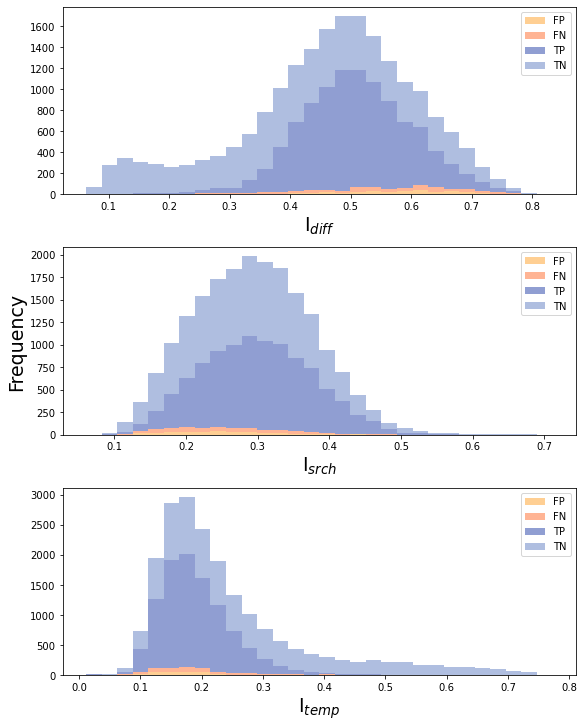

In [219]:
##014636 0,0 #04828c
##fff7fb
##d4d3e7
###1987a2 1,1 #6eabd0


##fbb3bb light pink
##49006a dark purple
##b70b83 dark pink
##fff7f3 white

# FNcolor = "#fbb3bb"
# TPcolor = "#49006a"
# TNcolor = "#b70b83"
# FPcolor = "#fff7f3"

# FNcolor = "#d4d3e7"
# TPcolor = "#04828c"
# TNcolor = "#6eabd0"
# FPcolor = "#fff7fb"


# # c1
# cooll = ['#eed9e2','#FF9AC8','#6eb8e4', '#04c1b1']
# FNcolor = cooll[1]
# TPcolor = cooll[3]
# TNcolor = cooll[2]
# FPcolor = cooll[0]


# # c2
# cooll = ['#CAB8FF','#B5DEFF','#FCFFA6', '#C1FFD7']
# FNcolor = cooll[1]
# TPcolor = cooll[3]
# TNcolor = cooll[2]
# FPcolor = cooll[0]

# # c3
# cooll = ['#B1FFFD','#A8E7E9','#EB92BE', '#FFEF78']
# FNcolor = cooll[1]
# TPcolor = cooll[3]
# TNcolor = cooll[2]
# FPcolor = cooll[0]

# # c4
# cooll = ['#FD6F96','#FFEBA1','#6F69AC', '#95DAC1']
# FNcolor = cooll[1]
# TPcolor = cooll[3]
# TNcolor = cooll[2]
# FPcolor = cooll[0]
# alp = 0.6

# c5
# cooll = ['#7F7C82','#BFA2DB','#F3F1F5', '#F0D9FF']
# FNcolor = cooll[1]
# TPcolor = cooll[3]
# TNcolor = cooll[2]
# FPcolor = cooll[0]
# alp = 0.6

# c6
# cooll = ['#444941','#5F7A61','#7FC8A9', '#D5EEBB']
FNcolor = cooll[1]
TPcolor = cooll[3]
TNcolor = cooll[2]
FPcolor = cooll[0]
alp = 0.6

# # c7
# cooll = ['#EFE3D0','#D9CAB3','#986D8E', '#87A8A4']
# FNcolor = cooll[1]
# TPcolor = cooll[3]
# TNcolor = cooll[2]
# FPcolor = cooll[0]
# alp = 0.6

# # c8
# cooll = ['#F38BA0','#FFBCBC','#B5EAEA', '#EDF6E5']
# FNcolor = cooll[1]
# TPcolor = cooll[3]
# TNcolor = cooll[2]
# FPcolor = cooll[0]
# alp = 0.6

# # c9
# cooll = ['#C490E4','#F6C6EA','#CDF0EA', '#F9F9F9']
# FNcolor = cooll[1]
# TPcolor = cooll[3]
# TNcolor = cooll[2]
# FPcolor = cooll[0]
# alp = 1

# # c10
# cooll = ['#D1D9D9','#F29191','#94D0CC', '#EEC4C4']
# FNcolor = cooll[1]
# TPcolor = cooll[3]
# TNcolor = cooll[2]
# FPcolor = cooll[0]
# alp = 1

# # c11
# cooll = ['#C490E4','#F6C6EA','#CDF0EA', '#F9F9F9']
# FNcolor = cooll[1]
# TPcolor = cooll[3]
# TNcolor = cooll[2]
# FPcolor = cooll[0]
# alp = 1



coloor = [FPcolor, FNcolor, TPcolor, TNcolor]
# reverse
# coloor = [TNcolor, TPcolor, FNcolor, FPcolor]


diff_TP = winner_concat_p[(winner_concat_p["OBJECT_TYPE"]==0)&(winner_concat_p["predicted"]==0)]
diff_TN = winner_concat_p[(winner_concat_p["OBJECT_TYPE"]==1)&(winner_concat_p["predicted"]==1)]
diff_FP = winner_concat_p[(winner_concat_p["OBJECT_TYPE"]==1)&(winner_concat_p["predicted"]==0)]
diff_FN = winner_concat_p[(winner_concat_p["OBJECT_TYPE"]==0)&(winner_concat_p["predicted"]==1)]

fig, ax = plt.subplots(3,1,figsize = (8,10),constrained_layout=True )
ax[0].hist([diff_FP["diff_gm"].to_numpy(),diff_FN["diff_gm"].to_numpy(),
            diff_TP["diff_gm"].to_numpy(), diff_TN["diff_gm"].to_numpy()], 
           bins = 30, color=coloor, alpha=alp,
           label = ["FP","FN","TP","TN"], stacked=True)
ax[0].set_xlabel(r"I$_{diff}$", fontsize = 19)

# ax[0].hist([diff_FP["diff_gm"].to_numpy(),diff_FN["diff_gm"].to_numpy(),
#             diff_TN["diff_gm"].to_numpy(),diff_TP["diff_gm"].to_numpy()], 
#            bins = 30, color=[FPcolor, FNcolor, TNcolor, TPcolor], alpha=0.5,
#            label = ["FP","FN","TN","TP"], stacked=True)
ax[0].legend()

ax[1].hist([diff_FP["srch_gm"].to_numpy(),diff_FN["srch_gm"].to_numpy(),
            diff_TP["srch_gm"].to_numpy(), diff_TN["srch_gm"].to_numpy()], 
           bins = 30, color=coloor, alpha=alp,
           label = ["FP","FN","TP","TN"], stacked=True)
# ax[1].hist([diff_FP["srch_gm"].to_numpy(),diff_FN["srch_gm"].to_numpy(),
#             diff_TN["srch_gm"].to_numpy(),diff_TP["srch_gm"].to_numpy()], 
#            bins = 30, color=[FPcolor, FNcolor, TNcolor, TPcolor], alpha=0.5,
#            label = ["FP","FN","TN","TP"], stacked=True)
ax[1].set_xlabel(r"I$_{srch}$", fontsize = 19)
ax[1].set_ylabel("Frequency", fontsize = 19)
ax[1].legend()


# ax[2].hist([diff_FP["temp_gm"].to_numpy(),diff_FN["temp_gm"].to_numpy(),
#             diff_TN["temp_gm"].to_numpy(),diff_TP["temp_gm"].to_numpy()], 
#            bins = 30, color=[FPcolor, FNcolor, TNcolor, TPcolor], alpha=0.5,
#            label = ["FP","FN","TN","TP"], stacked=True)

ax[2].hist([diff_FP["temp_gm"].to_numpy(),diff_FN["temp_gm"].to_numpy(),
            diff_TP["temp_gm"].to_numpy(), diff_TN["temp_gm"].to_numpy()], 
           bins = 30, color=coloor, alpha=alp,
           label = ["FP","FN","TP","TN"], stacked=True)

ax[2].set_xlabel(r"I$_{temp}$", fontsize = 19)
ax[2].legend()


# plt.savefig("histogram_sm_important_pixels_CM_2_1.pdf",bbox_inches ="tight" )


# Histogram saliency

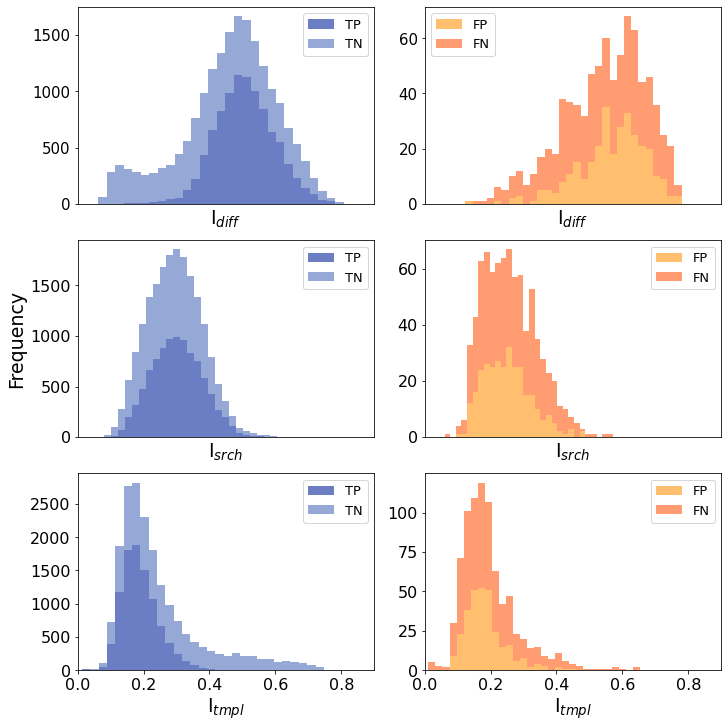

In [220]:
#cfed
# cooll = ['#ffb04b','#ff834d','#7b93cc','#4667b4']
FNcolor = cooll[1]
TPcolor = cooll[3]
TNcolor = cooll[2]
FPcolor = cooll[0]
alp = 0.8

coloor = [FPcolor, FNcolor, TPcolor, TNcolor]
# reverse
# coloor = [TNcolor, TPcolor, FNcolor, FPcolor]


diff_TP = winner_concat_p[(winner_concat_p["OBJECT_TYPE"]==0)&(winner_concat_p["predicted"]==0)]
diff_TN = winner_concat_p[(winner_concat_p["OBJECT_TYPE"]==1)&(winner_concat_p["predicted"]==1)]
diff_FP = winner_concat_p[(winner_concat_p["OBJECT_TYPE"]==1)&(winner_concat_p["predicted"]==0)]
diff_FN = winner_concat_p[(winner_concat_p["OBJECT_TYPE"]==0)&(winner_concat_p["predicted"]==1)]

fig, ax = plt.subplots(3,2,figsize = (10,10),constrained_layout=True )
ax[0,0].hist([diff_TP["diff_gm"].to_numpy(),diff_TN["diff_gm"].to_numpy()], 
           bins = 30, color=[TPcolor,TNcolor], alpha=alp,
           label = ["TP","TN"], stacked=True)
ax[0,1].hist([diff_FP["diff_gm"].to_numpy(),diff_FN["diff_gm"].to_numpy(),], 
           bins = 30, color=[FPcolor,FNcolor], alpha=alp,
           label = ["FP","FN"], stacked=True)
ax[0,0].set_xlabel(r"I$_{diff}$", fontsize = 19)
ax[0,0].legend(fontsize = 13)
ax[0,0].tick_params(axis='x', labelsize=15)
ax[0,0].tick_params(axis='y', labelsize=15)
ax[0,1].set_xlabel(r"I$_{diff}$", fontsize = 19)
ax[0,1].legend(loc='upper left', fontsize = 13)
ax[0,1].tick_params(axis='x', labelsize=15)
ax[0,1].tick_params(axis='y', labelsize=15)
ax[0,1].set_xlim(0.0, 0.9)
ax[0,0].set_xlim(0.0, 0.9)
ax[1,0].hist([diff_TP["srch_gm"].to_numpy(), diff_TN["srch_gm"].to_numpy()], 
           bins = 30, color=coloor[2:], alpha=alp,
           label = ["TP","TN"], stacked=True)
ax[1,1].hist([diff_FP["srch_gm"].to_numpy(),diff_FN["srch_gm"].to_numpy(),], 
           bins = 30, color=coloor[0:2], alpha=alp,
           label = ["FP","FN"], stacked=True)
ax[1,0].set_xlabel(r"I$_{srch}$", fontsize = 19)
ax[1,0].set_ylabel("Frequency", fontsize = 19)
ax[1,0].set_xlim(0.0, 0.9)
ax[1,0].legend(fontsize = 13)
ax[1,0].tick_params(axis='x', labelsize=16)
ax[1,0].tick_params(axis='y', labelsize=16)
ax[1,1].legend(loc='upper right', fontsize = 13)
ax[1,1].set_xlabel(r"I$_{srch}$", fontsize = 19)
ax[1,1].tick_params(axis='x', labelsize=16)
ax[1,1].tick_params(axis='y', labelsize=16)

ax[1,1].set_xlim(0.0, 0.9)
ax[1,1].set_xticks([])
ax[1,0].set_xticks([])
ax[0,1].set_xticks([])
ax[0,0].set_xticks([])



ax[2,0].hist([diff_TP["temp_gm"].to_numpy(), diff_TN["temp_gm"].to_numpy()], 
           bins = 30, color=coloor[2:], alpha=alp,
           label = ["TP","TN"], stacked=True)
ax[2,1].hist([diff_FP["temp_gm"].to_numpy(),diff_FN["temp_gm"].to_numpy(),], 
           bins = 30, color=coloor[0:2], alpha=alp,
           label = ["FP","FN"], stacked=True)
ax[2,0].set_xlabel(r"I$_{tmpl}$", fontsize = 19)
ax[2,0].legend(fontsize = 13)
ax[2,0].set_xlim(0.0, 0.9)
ax[2,0].tick_params(axis='x', labelsize=16)
ax[2,0].tick_params(axis='y', labelsize=16)
ax[2,1].legend(loc='upper right', fontsize = 13)
ax[2,1].set_xlabel(r"I$_{tmpl}$", fontsize = 19)
ax[2,1].tick_params(axis='x', labelsize=16)
ax[2,1].set_xlim(0.0, 0.9)
ax[2,1].tick_params(axis='y', labelsize=16)

plt.savefig("histogram_sm_important_pixels_fed_shared.pdf",bbox_inches ="tight" )



(0.0, 1.0, 0.0, 1.0)

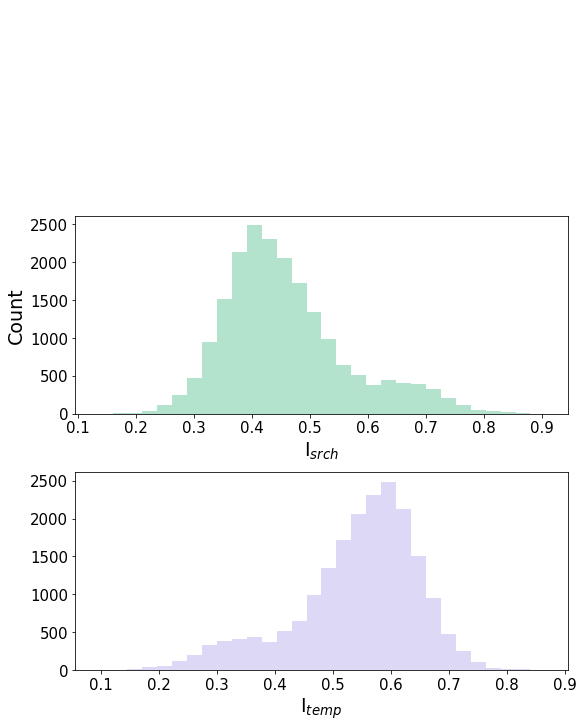

In [221]:
fig, ax = plt.subplots(3,1,figsize = (8,10),constrained_layout=True )

ax[1].hist(vertical_concat_2DHp["srch_gm"].to_numpy(), bins = 30, color="#b3e2cd")
ax[1].set_xlabel(r"I$_{srch}$", fontsize = 19)
# ax[0].set_ylabel("Count", fontsize = 19)

ax[2].hist(vertical_concat_2DHp["temp_gm"].to_numpy(), bins = 30, color="#ddd8f5")
ax[2].set_xlabel(r"I$_{temp}$", fontsize = 19)
ax[1].set_ylabel("Count", fontsize = 19)

# ax[2].hist(winner_concat_p["temp_gm"].to_numpy(), bins = 30, color="#ddd8f5")
# ax[2].set_xlabel(r"I$_{temp}$", fontsize = 19)
# ax[2].set_ylabel("Count", fontsize = 19)

ax[1].tick_params(axis = 'both', which = 'major', labelsize = 15)
ax[2].tick_params(axis = 'both', which = 'major', labelsize = 15)
ax[0].axis("off")
# ax[2].tick_params(axis = 'both', which = 'major', labelsize = 15)


# plt.savefig("histogram_sm_important_pixels_2d.pdf",bbox_inches ="tight" )

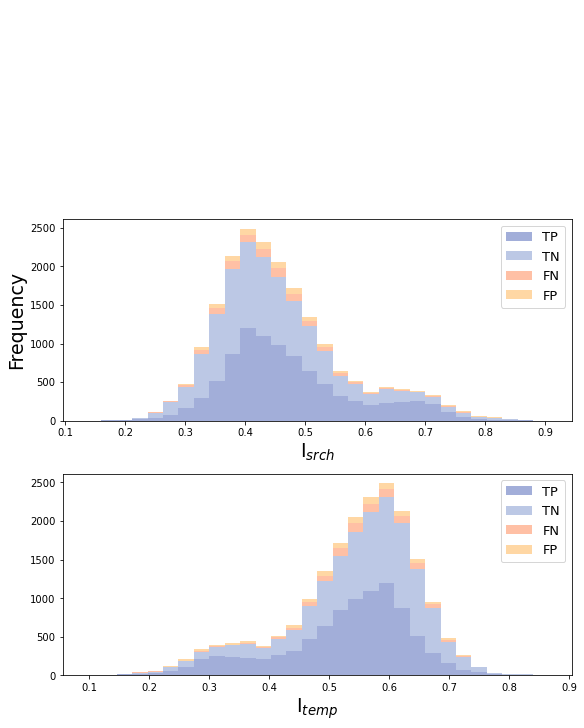

In [222]:
# cooll = ['#eed9e2','#FF9AC8','#6eb8e4', '#04c1b1']


FNcolor = cooll[1]
TPcolor = cooll[3]
TNcolor = cooll[2]
FPcolor = cooll[0]

diff_TP = vertical_concat_2DHp[(vertical_concat_2DHp["OBJECT_TYPE"]==0)&(vertical_concat_2DHp["predicted"]==0)]
diff_TN = vertical_concat_2DHp[(vertical_concat_2DHp["OBJECT_TYPE"]==1)&(vertical_concat_2DHp["predicted"]==1)]
diff_FP = vertical_concat_2DHp[(vertical_concat_2DHp["OBJECT_TYPE"]==1)&(vertical_concat_2DHp["predicted"]==0)]
diff_FN = vertical_concat_2DHp[(vertical_concat_2DHp["OBJECT_TYPE"]==0)&(vertical_concat_2DHp["predicted"]==1)]

fig, ax = plt.subplots(3,1,figsize = (8,10),constrained_layout=True )
ax[0].axis("off")
# # plt.hist(winner_concat_p["diff_gm"].to_numpy(), bins = 30, color="gray")
# ax[0].hist(diff_TP["diff_gm"].to_numpy(), bins = 30, color=TPcolor, alpha = 1, label = "TP")
# ax[0].hist(diff_TN["diff_gm"].to_numpy(), bins = 30, color=TNcolor, alpha = 0.6, label = "TN")
# ax[0].hist(diff_FP["diff_gm"].to_numpy(), bins = 30, color="white", alpha = 1, label = "FP")
# ax[0].hist(diff_FN["diff_gm"].to_numpy(), bins = 30, color=FNcolor, alpha = 0.6, label = "FN")
# ax[0].set_xlabel(r"I$_{diff}$", fontsize = 19)
# ax[0].legend()

ax[1].hist([diff_TP["srch_gm"].to_numpy(), diff_TN["srch_gm"].to_numpy(),
            diff_FN["srch_gm"].to_numpy(),diff_FP["srch_gm"].to_numpy()], 
           bins = 30, color=[TPcolor, TNcolor, FNcolor, FPcolor], alpha=0.5,
           label = ["TP","TN","FN","FP"], stacked=True)



# ax[1].hist(diff_TP["srch_gm"].to_numpy(), bins = 30, color=TPcolor, alpha = 1, label = "TP")
# ax[1].hist(diff_TN["srch_gm"].to_numpy(), bins = 30, color=TNcolor, alpha = 0.6, label = "TN")
# ax[1].hist(diff_FP["srch_gm"].to_numpy(), bins = 30, color="white", alpha = 1, label = "FP")
# ax[1].hist(diff_FN["srch_gm"].to_numpy(), bins = 30, color=FNcolor, alpha = 0.6, label = "FN")
ax[1].set_xlabel(r"I$_{srch}$", fontsize = 19)
ax[1].set_ylabel("Frequency", fontsize = 19)
ax[1].legend(fontsize = 13)

# ax[2].hist(diff_TP["temp_gm"].to_numpy(), bins = 30, color=TPcolor, alpha = 1, label = "TP")
# ax[2].hist(diff_TN["temp_gm"].to_numpy(), bins = 30, color=TNcolor, alpha = 0.6, label = "TN")
# ax[2].hist(diff_FP["temp_gm"].to_numpy(), bins = 30, color="white", alpha = 1, label = "FP")
# ax[2].hist(diff_FN["temp_gm"].to_numpy(), bins = 30, color=FNcolor, alpha = 0.6, label = "FN")

ax[2].hist([diff_TP["temp_gm"].to_numpy(), diff_TN["temp_gm"].to_numpy(),
            diff_FN["temp_gm"].to_numpy(),diff_FP["temp_gm"].to_numpy()], 
           bins = 30, color=[TPcolor, TNcolor, FNcolor, FPcolor], alpha=0.5,
           label = ["TP","TN","FN","FP"], stacked=True)

ax[2].set_xlabel(r"I$_{temp}$", fontsize = 19)
ax[2].legend(fontsize = 13)


plt.savefig("histogram_sm_important_pixels_2d_CM_2.pdf",bbox_inches ="tight" )



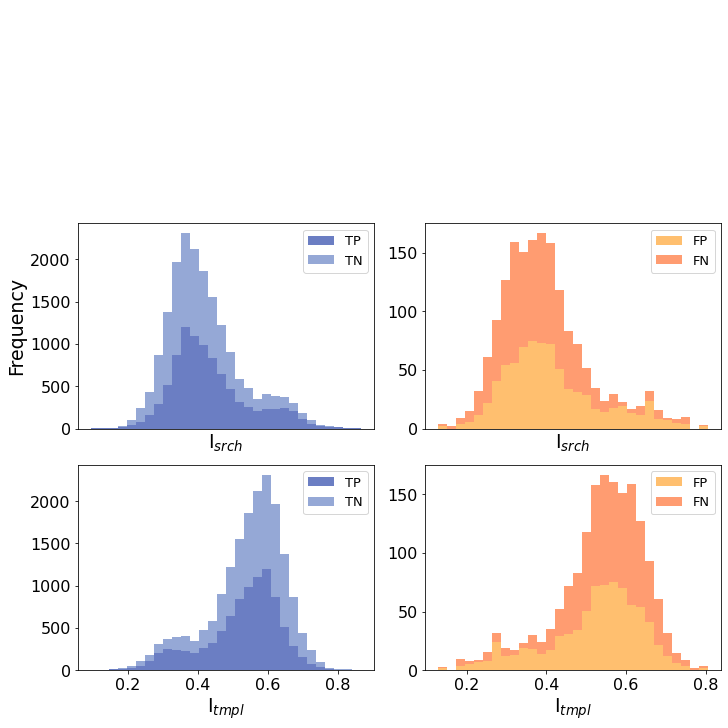

In [224]:
#cfed
# cooll = ['#ffb04b','#ff834d','#7b93cc','#4667b4']
FNcolor = cooll[1]
TPcolor = cooll[3]
TNcolor = cooll[2]
FPcolor = cooll[0]
alp = 0.8

coloor = [FPcolor, FNcolor, TPcolor, TNcolor]
# reverse
# coloor = [TNcolor, TPcolor, FNcolor, FPcolor]


diff_TP = vertical_concat_2DHp[(vertical_concat_2DHp["OBJECT_TYPE"]==0)&(vertical_concat_2DHp["predicted"]==0)]
diff_TN = vertical_concat_2DHp[(vertical_concat_2DHp["OBJECT_TYPE"]==1)&(vertical_concat_2DHp["predicted"]==1)]
diff_FP = vertical_concat_2DHp[(vertical_concat_2DHp["OBJECT_TYPE"]==1)&(vertical_concat_2DHp["predicted"]==0)]
diff_FN = vertical_concat_2DHp[(vertical_concat_2DHp["OBJECT_TYPE"]==0)&(vertical_concat_2DHp["predicted"]==1)]


fig, ax = plt.subplots(3,2,figsize = (10,10),constrained_layout=True )
# ax[0,0].hist([diff_TP["diff_gm"].to_numpy(),diff_TN["diff_gm"].to_numpy()], 
#            bins = 30, color=[TPcolor,TNcolor], alpha=alp,
#            label = ["TP","TN"], stacked=True)
# ax[0,1].hist([diff_FP["diff_gm"].to_numpy(),diff_FN["diff_gm"].to_numpy(),], 
#            bins = 30, color=[FPcolor,FNcolor], alpha=alp,
#            label = ["FP","FN"], stacked=True)
# ax[0,0].set_xlabel(r"I$_{diff}$", fontsize = 19)
# ax[0,0].legend()
# ax[0,1].set_xlabel(r"I$_{diff}$", fontsize = 19)
# ax[0,1].legend(loc='upper left')

ax[1,0].hist([diff_TP["srch_gm"].to_numpy(), diff_TN["srch_gm"].to_numpy()], 
           bins = 30, color=coloor[2:], alpha=alp,
           label = ["TP","TN"], stacked=True)
ax[1,1].hist([diff_FP["srch_gm"].to_numpy(),diff_FN["srch_gm"].to_numpy(),], 
           bins = 30, color=coloor[0:2], alpha=alp,
           label = ["FP","FN"], stacked=True)
ax[1,0].set_xlabel(r"I$_{srch}$", fontsize = 19)
ax[1,0].set_ylabel("Frequency", fontsize = 19)
ax[1,0].legend(fontsize = 13)
ax[1,0].tick_params(axis='x', labelsize=16)
ax[1,0].tick_params(axis='y', labelsize=16)
ax[1,1].legend(loc='upper right', fontsize = 13)
ax[1,1].set_xlabel(r"I$_{srch}$", fontsize = 19)
ax[1,1].tick_params(axis='x', labelsize=16)
ax[1,1].tick_params(axis='y', labelsize=16)

ax[0,0].axis("off")
ax[0,1].axis("off")
ax[1,1].set_xticks([])
ax[1,0].set_xticks([])


ax[2,0].hist([diff_TP["temp_gm"].to_numpy(), diff_TN["temp_gm"].to_numpy()], 
           bins = 30, color=coloor[2:], alpha=alp,
           label = ["TP","TN"], stacked=True)
ax[2,1].hist([diff_FP["temp_gm"].to_numpy(),diff_FN["temp_gm"].to_numpy(),], 
           bins = 30, color=coloor[0:2], alpha=alp,
           label = ["FP","FN"], stacked=True)
ax[2,0].set_xlabel(r"I$_{tmpl}$", fontsize = 19)
ax[2,0].legend(fontsize = 13)
ax[2,0].tick_params(axis='x', labelsize=16)
ax[2,0].tick_params(axis='y', labelsize=16)
ax[2,1].legend(loc='upper right', fontsize = 13)
ax[2,1].set_xlabel(r"I$_{tmpl}$", fontsize = 19)
ax[2,1].tick_params(axis='x', labelsize=16)
ax[2,1].tick_params(axis='y', labelsize=16)

plt.savefig("histogram_sm_important_pixels_2d_fed_shared.pdf",bbox_inches ="tight" )

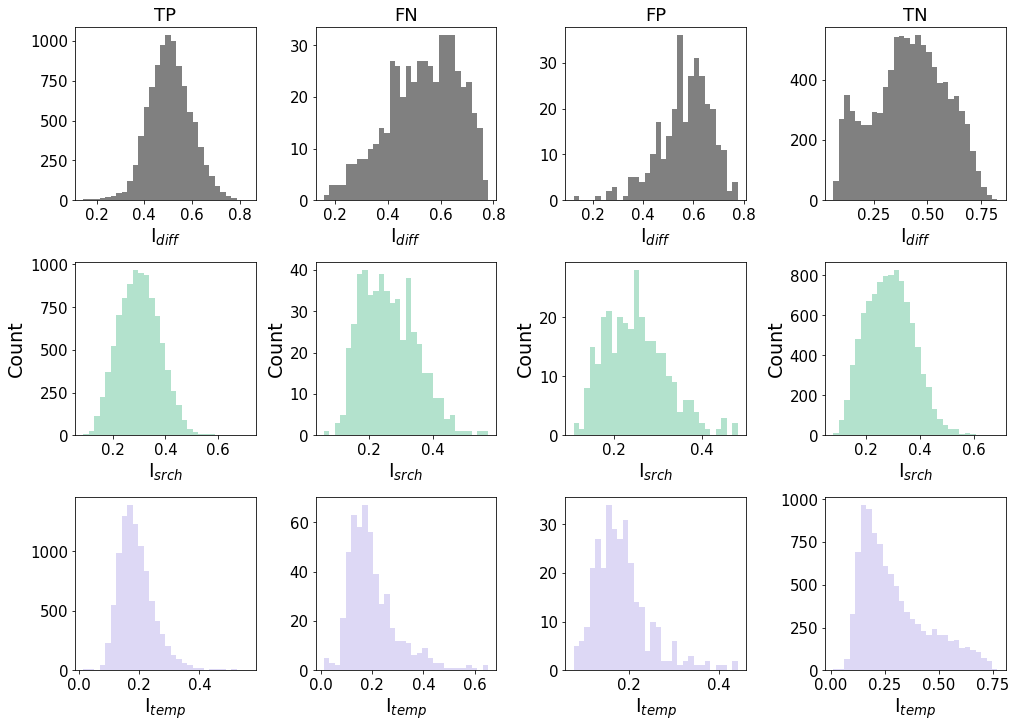

In [119]:
fig, ax = plt.subplots(3,4,figsize = (14,10),constrained_layout=True )

diff_TP = winner_concat_p[(winner_concat_p["OBJECT_TYPE"]==0)&(winner_concat_p["predicted"]==0)]

ax[0,0].hist(diff_TP["diff_gm"].to_numpy(), bins = 30, color="gray")
ax[0,0].set_xlabel(r"I$_{diff}$", fontsize = 19)
# ax[0].set_ylabel("Count", fontsize = 19)

ax[1,0].hist(diff_TP["srch_gm"].to_numpy(), bins = 30, color="#b3e2cd")
ax[1,0].set_xlabel(r"I$_{srch}$", fontsize = 19)
ax[1,0].set_ylabel("Count", fontsize = 19)

ax[2,0].hist(diff_TP["temp_gm"].to_numpy(), bins = 30, color="#ddd8f5")
ax[2,0].set_xlabel(r"I$_{temp}$", fontsize = 19)
# ax[2].set_ylabel("Count", fontsize = 19)

ax[0,0].tick_params(axis = 'both', which = 'major', labelsize = 15)
ax[1,0].tick_params(axis = 'both', which = 'major', labelsize = 15)
ax[2,0].tick_params(axis = 'both', which = 'major', labelsize = 15)

ax[0,0].set_title("TP", fontsize = 18)

diff_FN = winner_concat_p[(winner_concat_p["OBJECT_TYPE"]==0)&(winner_concat_p["predicted"]==1)]

ax[0,1].hist(diff_FN["diff_gm"].to_numpy(), bins = 30, color="gray")
ax[0,1].set_xlabel(r"I$_{diff}$", fontsize = 19)
# ax[0].set_ylabel("Count", fontsize = 19)

ax[1,1].hist(diff_FN["srch_gm"].to_numpy(), bins = 30, color="#b3e2cd")
ax[1,1].set_xlabel(r"I$_{srch}$", fontsize = 19)
ax[1,1].set_ylabel("Count", fontsize = 19)

ax[2,1].hist(diff_FN["temp_gm"].to_numpy(), bins = 30, color="#ddd8f5")
ax[2,1].set_xlabel(r"I$_{temp}$", fontsize = 19)
# ax[2].set_ylabel("Count", fontsize = 19)

ax[0,1].tick_params(axis = 'both', which = 'major', labelsize = 15)
ax[1,1].tick_params(axis = 'both', which = 'major', labelsize = 15)
ax[2,1].tick_params(axis = 'both', which = 'major', labelsize = 15)

ax[0,1].set_title("FN", fontsize = 18)

diff_FP = winner_concat_p[(winner_concat_p["OBJECT_TYPE"]==1)&(winner_concat_p["predicted"]==0)]

ax[0,2].hist(diff_FP["diff_gm"].to_numpy(), bins = 30, color="gray")
ax[0,2].set_xlabel(r"I$_{diff}$", fontsize = 19)
# ax[0].set_ylabel("Count", fontsize = 19)

ax[1,2].hist(diff_FP["srch_gm"].to_numpy(), bins = 30, color="#b3e2cd")
ax[1,2].set_xlabel(r"I$_{srch}$", fontsize = 19)
ax[1,2].set_ylabel("Count", fontsize = 19)

ax[2,2].hist(diff_FP["temp_gm"].to_numpy(), bins = 30, color="#ddd8f5")
ax[2,2].set_xlabel(r"I$_{temp}$", fontsize = 19)
# ax[2].set_ylabel("Count", fontsize = 19)

ax[0,2].tick_params(axis = 'both', which = 'major', labelsize = 15)
ax[1,2].tick_params(axis = 'both', which = 'major', labelsize = 15)
ax[2,2].tick_params(axis = 'both', which = 'major', labelsize = 15)

ax[0,2].set_title("FP", fontsize = 18)


diff_TN = winner_concat_p[(winner_concat_p["OBJECT_TYPE"]==1)&(winner_concat_p["predicted"]==1)]

ax[0,3].hist(diff_TN["diff_gm"].to_numpy(), bins = 30, color="gray")
ax[0,3].set_xlabel(r"I$_{diff}$", fontsize = 19)
# ax[0].set_ylabel("Count", fontsize = 19)

ax[1,3].hist(diff_TN["srch_gm"].to_numpy(), bins = 30, color="#b3e2cd")
ax[1,3].set_xlabel(r"I$_{srch}$", fontsize = 19)
ax[1,3].set_ylabel("Count", fontsize = 19)

ax[2,3].hist(diff_TN["temp_gm"].to_numpy(), bins = 30, color="#ddd8f5")
ax[2,3].set_xlabel(r"I$_{temp}$", fontsize = 19)
# ax[2].set_ylabel("Count", fontsize = 19)

ax[0,3].tick_params(axis = 'both', which = 'major', labelsize = 15)
ax[1,3].tick_params(axis = 'both', which = 'major', labelsize = 15)
ax[2,3].tick_params(axis = 'both', which = 'major', labelsize = 15)

ax[0,3].set_title("TN", fontsize = 18)

plt.savefig("CM_histo_sm_DIA.pdf",bbox_inches ="tight")

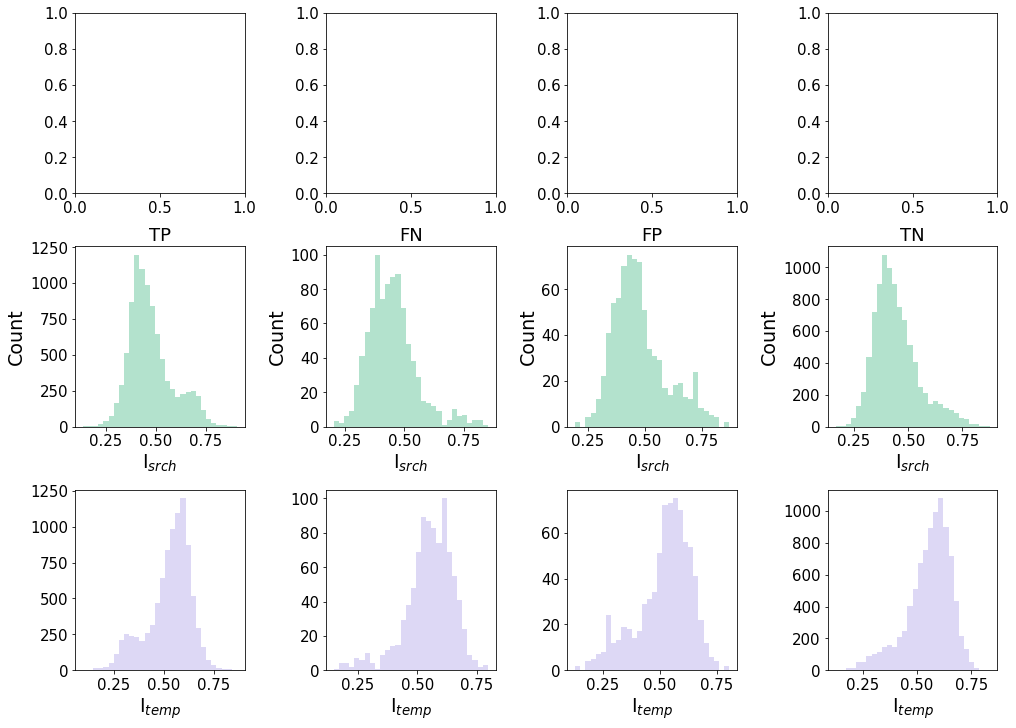

In [120]:
fig, ax = plt.subplots(3,4,figsize = (14,10),constrained_layout=True )

diff_TP = vertical_concat_2DHp[(vertical_concat_2DHp["OBJECT_TYPE"]==0)&(vertical_concat_2DHp["predicted"]==0)]

# ax[0,0].hist(diff_TP["diff_gm"].to_numpy(), bins = 30, color="gray")
# ax[0,0].set_xlabel(r"I$_{diff}$", fontsize = 19)
# # ax[0].set_ylabel("Count", fontsize = 19)

ax[1,0].hist(diff_TP["srch_gm"].to_numpy(), bins = 30, color="#b3e2cd")
ax[1,0].set_xlabel(r"I$_{srch}$", fontsize = 19)
ax[1,0].set_ylabel("Count", fontsize = 19)

ax[2,0].hist(diff_TP["temp_gm"].to_numpy(), bins = 30, color="#ddd8f5")
ax[2,0].set_xlabel(r"I$_{temp}$", fontsize = 19)
# ax[2].set_ylabel("Count", fontsize = 19)

ax[0,0].tick_params(axis = 'both', which = 'major', labelsize = 15)
ax[1,0].tick_params(axis = 'both', which = 'major', labelsize = 15)
ax[2,0].tick_params(axis = 'both', which = 'major', labelsize = 15)

ax[1,0].set_title("TP", fontsize = 18)

diff_FN = vertical_concat_2DHp[(vertical_concat_2DHp["OBJECT_TYPE"]==0)&(vertical_concat_2DHp["predicted"]==1)]

# ax[0,1].hist(diff_FN["diff_gm"].to_numpy(), bins = 30, color="gray")
# ax[0,1].set_xlabel(r"I$_{diff}$", fontsize = 19)
# # ax[0].set_ylabel("Count", fontsize = 19)

ax[1,1].hist(diff_FN["srch_gm"].to_numpy(), bins = 30, color="#b3e2cd")
ax[1,1].set_xlabel(r"I$_{srch}$", fontsize = 19)
ax[1,1].set_ylabel("Count", fontsize = 19)

ax[2,1].hist(diff_FN["temp_gm"].to_numpy(), bins = 30, color="#ddd8f5")
ax[2,1].set_xlabel(r"I$_{temp}$", fontsize = 19)
# ax[2].set_ylabel("Count", fontsize = 19)

ax[0,1].tick_params(axis = 'both', which = 'major', labelsize = 15)
ax[1,1].tick_params(axis = 'both', which = 'major', labelsize = 15)
ax[2,1].tick_params(axis = 'both', which = 'major', labelsize = 15)

ax[1,1].set_title("FN", fontsize = 18)

diff_FP = vertical_concat_2DHp[(vertical_concat_2DHp["OBJECT_TYPE"]==1)&(vertical_concat_2DHp["predicted"]==0)]

# ax[0,2].hist(diff_FP["diff_gm"].to_numpy(), bins = 30, color="gray")
# ax[0,2].set_xlabel(r"I$_{diff}$", fontsize = 19)
# # ax[0].set_ylabel("Count", fontsize = 19)

ax[1,2].hist(diff_FP["srch_gm"].to_numpy(), bins = 30, color="#b3e2cd")
ax[1,2].set_xlabel(r"I$_{srch}$", fontsize = 19)
ax[1,2].set_ylabel("Count", fontsize = 19)

ax[2,2].hist(diff_FP["temp_gm"].to_numpy(), bins = 30, color="#ddd8f5")
ax[2,2].set_xlabel(r"I$_{temp}$", fontsize = 19)
# ax[2].set_ylabel("Count", fontsize = 19)

ax[0,2].tick_params(axis = 'both', which = 'major', labelsize = 15)
ax[1,2].tick_params(axis = 'both', which = 'major', labelsize = 15)
ax[2,2].tick_params(axis = 'both', which = 'major', labelsize = 15)

ax[1,2].set_title("FP", fontsize = 18)


diff_TN = vertical_concat_2DHp[(vertical_concat_2DHp["OBJECT_TYPE"]==1)&(vertical_concat_2DHp["predicted"]==1)]

# ax[0,3].hist(diff_TN["diff_gm"].to_numpy(), bins = 30, color="gray")
# ax[0,3].set_xlabel(r"I$_{diff}$", fontsize = 19)
# # ax[0].set_ylabel("Count", fontsize = 19)

ax[1,3].hist(diff_TN["srch_gm"].to_numpy(), bins = 30, color="#b3e2cd")
ax[1,3].set_xlabel(r"I$_{srch}$", fontsize = 19)
ax[1,3].set_ylabel("Count", fontsize = 19)

ax[2,3].hist(diff_TN["temp_gm"].to_numpy(), bins = 30, color="#ddd8f5")
ax[2,3].set_xlabel(r"I$_{temp}$", fontsize = 19)
# ax[2].set_ylabel("Count", fontsize = 19)

ax[0,3].tick_params(axis = 'both', which = 'major', labelsize = 15)
ax[1,3].tick_params(axis = 'both', which = 'major', labelsize = 15)
ax[2,3].tick_params(axis = 'both', which = 'major', labelsize = 15)

ax[1,3].set_title("TN", fontsize = 18)


plt.savefig("CM_histo_sm_noDIA.pdf",bbox_inches ="tight")

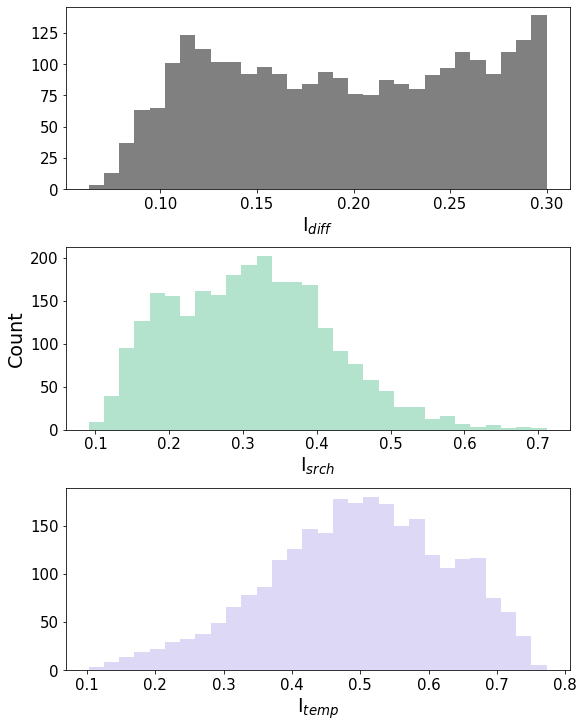

In [121]:
df = winner_concat_p[winner_concat_p["diff_gm"] < 0.3]

fig, ax = plt.subplots(3,1,figsize = (8,10),constrained_layout=True )

ax[0].hist(df["diff_gm"].to_numpy(), bins = 30, color="gray")
ax[0].set_xlabel(r"I$_{diff}$", fontsize = 19)
# ax[0].set_ylabel("Count", fontsize = 19)

ax[1].hist(df["srch_gm"].to_numpy(), bins = 30, color="#b3e2cd")
ax[1].set_xlabel(r"I$_{srch}$", fontsize = 19)
ax[1].set_ylabel("Count", fontsize = 19)

ax[2].hist(df["temp_gm"].to_numpy(), bins = 30, color="#ddd8f5")
ax[2].set_xlabel(r"I$_{temp}$", fontsize = 19)
# ax[2].set_ylabel("Count", fontsize = 19)

ax[0].tick_params(axis = 'both', which = 'major', labelsize = 15)
ax[1].tick_params(axis = 'both', which = 'major', labelsize = 15)
ax[2].tick_params(axis = 'both', which = 'major', labelsize = 15)


In [122]:
CM_sectionTP = df[(df["OBJECT_TYPE"] == 0) & (df["predicted"] == 0)]
CM_sectionTP["CM"] = ["TP"]*len(CM_sectionTP)

CM_sectionFN = df[(df["OBJECT_TYPE"] == 0) & (df["predicted"] == 1)]
CM_sectionFN["CM"] = ["FN"]*len(CM_sectionFN)

CM_sectionFP = df[(df["OBJECT_TYPE"] == 1) & (df["predicted"] == 0)]
CM_sectionFP["CM"] = ["FP"]*len(CM_sectionFP)

CM_sectionTN = df[(df["OBJECT_TYPE"] == 1) & (df["predicted"] == 1)]
CM_sectionTN["CM"] = ["TN"]*len(CM_sectionTN)

CM_concat = pd.concat([CM_sectionTP, CM_sectionFN, 
                       CM_sectionFP, CM_sectionTN], axis=0)

CM_concat

/global/homes/t/taceroc/.conda/envs/tff1/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/global/homes/t/taceroc/.conda/envs/tff1/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/global/homes/t/taceroc/.conda/envs/tff1/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

,ID,OBJECT_TYPE,predicted_float_Real,predicted_float_Bogus,predicted,diff_gm,srch_gm,temp_gm,winner_gm,CM
1432,11077666,0,0.999946,0.000054,0,0.280657,0.507472,0.211871,srch_gm,TP
2092,9180166,0,0.976994,0.023006,0,0.292042,0.434096,0.273861,srch_gm,TP
2302,7870911,0,0.999846,0.000154,0,0.211648,0.447817,0.340535,srch_gm,TP
2585,8560407,0,0.998757,0.001243,0,0.239301,0.501244,0.259455,srch_gm,TP
2861,9165878,0,0.988003,0.011997,0,0.295862,0.464356,0.239782,srch_gm,TP
...,...,...,...,...,...,...,...,...,...,...
19970,8821467,1,0.001871,0.998128,1,0.129603,0.146487,0.723909,temp_gm,TN
19988,8672914,1,0.069875,0.930125,1,0.258593,0.172082,0.569324,temp_gm,TN
19992,11246931,1,0.001162,0.998838,1,0.160675,0.166982,0.672343,temp_gm,TN
19997,9074085,1,0.001877,0.998123,1,0.182049,0.218464,0.599487,temp_gm,TN


In [123]:
listcm = CM_concat["CM"].to_numpy()
np.unique(listcm, return_counts=True)

(array(['FN', 'FP', 'TN', 'TP'], dtype=object),
 array([  31,    7, 2452,  123]))

In [124]:
winner_concat_p

,ID,OBJECT_TYPE,predicted_float_Real,predicted_float_Bogus,predicted,diff_gm,srch_gm,temp_gm,winner_gm
1,9152143,0,0.998243,0.001757,0,0.544768,0.245864,0.209368,diff_gm
3,9482134,0,0.949635,0.050365,0,0.483067,0.348483,0.168450,diff_gm
4,9238157,0,0.987749,0.012251,0,0.584513,0.275825,0.139662,diff_gm
5,7866607,0,0.862022,0.137978,0,0.472442,0.358310,0.169248,diff_gm
7,9521980,1,0.016729,0.983271,1,0.577775,0.190066,0.232160,diff_gm
...,...,...,...,...,...,...,...,...,...
19988,8672914,1,0.069875,0.930125,1,0.258593,0.172082,0.569324,temp_gm
19992,11246931,1,0.001162,0.998838,1,0.160675,0.166982,0.672343,temp_gm
19995,8763685,1,0.015234,0.984766,1,0.313303,0.288465,0.398232,temp_gm
19997,9074085,1,0.001877,0.998123,1,0.182049,0.218464,0.599487,temp_gm


In [125]:
CM_sectionTP = winner_concat_p[(winner_concat_p["OBJECT_TYPE"] == 0) & (winner_concat_p["predicted"] == 0)]
CM_sectionTP["CM"] = ["TP"]*len(CM_sectionTP)

CM_sectionFN = winner_concat_p[(winner_concat_p["OBJECT_TYPE"] == 0) & (winner_concat_p["predicted"] == 1)]
CM_sectionFN["CM"] = ["FN"]*len(CM_sectionFN)

CM_sectionFP = winner_concat_p[(winner_concat_p["OBJECT_TYPE"] == 1) & (winner_concat_p["predicted"] == 0)]
CM_sectionFP["CM"] = ["FP"]*len(CM_sectionFP)

CM_sectionTN = winner_concat_p[(winner_concat_p["OBJECT_TYPE"] == 1) & (winner_concat_p["predicted"] == 1)]
CM_sectionTN["CM"] = ["TN"]*len(CM_sectionTN)

CM_concat = pd.concat([CM_sectionTP, CM_sectionFN, 
                       CM_sectionFP, CM_sectionTN], axis=0)

CM_concat = CM_concat.sort_index(ascending=True)
CM_concat.to_csv('CM_concat.csv' )
CM_concat

/global/homes/t/taceroc/.conda/envs/tff1/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/global/homes/t/taceroc/.conda/envs/tff1/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/global/homes/t/taceroc/.conda/envs/tff1/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

,ID,OBJECT_TYPE,predicted_float_Real,predicted_float_Bogus,predicted,diff_gm,srch_gm,temp_gm,winner_gm,CM
0,7956414,1,0.006086,0.993914,1,0.121605,0.187658,0.690737,temp_gm,TN
1,9152143,0,0.998243,0.001757,0,0.544768,0.245864,0.209368,diff_gm,TP
2,10595982,1,0.017558,0.982442,1,0.196361,0.557956,0.245683,srch_gm,TN
3,9482134,0,0.949635,0.050365,0,0.483067,0.348483,0.168450,diff_gm,TP
4,9238157,0,0.987749,0.012251,0,0.584513,0.275825,0.139662,diff_gm,TP
...,...,...,...,...,...,...,...,...,...,...
19995,8763685,1,0.015234,0.984766,1,0.313303,0.288465,0.398232,temp_gm,TN
19996,11377777,0,0.999956,0.000044,0,0.552487,0.248817,0.198696,diff_gm,TP
19997,9074085,1,0.001877,0.998123,1,0.182049,0.218464,0.599487,temp_gm,TN
19998,9398109,1,0.016119,0.983881,1,0.149113,0.367960,0.482927,temp_gm,TN


In [126]:
vertical_concat_2DHp
srch_winner_2DHp = vertical_concat_2DHp[(vertical_concat_2DHp["srch_gm"]>vertical_concat_2DHp["temp_gm"])]
srch_winner_2DHp["winner"] = ["srch_gm"]*len(srch_winner_2DHp)
temp_winner_2DHp = vertical_concat_2DHp[(vertical_concat_2DHp["temp_gm"]>vertical_concat_2DHp["srch_gm"])]
temp_winner_2DHp["winner"] = ["temp_gm"]*len(temp_winner_2DHp)

winner_concat_2DHp = pd.concat([srch_winner_2DHp, temp_winner_2DHp], axis=0)
winner_concat_2DHp = winner_concat_2DHp.sort_index(ascending=True)
winner_concat_2DHp

/global/homes/t/taceroc/.conda/envs/tff1/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/global/homes/t/taceroc/.conda/envs/tff1/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,ID,OBJECT_TYPE,predicted_float_Real,predicted_float_Bogus,predicted,srch_gm,temp_gm,winner
0,7956414,1,0.154537,0.845463,1,0.342667,0.657333,temp_gm
1,9152143,0,0.937056,0.062945,0,0.438832,0.561168,temp_gm
2,10595982,1,0.019109,0.980891,1,0.561979,0.438021,srch_gm
3,9482134,0,0.294298,0.705702,1,0.481386,0.518614,temp_gm
4,9238157,0,0.989753,0.010247,0,0.395021,0.604979,temp_gm
...,...,...,...,...,...,...,...,...
19995,8763685,1,0.016201,0.983799,1,0.473372,0.526628,temp_gm
19996,11377777,0,0.996489,0.003511,0,0.401482,0.598518,temp_gm
19997,9074085,1,0.006779,0.993221,1,0.401363,0.598637,temp_gm
19998,9398109,1,0.027539,0.972461,1,0.380557,0.619443,temp_gm


In [127]:
CM_sectionTP = winner_concat_2DHp[(winner_concat_2DHp["OBJECT_TYPE"] == 0) & (winner_concat_2DHp["predicted"] == 0)]
CM_sectionTP["CM"] = ["TP"]*len(CM_sectionTP)

CM_sectionFN = winner_concat_2DHp[(winner_concat_2DHp["OBJECT_TYPE"] == 0) & (winner_concat_2DHp["predicted"] == 1)]
CM_sectionFN["CM"] = ["FN"]*len(CM_sectionFN)

CM_sectionFP = winner_concat_2DHp[(winner_concat_2DHp["OBJECT_TYPE"] == 1) & (winner_concat_2DHp["predicted"] == 0)]
CM_sectionFP["CM"] = ["FP"]*len(CM_sectionFP)

CM_sectionTN = winner_concat_2DHp[(winner_concat_2DHp["OBJECT_TYPE"] == 1) & (winner_concat_2DHp["predicted"] == 1)]
CM_sectionTN["CM"] = ["TN"]*len(CM_sectionTN)

CM_concat_2DH = pd.concat([CM_sectionTP, CM_sectionFN, 
                       CM_sectionFP, CM_sectionTN], axis=0)
CM_concat_2DH = CM_concat_2DH.sort_index(ascending=True)

CM_concat_2DH.to_csv('CM_concat_2DH.csv')
CM_concat_2DH

/global/homes/t/taceroc/.conda/envs/tff1/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/global/homes/t/taceroc/.conda/envs/tff1/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/global/homes/t/taceroc/.conda/envs/tff1/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

,ID,OBJECT_TYPE,predicted_float_Real,predicted_float_Bogus,predicted,srch_gm,temp_gm,winner,CM
0,7956414,1,0.154537,0.845463,1,0.342667,0.657333,temp_gm,TN
1,9152143,0,0.937056,0.062945,0,0.438832,0.561168,temp_gm,TP
2,10595982,1,0.019109,0.980891,1,0.561979,0.438021,srch_gm,TN
3,9482134,0,0.294298,0.705702,1,0.481386,0.518614,temp_gm,FN
4,9238157,0,0.989753,0.010247,0,0.395021,0.604979,temp_gm,TP
...,...,...,...,...,...,...,...,...,...
19995,8763685,1,0.016201,0.983799,1,0.473372,0.526628,temp_gm,TN
19996,11377777,0,0.996489,0.003511,0,0.401482,0.598518,temp_gm,TP
19997,9074085,1,0.006779,0.993221,1,0.401363,0.598637,temp_gm,TN
19998,9398109,1,0.027539,0.972461,1,0.380557,0.619443,temp_gm,TN


In [131]:
twod = np.load("fed_fig2d.npy")

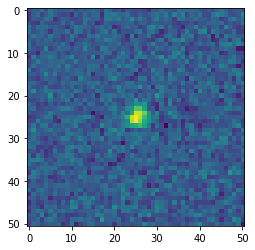

In [133]:
plt.imshow(twod[0][0])